In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 20
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_firstorder_Range_firstorder_Skewness_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_Run

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 648)
(3944610, 8)
validation
(464344, 648)
(464344, 8)
test
(574820, 648)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 648)]             0         


 dense (Dense)               (None, 1024)              664576    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1354632 (5.17 MB)


Trainable params: 1354632 (5.17 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 11:50 - loss: 2.3343 - STD: 0.0659 - MAE: 0.2209

  4/395 [..............................] - ETA: 8s - loss: 2.1511 - STD: 0.0439 - MAE: 0.2183   

  7/395 [..............................] - ETA: 8s - loss: 2.1246 - STD: 0.0532 - MAE: 0.2168

 10/395 [..............................] - ETA: 8s - loss: 2.1123 - STD: 0.0531 - MAE: 0.2165

 13/395 [..............................] - ETA: 8s - loss: 2.0989 - STD: 0.0496 - MAE: 0.2165

 16/395 [>.............................] - ETA: 8s - loss: 2.0898 - STD: 0.0456 - MAE: 0.2165

 19/395 [>.............................] - ETA: 8s - loss: 2.0846 - STD: 0.0423 - MAE: 0.2167

 22/395 [>.............................] - ETA: 8s - loss: 2.0796 - STD: 0.0398 - MAE: 0.2167

 25/395 [>.............................] - ETA: 8s - loss: 2.0743 - STD: 0.0387 - MAE: 0.2167

 28/395 [=>............................] - ETA: 8s - loss: 2.0695 - STD: 0.0386 - MAE: 0.2165

 31/395 [=>............................] - ETA: 7s - loss: 2.0640 - STD: 0.0387 - MAE: 0.2164

 34/395 [=>............................] - ETA: 7s - loss: 2.0574 - STD: 0.0390 - MAE: 0.2162

 37/395 [=>............................] - ETA: 7s - loss: 2.0499 - STD: 0.0393 - MAE: 0.2159

 40/395 [==>...........................] - ETA: 7s - loss: 2.0415 - STD: 0.0401 - MAE: 0.2156

 43/395 [==>...........................] - ETA: 7s - loss: 2.0323 - STD: 0.0414 - MAE: 0.2152

 46/395 [==>...........................] - ETA: 7s - loss: 2.0231 - STD: 0.0429 - MAE: 0.2148

 49/395 [==>...........................] - ETA: 7s - loss: 2.0136 - STD: 0.0445 - MAE: 0.2144

 52/395 [==>...........................] - ETA: 7s - loss: 2.0039 - STD: 0.0462 - MAE: 0.2139

 55/395 [===>..........................] - ETA: 7s - loss: 1.9944 - STD: 0.0480 - MAE: 0.2134

 58/395 [===>..........................] - ETA: 7s - loss: 1.9847 - STD: 0.0495 - MAE: 0.2129

 61/395 [===>..........................] - ETA: 7s - loss: 1.9746 - STD: 0.0510 - MAE: 0.2124

 64/395 [===>..........................] - ETA: 7s - loss: 1.9639 - STD: 0.0526 - MAE: 0.2119

 67/395 [====>.........................] - ETA: 7s - loss: 1.9522 - STD: 0.0541 - MAE: 0.2114

 70/395 [====>.........................] - ETA: 7s - loss: 1.9393 - STD: 0.0557 - MAE: 0.2107

 73/395 [====>.........................] - ETA: 7s - loss: 1.9262 - STD: 0.0576 - MAE: 0.2100

 76/395 [====>.........................] - ETA: 6s - loss: 1.9127 - STD: 0.0594 - MAE: 0.2093

 79/395 [=====>........................] - ETA: 6s - loss: 1.8993 - STD: 0.0614 - MAE: 0.2085

 82/395 [=====>........................] - ETA: 6s - loss: 1.8856 - STD: 0.0634 - MAE: 0.2077

 85/395 [=====>........................] - ETA: 6s - loss: 1.8722 - STD: 0.0655 - MAE: 0.2069

 88/395 [=====>........................] - ETA: 6s - loss: 1.8591 - STD: 0.0675 - MAE: 0.2061

 91/395 [=====>........................] - ETA: 6s - loss: 1.8465 - STD: 0.0695 - MAE: 0.2053

 94/395 [======>.......................] - ETA: 6s - loss: 1.8339 - STD: 0.0716 - MAE: 0.2045

 97/395 [======>.......................] - ETA: 6s - loss: 1.8216 - STD: 0.0736 - MAE: 0.2037

100/395 [======>.......................] - ETA: 6s - loss: 1.8098 - STD: 0.0755 - MAE: 0.2029

103/395 [======>.......................] - ETA: 6s - loss: 1.7981 - STD: 0.0773 - MAE: 0.2021

106/395 [=======>......................] - ETA: 6s - loss: 1.7869 - STD: 0.0791 - MAE: 0.2014

109/395 [=======>......................] - ETA: 6s - loss: 1.7763 - STD: 0.0809 - MAE: 0.2006

112/395 [=======>......................] - ETA: 6s - loss: 1.7658 - STD: 0.0826 - MAE: 0.1999

115/395 [=======>......................] - ETA: 6s - loss: 1.7555 - STD: 0.0842 - MAE: 0.1992

118/395 [=======>......................] - ETA: 6s - loss: 1.7456 - STD: 0.0858 - MAE: 0.1985

121/395 [========>.....................] - ETA: 5s - loss: 1.7360 - STD: 0.0874 - MAE: 0.1978

124/395 [========>.....................] - ETA: 5s - loss: 1.7268 - STD: 0.0889 - MAE: 0.1971

127/395 [========>.....................] - ETA: 5s - loss: 1.7178 - STD: 0.0904 - MAE: 0.1965

130/395 [========>.....................] - ETA: 5s - loss: 1.7093 - STD: 0.0919 - MAE: 0.1958

133/395 [=========>....................] - ETA: 5s - loss: 1.7011 - STD: 0.0933 - MAE: 0.1952

136/395 [=========>....................] - ETA: 5s - loss: 1.6932 - STD: 0.0947 - MAE: 0.1946

139/395 [=========>....................] - ETA: 5s - loss: 1.6853 - STD: 0.0960 - MAE: 0.1940

142/395 [=========>....................] - ETA: 7s - loss: 1.6791 - STD: 0.0973 - MAE: 0.1935

145/395 [==========>...................] - ETA: 7s - loss: 1.6718 - STD: 0.0985 - MAE: 0.1929

148/395 [==========>...................] - ETA: 6s - loss: 1.6644 - STD: 0.0998 - MAE: 0.1923

151/395 [==========>...................] - ETA: 6s - loss: 1.6575 - STD: 0.1010 - MAE: 0.1918

154/395 [==========>...................] - ETA: 6s - loss: 1.6505 - STD: 0.1022 - MAE: 0.1913

157/395 [==========>...................] - ETA: 6s - loss: 1.6438 - STD: 0.1033 - MAE: 0.1908

160/395 [===========>..................] - ETA: 6s - loss: 1.6374 - STD: 0.1044 - MAE: 0.1903

163/395 [===========>..................] - ETA: 6s - loss: 1.6312 - STD: 0.1055 - MAE: 0.1898

166/395 [===========>..................] - ETA: 6s - loss: 1.6253 - STD: 0.1065 - MAE: 0.1893

169/395 [===========>..................] - ETA: 6s - loss: 1.6193 - STD: 0.1076 - MAE: 0.1888

172/395 [============>.................] - ETA: 6s - loss: 1.6137 - STD: 0.1085 - MAE: 0.1884

175/395 [============>.................] - ETA: 5s - loss: 1.6079 - STD: 0.1095 - MAE: 0.1879

178/395 [============>.................] - ETA: 5s - loss: 1.6023 - STD: 0.1104 - MAE: 0.1875

181/395 [============>.................] - ETA: 5s - loss: 1.5969 - STD: 0.1113 - MAE: 0.1871

184/395 [============>.................] - ETA: 5s - loss: 1.5916 - STD: 0.1123 - MAE: 0.1866

187/395 [=============>................] - ETA: 5s - loss: 1.5863 - STD: 0.1131 - MAE: 0.1862

190/395 [=============>................] - ETA: 5s - loss: 1.5814 - STD: 0.1140 - MAE: 0.1858

193/395 [=============>................] - ETA: 5s - loss: 1.5765 - STD: 0.1148 - MAE: 0.1854

196/395 [=============>................] - ETA: 5s - loss: 1.5718 - STD: 0.1156 - MAE: 0.1851

199/395 [==============>...............] - ETA: 5s - loss: 1.5671 - STD: 0.1164 - MAE: 0.1847

202/395 [==============>...............] - ETA: 5s - loss: 1.5624 - STD: 0.1172 - MAE: 0.1843

205/395 [==============>...............] - ETA: 5s - loss: 1.5578 - STD: 0.1180 - MAE: 0.1839

208/395 [==============>...............] - ETA: 4s - loss: 1.5537 - STD: 0.1188 - MAE: 0.1836

211/395 [===============>..............] - ETA: 4s - loss: 1.5493 - STD: 0.1195 - MAE: 0.1832

214/395 [===============>..............] - ETA: 4s - loss: 1.5452 - STD: 0.1202 - MAE: 0.1829

217/395 [===============>..............] - ETA: 4s - loss: 1.5411 - STD: 0.1209 - MAE: 0.1825

220/395 [===============>..............] - ETA: 4s - loss: 1.5372 - STD: 0.1216 - MAE: 0.1822

223/395 [===============>..............] - ETA: 4s - loss: 1.5333 - STD: 0.1223 - MAE: 0.1819

226/395 [================>.............] - ETA: 4s - loss: 1.5295 - STD: 0.1229 - MAE: 0.1816

229/395 [================>.............] - ETA: 4s - loss: 1.5257 - STD: 0.1236 - MAE: 0.1813

232/395 [================>.............] - ETA: 4s - loss: 1.5221 - STD: 0.1242 - MAE: 0.1809

235/395 [================>.............] - ETA: 4s - loss: 1.5185 - STD: 0.1249 - MAE: 0.1806

238/395 [=================>............] - ETA: 4s - loss: 1.5148 - STD: 0.1255 - MAE: 0.1803

241/395 [=================>............] - ETA: 3s - loss: 1.5111 - STD: 0.1261 - MAE: 0.1800

244/395 [=================>............] - ETA: 3s - loss: 1.5076 - STD: 0.1267 - MAE: 0.1797

247/395 [=================>............] - ETA: 3s - loss: 1.5043 - STD: 0.1273 - MAE: 0.1795

250/395 [=================>............] - ETA: 3s - loss: 1.5010 - STD: 0.1279 - MAE: 0.1792

253/395 [==================>...........] - ETA: 3s - loss: 1.4978 - STD: 0.1284 - MAE: 0.1789

256/395 [==================>...........] - ETA: 3s - loss: 1.4946 - STD: 0.1290 - MAE: 0.1786

259/395 [==================>...........] - ETA: 3s - loss: 1.4914 - STD: 0.1295 - MAE: 0.1784

262/395 [==================>...........] - ETA: 3s - loss: 1.4883 - STD: 0.1301 - MAE: 0.1781

265/395 [===================>..........] - ETA: 3s - loss: 1.4852 - STD: 0.1306 - MAE: 0.1778

268/395 [===================>..........] - ETA: 3s - loss: 1.4822 - STD: 0.1311 - MAE: 0.1776

271/395 [===================>..........] - ETA: 3s - loss: 1.4793 - STD: 0.1316 - MAE: 0.1773

274/395 [===================>..........] - ETA: 3s - loss: 1.4764 - STD: 0.1321 - MAE: 0.1771

277/395 [====================>.........] - ETA: 2s - loss: 1.4734 - STD: 0.1326 - MAE: 0.1768

280/395 [====================>.........] - ETA: 2s - loss: 1.4706 - STD: 0.1331 - MAE: 0.1766

283/395 [====================>.........] - ETA: 2s - loss: 1.4678 - STD: 0.1336 - MAE: 0.1764

286/395 [====================>.........] - ETA: 2s - loss: 1.4651 - STD: 0.1340 - MAE: 0.1761

289/395 [====================>.........] - ETA: 2s - loss: 1.4624 - STD: 0.1345 - MAE: 0.1759

292/395 [=====================>........] - ETA: 2s - loss: 1.4596 - STD: 0.1349 - MAE: 0.1757

295/395 [=====================>........] - ETA: 2s - loss: 1.4569 - STD: 0.1354 - MAE: 0.1754

298/395 [=====================>........] - ETA: 2s - loss: 1.4544 - STD: 0.1359 - MAE: 0.1752

301/395 [=====================>........] - ETA: 2s - loss: 1.4517 - STD: 0.1363 - MAE: 0.1750

304/395 [======================>.......] - ETA: 2s - loss: 1.4491 - STD: 0.1367 - MAE: 0.1747

307/395 [======================>.......] - ETA: 2s - loss: 1.4465 - STD: 0.1371 - MAE: 0.1745

310/395 [======================>.......] - ETA: 2s - loss: 1.4439 - STD: 0.1376 - MAE: 0.1743

313/395 [======================>.......] - ETA: 2s - loss: 1.4414 - STD: 0.1380 - MAE: 0.1741

316/395 [=======================>......] - ETA: 1s - loss: 1.4390 - STD: 0.1384 - MAE: 0.1739

319/395 [=======================>......] - ETA: 1s - loss: 1.4366 - STD: 0.1388 - MAE: 0.1737

322/395 [=======================>......] - ETA: 1s - loss: 1.4343 - STD: 0.1392 - MAE: 0.1735

325/395 [=======================>......] - ETA: 1s - loss: 1.4321 - STD: 0.1396 - MAE: 0.1733

328/395 [=======================>......] - ETA: 1s - loss: 1.4298 - STD: 0.1400 - MAE: 0.1731

331/395 [========================>.....] - ETA: 1s - loss: 1.4276 - STD: 0.1404 - MAE: 0.1729

334/395 [========================>.....] - ETA: 1s - loss: 1.4253 - STD: 0.1407 - MAE: 0.1727

337/395 [========================>.....] - ETA: 1s - loss: 1.4230 - STD: 0.1411 - MAE: 0.1725

340/395 [========================>.....] - ETA: 1s - loss: 1.4208 - STD: 0.1415 - MAE: 0.1723

343/395 [=========================>....] - ETA: 1s - loss: 1.4187 - STD: 0.1418 - MAE: 0.1721

346/395 [=========================>....] - ETA: 1s - loss: 1.4165 - STD: 0.1422 - MAE: 0.1719

349/395 [=========================>....] - ETA: 1s - loss: 1.4144 - STD: 0.1426 - MAE: 0.1717

352/395 [=========================>....] - ETA: 1s - loss: 1.4123 - STD: 0.1429 - MAE: 0.1715

355/395 [=========================>....] - ETA: 0s - loss: 1.4101 - STD: 0.1433 - MAE: 0.1713

358/395 [==========================>...] - ETA: 0s - loss: 1.4081 - STD: 0.1436 - MAE: 0.1712

361/395 [==========================>...] - ETA: 0s - loss: 1.4062 - STD: 0.1439 - MAE: 0.1710

364/395 [==========================>...] - ETA: 0s - loss: 1.4043 - STD: 0.1443 - MAE: 0.1708

367/395 [==========================>...] - ETA: 0s - loss: 1.4023 - STD: 0.1446 - MAE: 0.1706

370/395 [===========================>..] - ETA: 0s - loss: 1.4004 - STD: 0.1449 - MAE: 0.1705

373/395 [===========================>..] - ETA: 0s - loss: 1.3984 - STD: 0.1453 - MAE: 0.1703

376/395 [===========================>..] - ETA: 0s - loss: 1.3965 - STD: 0.1456 - MAE: 0.1701

379/395 [===========================>..] - ETA: 0s - loss: 1.3945 - STD: 0.1459 - MAE: 0.1700

382/395 [============================>.] - ETA: 0s - loss: 1.3927 - STD: 0.1462 - MAE: 0.1698

385/395 [============================>.] - ETA: 0s - loss: 1.3908 - STD: 0.1465 - MAE: 0.1696

388/395 [============================>.] - ETA: 0s - loss: 1.3890 - STD: 0.1468 - MAE: 0.1695

391/395 [============================>.] - ETA: 0s - loss: 1.3871 - STD: 0.1471 - MAE: 0.1693

394/395 [============================>.] - ETA: 0s - loss: 1.3853 - STD: 0.1474 - MAE: 0.1691

395/395 [==============================] - 13s 29ms/step - loss: 1.3847 - STD: 0.1475 - MAE: 0.1691 - val_loss: 1.1704 - val_STD: 0.1886 - val_MAE: 0.1463


Epoch 2/10000


  1/395 [..............................] - ETA: 18s - loss: 1.1306 - STD: 0.1889 - MAE: 0.1461

  4/395 [..............................] - ETA: 8s - loss: 1.1469 - STD: 0.1867 - MAE: 0.1476 

  7/395 [..............................] - ETA: 8s - loss: 1.1421 - STD: 0.1864 - MAE: 0.1476

 10/395 [..............................] - ETA: 8s - loss: 1.1383 - STD: 0.1866 - MAE: 0.1473

 13/395 [..............................] - ETA: 8s - loss: 1.1355 - STD: 0.1869 - MAE: 0.1471

 16/395 [>.............................] - ETA: 8s - loss: 1.1352 - STD: 0.1872 - MAE: 0.1470

 19/395 [>.............................] - ETA: 8s - loss: 1.1396 - STD: 0.1873 - MAE: 0.1471

 22/395 [>.............................] - ETA: 8s - loss: 1.1392 - STD: 0.1875 - MAE: 0.1471

 25/395 [>.............................] - ETA: 8s - loss: 1.1414 - STD: 0.1875 - MAE: 0.1472

 28/395 [=>............................] - ETA: 8s - loss: 1.1409 - STD: 0.1877 - MAE: 0.1471

 31/395 [=>............................] - ETA: 7s - loss: 1.1399 - STD: 0.1877 - MAE: 0.1470

 34/395 [=>............................] - ETA: 7s - loss: 1.1400 - STD: 0.1876 - MAE: 0.1471

 37/395 [=>............................] - ETA: 7s - loss: 1.1388 - STD: 0.1876 - MAE: 0.1470

 40/395 [==>...........................] - ETA: 7s - loss: 1.1385 - STD: 0.1876 - MAE: 0.1470

 43/395 [==>...........................] - ETA: 7s - loss: 1.1379 - STD: 0.1877 - MAE: 0.1469

 46/395 [==>...........................] - ETA: 7s - loss: 1.1364 - STD: 0.1878 - MAE: 0.1468

 49/395 [==>...........................] - ETA: 7s - loss: 1.1360 - STD: 0.1879 - MAE: 0.1468

 52/395 [==>...........................] - ETA: 7s - loss: 1.1348 - STD: 0.1880 - MAE: 0.1467

 55/395 [===>..........................] - ETA: 7s - loss: 1.1341 - STD: 0.1881 - MAE: 0.1466

 58/395 [===>..........................] - ETA: 7s - loss: 1.1332 - STD: 0.1882 - MAE: 0.1465

 61/395 [===>..........................] - ETA: 7s - loss: 1.1322 - STD: 0.1883 - MAE: 0.1464

 64/395 [===>..........................] - ETA: 7s - loss: 1.1319 - STD: 0.1884 - MAE: 0.1464

 67/395 [====>.........................] - ETA: 7s - loss: 1.1317 - STD: 0.1884 - MAE: 0.1464

 70/395 [====>.........................] - ETA: 7s - loss: 1.1314 - STD: 0.1885 - MAE: 0.1463

 73/395 [====>.........................] - ETA: 7s - loss: 1.1308 - STD: 0.1886 - MAE: 0.1462

 76/395 [====>.........................] - ETA: 6s - loss: 1.1305 - STD: 0.1887 - MAE: 0.1462

 79/395 [=====>........................] - ETA: 6s - loss: 1.1304 - STD: 0.1887 - MAE: 0.1462

 82/395 [=====>........................] - ETA: 6s - loss: 1.1295 - STD: 0.1888 - MAE: 0.1461

 85/395 [=====>........................] - ETA: 6s - loss: 1.1288 - STD: 0.1888 - MAE: 0.1460

 88/395 [=====>........................] - ETA: 6s - loss: 1.1280 - STD: 0.1889 - MAE: 0.1460

 91/395 [=====>........................] - ETA: 6s - loss: 1.1276 - STD: 0.1890 - MAE: 0.1459

 94/395 [======>.......................] - ETA: 6s - loss: 1.1271 - STD: 0.1890 - MAE: 0.1459

 97/395 [======>.......................] - ETA: 6s - loss: 1.1271 - STD: 0.1891 - MAE: 0.1458

100/395 [======>.......................] - ETA: 6s - loss: 1.1265 - STD: 0.1892 - MAE: 0.1458

103/395 [======>.......................] - ETA: 6s - loss: 1.1259 - STD: 0.1892 - MAE: 0.1457

106/395 [=======>......................] - ETA: 6s - loss: 1.1249 - STD: 0.1893 - MAE: 0.1457

109/395 [=======>......................] - ETA: 6s - loss: 1.1240 - STD: 0.1894 - MAE: 0.1456

112/395 [=======>......................] - ETA: 6s - loss: 1.1234 - STD: 0.1895 - MAE: 0.1455

115/395 [=======>......................] - ETA: 6s - loss: 1.1226 - STD: 0.1896 - MAE: 0.1454

118/395 [=======>......................] - ETA: 6s - loss: 1.1218 - STD: 0.1896 - MAE: 0.1453

121/395 [========>.....................] - ETA: 5s - loss: 1.1210 - STD: 0.1897 - MAE: 0.1453

124/395 [========>.....................] - ETA: 5s - loss: 1.1204 - STD: 0.1898 - MAE: 0.1452

127/395 [========>.....................] - ETA: 5s - loss: 1.1203 - STD: 0.1899 - MAE: 0.1452

130/395 [========>.....................] - ETA: 5s - loss: 1.1200 - STD: 0.1900 - MAE: 0.1451

133/395 [=========>....................] - ETA: 5s - loss: 1.1195 - STD: 0.1901 - MAE: 0.1450

136/395 [=========>....................] - ETA: 5s - loss: 1.1187 - STD: 0.1901 - MAE: 0.1450

139/395 [=========>....................] - ETA: 5s - loss: 1.1183 - STD: 0.1902 - MAE: 0.1449

142/395 [=========>....................] - ETA: 5s - loss: 1.1179 - STD: 0.1903 - MAE: 0.1449

145/395 [==========>...................] - ETA: 5s - loss: 1.1175 - STD: 0.1904 - MAE: 0.1448

148/395 [==========>...................] - ETA: 5s - loss: 1.1172 - STD: 0.1904 - MAE: 0.1448

151/395 [==========>...................] - ETA: 5s - loss: 1.1168 - STD: 0.1905 - MAE: 0.1447

154/395 [==========>...................] - ETA: 5s - loss: 1.1163 - STD: 0.1906 - MAE: 0.1447

157/395 [==========>...................] - ETA: 5s - loss: 1.1159 - STD: 0.1906 - MAE: 0.1446

160/395 [===========>..................] - ETA: 5s - loss: 1.1154 - STD: 0.1907 - MAE: 0.1446

163/395 [===========>..................] - ETA: 5s - loss: 1.1149 - STD: 0.1907 - MAE: 0.1445

166/395 [===========>..................] - ETA: 4s - loss: 1.1144 - STD: 0.1908 - MAE: 0.1445

169/395 [===========>..................] - ETA: 4s - loss: 1.1139 - STD: 0.1909 - MAE: 0.1444

172/395 [============>.................] - ETA: 4s - loss: 1.1135 - STD: 0.1909 - MAE: 0.1444

175/395 [============>.................] - ETA: 4s - loss: 1.1131 - STD: 0.1910 - MAE: 0.1443

178/395 [============>.................] - ETA: 4s - loss: 1.1128 - STD: 0.1911 - MAE: 0.1443

181/395 [============>.................] - ETA: 4s - loss: 1.1125 - STD: 0.1912 - MAE: 0.1442

184/395 [============>.................] - ETA: 4s - loss: 1.1122 - STD: 0.1912 - MAE: 0.1442

187/395 [=============>................] - ETA: 4s - loss: 1.1116 - STD: 0.1913 - MAE: 0.1441

190/395 [=============>................] - ETA: 4s - loss: 1.1110 - STD: 0.1914 - MAE: 0.1441

193/395 [=============>................] - ETA: 4s - loss: 1.1106 - STD: 0.1914 - MAE: 0.1440

196/395 [=============>................] - ETA: 4s - loss: 1.1101 - STD: 0.1915 - MAE: 0.1440

199/395 [==============>...............] - ETA: 4s - loss: 1.1094 - STD: 0.1916 - MAE: 0.1439

202/395 [==============>...............] - ETA: 4s - loss: 1.1086 - STD: 0.1916 - MAE: 0.1438

205/395 [==============>...............] - ETA: 4s - loss: 1.1080 - STD: 0.1917 - MAE: 0.1438

208/395 [==============>...............] - ETA: 4s - loss: 1.1075 - STD: 0.1918 - MAE: 0.1437

211/395 [===============>..............] - ETA: 3s - loss: 1.1071 - STD: 0.1919 - MAE: 0.1437

214/395 [===============>..............] - ETA: 3s - loss: 1.1065 - STD: 0.1920 - MAE: 0.1436

217/395 [===============>..............] - ETA: 3s - loss: 1.1060 - STD: 0.1920 - MAE: 0.1435

220/395 [===============>..............] - ETA: 3s - loss: 1.1057 - STD: 0.1921 - MAE: 0.1435

223/395 [===============>..............] - ETA: 3s - loss: 1.1054 - STD: 0.1922 - MAE: 0.1434

226/395 [================>.............] - ETA: 3s - loss: 1.1050 - STD: 0.1923 - MAE: 0.1434

229/395 [================>.............] - ETA: 3s - loss: 1.1046 - STD: 0.1923 - MAE: 0.1433

232/395 [================>.............] - ETA: 3s - loss: 1.1041 - STD: 0.1924 - MAE: 0.1433

235/395 [================>.............] - ETA: 3s - loss: 1.1037 - STD: 0.1925 - MAE: 0.1432

238/395 [=================>............] - ETA: 3s - loss: 1.1033 - STD: 0.1925 - MAE: 0.1432

241/395 [=================>............] - ETA: 3s - loss: 1.1028 - STD: 0.1926 - MAE: 0.1431

244/395 [=================>............] - ETA: 3s - loss: 1.1022 - STD: 0.1927 - MAE: 0.1431

247/395 [=================>............] - ETA: 3s - loss: 1.1017 - STD: 0.1927 - MAE: 0.1430

250/395 [=================>............] - ETA: 3s - loss: 1.1012 - STD: 0.1928 - MAE: 0.1430

253/395 [==================>...........] - ETA: 3s - loss: 1.1005 - STD: 0.1929 - MAE: 0.1429

256/395 [==================>...........] - ETA: 3s - loss: 1.1000 - STD: 0.1929 - MAE: 0.1428

259/395 [==================>...........] - ETA: 2s - loss: 1.0994 - STD: 0.1930 - MAE: 0.1428

262/395 [==================>...........] - ETA: 2s - loss: 1.0988 - STD: 0.1931 - MAE: 0.1427

265/395 [===================>..........] - ETA: 2s - loss: 1.0982 - STD: 0.1932 - MAE: 0.1427

268/395 [===================>..........] - ETA: 2s - loss: 1.0975 - STD: 0.1932 - MAE: 0.1426

271/395 [===================>..........] - ETA: 2s - loss: 1.0971 - STD: 0.1933 - MAE: 0.1425

274/395 [===================>..........] - ETA: 2s - loss: 1.0965 - STD: 0.1934 - MAE: 0.1425

277/395 [====================>.........] - ETA: 2s - loss: 1.0960 - STD: 0.1934 - MAE: 0.1424

280/395 [====================>.........] - ETA: 2s - loss: 1.0956 - STD: 0.1935 - MAE: 0.1424

283/395 [====================>.........] - ETA: 2s - loss: 1.0952 - STD: 0.1936 - MAE: 0.1423

286/395 [====================>.........] - ETA: 2s - loss: 1.0948 - STD: 0.1937 - MAE: 0.1423

289/395 [====================>.........] - ETA: 2s - loss: 1.0945 - STD: 0.1937 - MAE: 0.1422

292/395 [=====================>........] - ETA: 2s - loss: 1.0941 - STD: 0.1938 - MAE: 0.1422

295/395 [=====================>........] - ETA: 2s - loss: 1.0935 - STD: 0.1938 - MAE: 0.1421

298/395 [=====================>........] - ETA: 2s - loss: 1.0931 - STD: 0.1939 - MAE: 0.1421

301/395 [=====================>........] - ETA: 2s - loss: 1.0926 - STD: 0.1940 - MAE: 0.1420

304/395 [======================>.......] - ETA: 1s - loss: 1.0923 - STD: 0.1940 - MAE: 0.1420

307/395 [======================>.......] - ETA: 1s - loss: 1.0920 - STD: 0.1941 - MAE: 0.1419

310/395 [======================>.......] - ETA: 1s - loss: 1.0917 - STD: 0.1942 - MAE: 0.1419

313/395 [======================>.......] - ETA: 1s - loss: 1.0913 - STD: 0.1942 - MAE: 0.1419

316/395 [=======================>......] - ETA: 1s - loss: 1.0908 - STD: 0.1943 - MAE: 0.1418

319/395 [=======================>......] - ETA: 1s - loss: 1.0903 - STD: 0.1943 - MAE: 0.1418

322/395 [=======================>......] - ETA: 1s - loss: 1.0898 - STD: 0.1944 - MAE: 0.1417

325/395 [=======================>......] - ETA: 1s - loss: 1.0894 - STD: 0.1945 - MAE: 0.1417

328/395 [=======================>......] - ETA: 1s - loss: 1.0890 - STD: 0.1945 - MAE: 0.1416

331/395 [========================>.....] - ETA: 1s - loss: 1.0885 - STD: 0.1946 - MAE: 0.1416

334/395 [========================>.....] - ETA: 1s - loss: 1.0882 - STD: 0.1947 - MAE: 0.1415

337/395 [========================>.....] - ETA: 1s - loss: 1.0877 - STD: 0.1947 - MAE: 0.1415

340/395 [========================>.....] - ETA: 1s - loss: 1.0873 - STD: 0.1948 - MAE: 0.1414

343/395 [=========================>....] - ETA: 1s - loss: 1.0869 - STD: 0.1948 - MAE: 0.1414

346/395 [=========================>....] - ETA: 1s - loss: 1.0863 - STD: 0.1949 - MAE: 0.1413

349/395 [=========================>....] - ETA: 1s - loss: 1.0858 - STD: 0.1949 - MAE: 0.1413

352/395 [=========================>....] - ETA: 0s - loss: 1.0855 - STD: 0.1950 - MAE: 0.1412

355/395 [=========================>....] - ETA: 0s - loss: 1.0852 - STD: 0.1951 - MAE: 0.1412

358/395 [==========================>...] - ETA: 0s - loss: 1.0849 - STD: 0.1951 - MAE: 0.1412

361/395 [==========================>...] - ETA: 0s - loss: 1.0846 - STD: 0.1952 - MAE: 0.1411

364/395 [==========================>...] - ETA: 0s - loss: 1.0842 - STD: 0.1952 - MAE: 0.1411

367/395 [==========================>...] - ETA: 0s - loss: 1.0837 - STD: 0.1953 - MAE: 0.1410

370/395 [===========================>..] - ETA: 0s - loss: 1.0833 - STD: 0.1954 - MAE: 0.1410

373/395 [===========================>..] - ETA: 0s - loss: 1.0829 - STD: 0.1954 - MAE: 0.1409

376/395 [===========================>..] - ETA: 0s - loss: 1.0825 - STD: 0.1955 - MAE: 0.1409

379/395 [===========================>..] - ETA: 0s - loss: 1.0821 - STD: 0.1955 - MAE: 0.1408

382/395 [============================>.] - ETA: 0s - loss: 1.0817 - STD: 0.1956 - MAE: 0.1408

385/395 [============================>.] - ETA: 0s - loss: 1.0813 - STD: 0.1957 - MAE: 0.1407

388/395 [============================>.] - ETA: 0s - loss: 1.0810 - STD: 0.1957 - MAE: 0.1407

391/395 [============================>.] - ETA: 0s - loss: 1.0806 - STD: 0.1958 - MAE: 0.1407

394/395 [============================>.] - ETA: 0s - loss: 1.0802 - STD: 0.1958 - MAE: 0.1406

395/395 [==============================] - 9s 24ms/step - loss: 1.0801 - STD: 0.1959 - MAE: 0.1406 - val_loss: 1.1221 - val_STD: 0.2021 - val_MAE: 0.1377


Epoch 3/10000


  1/395 [..............................] - ETA: 20s - loss: 1.0294 - STD: 0.2024 - MAE: 0.1352

  4/395 [..............................] - ETA: 8s - loss: 1.0300 - STD: 0.2025 - MAE: 0.1351 

  7/395 [..............................] - ETA: 8s - loss: 1.0308 - STD: 0.2028 - MAE: 0.1352

 10/395 [..............................] - ETA: 8s - loss: 1.0293 - STD: 0.2034 - MAE: 0.1349

 13/395 [..............................] - ETA: 8s - loss: 1.0294 - STD: 0.2035 - MAE: 0.1348

 16/395 [>.............................] - ETA: 8s - loss: 1.0281 - STD: 0.2033 - MAE: 0.1348

 19/395 [>.............................] - ETA: 8s - loss: 1.0261 - STD: 0.2032 - MAE: 0.1348

 22/395 [>.............................] - ETA: 8s - loss: 1.0245 - STD: 0.2033 - MAE: 0.1346

 25/395 [>.............................] - ETA: 8s - loss: 1.0258 - STD: 0.2034 - MAE: 0.1346

 28/395 [=>............................] - ETA: 8s - loss: 1.0257 - STD: 0.2034 - MAE: 0.1346

 31/395 [=>............................] - ETA: 7s - loss: 1.0257 - STD: 0.2034 - MAE: 0.1346

 34/395 [=>............................] - ETA: 7s - loss: 1.0254 - STD: 0.2035 - MAE: 0.1346

 37/395 [=>............................] - ETA: 7s - loss: 1.0256 - STD: 0.2036 - MAE: 0.1345

 40/395 [==>...........................] - ETA: 7s - loss: 1.0251 - STD: 0.2036 - MAE: 0.1345

 43/395 [==>...........................] - ETA: 7s - loss: 1.0257 - STD: 0.2037 - MAE: 0.1345

 46/395 [==>...........................] - ETA: 7s - loss: 1.0255 - STD: 0.2037 - MAE: 0.1345

 49/395 [==>...........................] - ETA: 7s - loss: 1.0251 - STD: 0.2037 - MAE: 0.1344

 52/395 [==>...........................] - ETA: 7s - loss: 1.0247 - STD: 0.2038 - MAE: 0.1344

 55/395 [===>..........................] - ETA: 7s - loss: 1.0248 - STD: 0.2039 - MAE: 0.1344

 58/395 [===>..........................] - ETA: 7s - loss: 1.0245 - STD: 0.2039 - MAE: 0.1343

 61/395 [===>..........................] - ETA: 7s - loss: 1.0239 - STD: 0.2039 - MAE: 0.1343

 64/395 [===>..........................] - ETA: 7s - loss: 1.0231 - STD: 0.2040 - MAE: 0.1342

 67/395 [====>.........................] - ETA: 7s - loss: 1.0228 - STD: 0.2040 - MAE: 0.1342

 70/395 [====>.........................] - ETA: 7s - loss: 1.0221 - STD: 0.2040 - MAE: 0.1341

 73/395 [====>.........................] - ETA: 7s - loss: 1.0218 - STD: 0.2040 - MAE: 0.1341

 76/395 [====>.........................] - ETA: 6s - loss: 1.0213 - STD: 0.2041 - MAE: 0.1340

 79/395 [=====>........................] - ETA: 6s - loss: 1.0206 - STD: 0.2041 - MAE: 0.1340

 82/395 [=====>........................] - ETA: 6s - loss: 1.0201 - STD: 0.2042 - MAE: 0.1339

 85/395 [=====>........................] - ETA: 6s - loss: 1.0198 - STD: 0.2043 - MAE: 0.1339

 88/395 [=====>........................] - ETA: 6s - loss: 1.0195 - STD: 0.2043 - MAE: 0.1339

 91/395 [=====>........................] - ETA: 6s - loss: 1.0192 - STD: 0.2044 - MAE: 0.1338

 94/395 [======>.......................] - ETA: 6s - loss: 1.0187 - STD: 0.2044 - MAE: 0.1338

 97/395 [======>.......................] - ETA: 6s - loss: 1.0184 - STD: 0.2045 - MAE: 0.1338

100/395 [======>.......................] - ETA: 6s - loss: 1.0184 - STD: 0.2045 - MAE: 0.1337

103/395 [======>.......................] - ETA: 6s - loss: 1.0179 - STD: 0.2046 - MAE: 0.1337

106/395 [=======>......................] - ETA: 6s - loss: 1.0178 - STD: 0.2046 - MAE: 0.1337

109/395 [=======>......................] - ETA: 6s - loss: 1.0179 - STD: 0.2047 - MAE: 0.1336

112/395 [=======>......................] - ETA: 6s - loss: 1.0175 - STD: 0.2047 - MAE: 0.1336

115/395 [=======>......................] - ETA: 6s - loss: 1.0173 - STD: 0.2048 - MAE: 0.1336

118/395 [=======>......................] - ETA: 6s - loss: 1.0172 - STD: 0.2048 - MAE: 0.1335

121/395 [========>.....................] - ETA: 5s - loss: 1.0168 - STD: 0.2048 - MAE: 0.1335

124/395 [========>.....................] - ETA: 5s - loss: 1.0165 - STD: 0.2049 - MAE: 0.1335

127/395 [========>.....................] - ETA: 5s - loss: 1.0164 - STD: 0.2050 - MAE: 0.1334

130/395 [========>.....................] - ETA: 5s - loss: 1.0159 - STD: 0.2050 - MAE: 0.1334

133/395 [=========>....................] - ETA: 5s - loss: 1.0154 - STD: 0.2050 - MAE: 0.1333

136/395 [=========>....................] - ETA: 5s - loss: 1.0148 - STD: 0.2051 - MAE: 0.1333

139/395 [=========>....................] - ETA: 5s - loss: 1.0145 - STD: 0.2051 - MAE: 0.1333

142/395 [=========>....................] - ETA: 5s - loss: 1.0141 - STD: 0.2052 - MAE: 0.1332

145/395 [==========>...................] - ETA: 5s - loss: 1.0140 - STD: 0.2052 - MAE: 0.1332

148/395 [==========>...................] - ETA: 5s - loss: 1.0138 - STD: 0.2053 - MAE: 0.1331

151/395 [==========>...................] - ETA: 5s - loss: 1.0136 - STD: 0.2053 - MAE: 0.1331

154/395 [==========>...................] - ETA: 5s - loss: 1.0136 - STD: 0.2053 - MAE: 0.1331

157/395 [==========>...................] - ETA: 5s - loss: 1.0134 - STD: 0.2054 - MAE: 0.1331

160/395 [===========>..................] - ETA: 5s - loss: 1.0133 - STD: 0.2054 - MAE: 0.1330

163/395 [===========>..................] - ETA: 5s - loss: 1.0132 - STD: 0.2055 - MAE: 0.1330

166/395 [===========>..................] - ETA: 4s - loss: 1.0128 - STD: 0.2055 - MAE: 0.1330

169/395 [===========>..................] - ETA: 4s - loss: 1.0123 - STD: 0.2055 - MAE: 0.1329

172/395 [============>.................] - ETA: 4s - loss: 1.0120 - STD: 0.2056 - MAE: 0.1329

175/395 [============>.................] - ETA: 4s - loss: 1.0121 - STD: 0.2056 - MAE: 0.1329

178/395 [============>.................] - ETA: 4s - loss: 1.0118 - STD: 0.2057 - MAE: 0.1329

181/395 [============>.................] - ETA: 4s - loss: 1.0117 - STD: 0.2057 - MAE: 0.1329

184/395 [============>.................] - ETA: 4s - loss: 1.0114 - STD: 0.2057 - MAE: 0.1328

187/395 [=============>................] - ETA: 4s - loss: 1.0111 - STD: 0.2058 - MAE: 0.1328

190/395 [=============>................] - ETA: 4s - loss: 1.0107 - STD: 0.2058 - MAE: 0.1328

193/395 [=============>................] - ETA: 4s - loss: 1.0103 - STD: 0.2058 - MAE: 0.1327

196/395 [=============>................] - ETA: 4s - loss: 1.0099 - STD: 0.2059 - MAE: 0.1327

199/395 [==============>...............] - ETA: 4s - loss: 1.0096 - STD: 0.2059 - MAE: 0.1326

202/395 [==============>...............] - ETA: 4s - loss: 1.0096 - STD: 0.2059 - MAE: 0.1326

205/395 [==============>...............] - ETA: 4s - loss: 1.0095 - STD: 0.2060 - MAE: 0.1326

208/395 [==============>...............] - ETA: 4s - loss: 1.0096 - STD: 0.2060 - MAE: 0.1326

211/395 [===============>..............] - ETA: 4s - loss: 1.0093 - STD: 0.2060 - MAE: 0.1326

214/395 [===============>..............] - ETA: 3s - loss: 1.0090 - STD: 0.2061 - MAE: 0.1325

217/395 [===============>..............] - ETA: 3s - loss: 1.0087 - STD: 0.2061 - MAE: 0.1325

220/395 [===============>..............] - ETA: 3s - loss: 1.0084 - STD: 0.2061 - MAE: 0.1325

223/395 [===============>..............] - ETA: 3s - loss: 1.0082 - STD: 0.2062 - MAE: 0.1324

226/395 [================>.............] - ETA: 3s - loss: 1.0078 - STD: 0.2062 - MAE: 0.1324

229/395 [================>.............] - ETA: 3s - loss: 1.0074 - STD: 0.2062 - MAE: 0.1324

232/395 [================>.............] - ETA: 3s - loss: 1.0069 - STD: 0.2063 - MAE: 0.1323

235/395 [================>.............] - ETA: 3s - loss: 1.0066 - STD: 0.2063 - MAE: 0.1323

238/395 [=================>............] - ETA: 3s - loss: 1.0061 - STD: 0.2063 - MAE: 0.1323

241/395 [=================>............] - ETA: 3s - loss: 1.0057 - STD: 0.2064 - MAE: 0.1322

244/395 [=================>............] - ETA: 3s - loss: 1.0053 - STD: 0.2064 - MAE: 0.1322

247/395 [=================>............] - ETA: 3s - loss: 1.0049 - STD: 0.2065 - MAE: 0.1321

250/395 [=================>............] - ETA: 3s - loss: 1.0046 - STD: 0.2065 - MAE: 0.1321

253/395 [==================>...........] - ETA: 3s - loss: 1.0044 - STD: 0.2066 - MAE: 0.1320

256/395 [==================>...........] - ETA: 3s - loss: 1.0042 - STD: 0.2066 - MAE: 0.1320

259/395 [==================>...........] - ETA: 2s - loss: 1.0045 - STD: 0.2067 - MAE: 0.1320

262/395 [==================>...........] - ETA: 2s - loss: 1.0044 - STD: 0.2067 - MAE: 0.1320

265/395 [===================>..........] - ETA: 2s - loss: 1.0044 - STD: 0.2068 - MAE: 0.1320

268/395 [===================>..........] - ETA: 2s - loss: 1.0044 - STD: 0.2068 - MAE: 0.1320

271/395 [===================>..........] - ETA: 2s - loss: 1.0044 - STD: 0.2068 - MAE: 0.1320

274/395 [===================>..........] - ETA: 2s - loss: 1.0043 - STD: 0.2068 - MAE: 0.1319

277/395 [====================>.........] - ETA: 2s - loss: 1.0042 - STD: 0.2069 - MAE: 0.1319

280/395 [====================>.........] - ETA: 2s - loss: 1.0039 - STD: 0.2069 - MAE: 0.1319

283/395 [====================>.........] - ETA: 2s - loss: 1.0037 - STD: 0.2069 - MAE: 0.1319

286/395 [====================>.........] - ETA: 2s - loss: 1.0034 - STD: 0.2069 - MAE: 0.1318

289/395 [====================>.........] - ETA: 2s - loss: 1.0030 - STD: 0.2070 - MAE: 0.1318

292/395 [=====================>........] - ETA: 2s - loss: 1.0028 - STD: 0.2070 - MAE: 0.1318

295/395 [=====================>........] - ETA: 2s - loss: 1.0025 - STD: 0.2070 - MAE: 0.1318

298/395 [=====================>........] - ETA: 2s - loss: 1.0023 - STD: 0.2071 - MAE: 0.1317

301/395 [=====================>........] - ETA: 2s - loss: 1.0019 - STD: 0.2071 - MAE: 0.1317

304/395 [======================>.......] - ETA: 1s - loss: 1.0016 - STD: 0.2071 - MAE: 0.1317

307/395 [======================>.......] - ETA: 1s - loss: 1.0014 - STD: 0.2072 - MAE: 0.1316

310/395 [======================>.......] - ETA: 1s - loss: 1.0011 - STD: 0.2072 - MAE: 0.1316

313/395 [======================>.......] - ETA: 1s - loss: 1.0010 - STD: 0.2072 - MAE: 0.1316

316/395 [=======================>......] - ETA: 1s - loss: 1.0009 - STD: 0.2073 - MAE: 0.1316

319/395 [=======================>......] - ETA: 1s - loss: 1.0010 - STD: 0.2073 - MAE: 0.1315

322/395 [=======================>......] - ETA: 1s - loss: 1.0008 - STD: 0.2073 - MAE: 0.1315

325/395 [=======================>......] - ETA: 1s - loss: 1.0007 - STD: 0.2074 - MAE: 0.1315

328/395 [=======================>......] - ETA: 1s - loss: 1.0004 - STD: 0.2074 - MAE: 0.1315

331/395 [========================>.....] - ETA: 1s - loss: 1.0000 - STD: 0.2074 - MAE: 0.1314

334/395 [========================>.....] - ETA: 1s - loss: 0.9997 - STD: 0.2074 - MAE: 0.1314

337/395 [========================>.....] - ETA: 1s - loss: 0.9994 - STD: 0.2075 - MAE: 0.1314

340/395 [========================>.....] - ETA: 1s - loss: 0.9990 - STD: 0.2075 - MAE: 0.1313

343/395 [=========================>....] - ETA: 1s - loss: 0.9988 - STD: 0.2075 - MAE: 0.1313

346/395 [=========================>....] - ETA: 1s - loss: 0.9985 - STD: 0.2076 - MAE: 0.1313

349/395 [=========================>....] - ETA: 1s - loss: 0.9982 - STD: 0.2076 - MAE: 0.1313

352/395 [=========================>....] - ETA: 0s - loss: 0.9980 - STD: 0.2076 - MAE: 0.1312

355/395 [=========================>....] - ETA: 0s - loss: 0.9977 - STD: 0.2077 - MAE: 0.1312

358/395 [==========================>...] - ETA: 0s - loss: 0.9974 - STD: 0.2077 - MAE: 0.1312

361/395 [==========================>...] - ETA: 0s - loss: 0.9972 - STD: 0.2077 - MAE: 0.1312

364/395 [==========================>...] - ETA: 0s - loss: 0.9968 - STD: 0.2078 - MAE: 0.1311

367/395 [==========================>...] - ETA: 0s - loss: 0.9965 - STD: 0.2078 - MAE: 0.1311

370/395 [===========================>..] - ETA: 0s - loss: 0.9964 - STD: 0.2078 - MAE: 0.1311

373/395 [===========================>..] - ETA: 0s - loss: 0.9962 - STD: 0.2079 - MAE: 0.1310

376/395 [===========================>..] - ETA: 0s - loss: 0.9961 - STD: 0.2079 - MAE: 0.1310

379/395 [===========================>..] - ETA: 0s - loss: 0.9958 - STD: 0.2079 - MAE: 0.1310

382/395 [============================>.] - ETA: 0s - loss: 0.9956 - STD: 0.2080 - MAE: 0.1310

385/395 [============================>.] - ETA: 0s - loss: 0.9954 - STD: 0.2080 - MAE: 0.1309

388/395 [============================>.] - ETA: 0s - loss: 0.9952 - STD: 0.2080 - MAE: 0.1309

391/395 [============================>.] - ETA: 0s - loss: 0.9950 - STD: 0.2081 - MAE: 0.1309

394/395 [============================>.] - ETA: 0s - loss: 0.9949 - STD: 0.2081 - MAE: 0.1309

395/395 [==============================] - 9s 24ms/step - loss: 0.9948 - STD: 0.2081 - MAE: 0.1308 - val_loss: 1.0388 - val_STD: 0.2112 - val_MAE: 0.1309


Epoch 4/10000


  1/395 [..............................] - ETA: 21s - loss: 0.9555 - STD: 0.2120 - MAE: 0.1267

  4/395 [..............................] - ETA: 8s - loss: 0.9521 - STD: 0.2122 - MAE: 0.1267 

  7/395 [..............................] - ETA: 8s - loss: 0.9564 - STD: 0.2123 - MAE: 0.1269

 10/395 [..............................] - ETA: 8s - loss: 0.9536 - STD: 0.2123 - MAE: 0.1267

 13/395 [..............................] - ETA: 8s - loss: 0.9569 - STD: 0.2126 - MAE: 0.1268

 16/395 [>.............................] - ETA: 8s - loss: 0.9575 - STD: 0.2127 - MAE: 0.1267

 19/395 [>.............................] - ETA: 7s - loss: 0.9583 - STD: 0.2130 - MAE: 0.1267

 22/395 [>.............................] - ETA: 8s - loss: 0.9634 - STD: 0.2131 - MAE: 0.1269

 25/395 [>.............................] - ETA: 7s - loss: 0.9643 - STD: 0.2132 - MAE: 0.1270

 28/395 [=>............................] - ETA: 7s - loss: 0.9655 - STD: 0.2131 - MAE: 0.1271

 31/395 [=>............................] - ETA: 7s - loss: 0.9660 - STD: 0.2131 - MAE: 0.1271

 34/395 [=>............................] - ETA: 7s - loss: 0.9664 - STD: 0.2131 - MAE: 0.1271

 37/395 [=>............................] - ETA: 7s - loss: 0.9652 - STD: 0.2131 - MAE: 0.1270

 40/395 [==>...........................] - ETA: 7s - loss: 0.9653 - STD: 0.2130 - MAE: 0.1271

 43/395 [==>...........................] - ETA: 7s - loss: 0.9655 - STD: 0.2131 - MAE: 0.1271

 46/395 [==>...........................] - ETA: 7s - loss: 0.9653 - STD: 0.2131 - MAE: 0.1270

 49/395 [==>...........................] - ETA: 7s - loss: 0.9654 - STD: 0.2130 - MAE: 0.1270

 52/395 [==>...........................] - ETA: 7s - loss: 0.9652 - STD: 0.2131 - MAE: 0.1270

 55/395 [===>..........................] - ETA: 7s - loss: 0.9651 - STD: 0.2131 - MAE: 0.1270

 58/395 [===>..........................] - ETA: 7s - loss: 0.9648 - STD: 0.2131 - MAE: 0.1270

 61/395 [===>..........................] - ETA: 7s - loss: 0.9646 - STD: 0.2131 - MAE: 0.1270

 64/395 [===>..........................] - ETA: 7s - loss: 0.9650 - STD: 0.2131 - MAE: 0.1270

 67/395 [====>.........................] - ETA: 7s - loss: 0.9648 - STD: 0.2131 - MAE: 0.1270

 70/395 [====>.........................] - ETA: 7s - loss: 0.9646 - STD: 0.2131 - MAE: 0.1270

 73/395 [====>.........................] - ETA: 7s - loss: 0.9641 - STD: 0.2131 - MAE: 0.1269

 76/395 [====>.........................] - ETA: 6s - loss: 0.9642 - STD: 0.2131 - MAE: 0.1269

 79/395 [=====>........................] - ETA: 6s - loss: 0.9633 - STD: 0.2131 - MAE: 0.1269

 82/395 [=====>........................] - ETA: 6s - loss: 0.9629 - STD: 0.2132 - MAE: 0.1268

 85/395 [=====>........................] - ETA: 6s - loss: 0.9623 - STD: 0.2132 - MAE: 0.1268

 88/395 [=====>........................] - ETA: 6s - loss: 0.9620 - STD: 0.2132 - MAE: 0.1268

 91/395 [=====>........................] - ETA: 6s - loss: 0.9615 - STD: 0.2132 - MAE: 0.1267

 94/395 [======>.......................] - ETA: 6s - loss: 0.9612 - STD: 0.2132 - MAE: 0.1267

 97/395 [======>.......................] - ETA: 6s - loss: 0.9610 - STD: 0.2133 - MAE: 0.1267

100/395 [======>.......................] - ETA: 6s - loss: 0.9609 - STD: 0.2133 - MAE: 0.1266

103/395 [======>.......................] - ETA: 6s - loss: 0.9606 - STD: 0.2134 - MAE: 0.1266

106/395 [=======>......................] - ETA: 6s - loss: 0.9605 - STD: 0.2134 - MAE: 0.1266

109/395 [=======>......................] - ETA: 6s - loss: 0.9605 - STD: 0.2134 - MAE: 0.1266

112/395 [=======>......................] - ETA: 6s - loss: 0.9601 - STD: 0.2134 - MAE: 0.1266

115/395 [=======>......................] - ETA: 6s - loss: 0.9600 - STD: 0.2135 - MAE: 0.1265

118/395 [=======>......................] - ETA: 6s - loss: 0.9597 - STD: 0.2135 - MAE: 0.1265

121/395 [========>.....................] - ETA: 5s - loss: 0.9594 - STD: 0.2135 - MAE: 0.1265

124/395 [========>.....................] - ETA: 5s - loss: 0.9589 - STD: 0.2135 - MAE: 0.1265

127/395 [========>.....................] - ETA: 5s - loss: 0.9586 - STD: 0.2136 - MAE: 0.1264

130/395 [========>.....................] - ETA: 5s - loss: 0.9584 - STD: 0.2136 - MAE: 0.1264

133/395 [=========>....................] - ETA: 5s - loss: 0.9579 - STD: 0.2136 - MAE: 0.1264

136/395 [=========>....................] - ETA: 5s - loss: 0.9576 - STD: 0.2136 - MAE: 0.1263

139/395 [=========>....................] - ETA: 5s - loss: 0.9579 - STD: 0.2137 - MAE: 0.1263

142/395 [=========>....................] - ETA: 5s - loss: 0.9578 - STD: 0.2137 - MAE: 0.1263

145/395 [==========>...................] - ETA: 5s - loss: 0.9579 - STD: 0.2137 - MAE: 0.1263

148/395 [==========>...................] - ETA: 5s - loss: 0.9577 - STD: 0.2138 - MAE: 0.1263

151/395 [==========>...................] - ETA: 5s - loss: 0.9577 - STD: 0.2138 - MAE: 0.1263

154/395 [==========>...................] - ETA: 5s - loss: 0.9581 - STD: 0.2138 - MAE: 0.1263

157/395 [==========>...................] - ETA: 5s - loss: 0.9580 - STD: 0.2138 - MAE: 0.1263

160/395 [===========>..................] - ETA: 5s - loss: 0.9579 - STD: 0.2139 - MAE: 0.1263

163/395 [===========>..................] - ETA: 5s - loss: 0.9577 - STD: 0.2139 - MAE: 0.1262

166/395 [===========>..................] - ETA: 4s - loss: 0.9574 - STD: 0.2139 - MAE: 0.1262

169/395 [===========>..................] - ETA: 4s - loss: 0.9569 - STD: 0.2139 - MAE: 0.1262

172/395 [============>.................] - ETA: 4s - loss: 0.9566 - STD: 0.2139 - MAE: 0.1261

175/395 [============>.................] - ETA: 4s - loss: 0.9563 - STD: 0.2140 - MAE: 0.1261

178/395 [============>.................] - ETA: 4s - loss: 0.9562 - STD: 0.2140 - MAE: 0.1261

181/395 [============>.................] - ETA: 4s - loss: 0.9561 - STD: 0.2140 - MAE: 0.1261

184/395 [============>.................] - ETA: 4s - loss: 0.9560 - STD: 0.2140 - MAE: 0.1261

187/395 [=============>................] - ETA: 4s - loss: 0.9558 - STD: 0.2140 - MAE: 0.1260

190/395 [=============>................] - ETA: 4s - loss: 0.9556 - STD: 0.2141 - MAE: 0.1260

193/395 [=============>................] - ETA: 4s - loss: 0.9554 - STD: 0.2141 - MAE: 0.1260

196/395 [=============>................] - ETA: 4s - loss: 0.9552 - STD: 0.2141 - MAE: 0.1260

199/395 [==============>...............] - ETA: 4s - loss: 0.9550 - STD: 0.2141 - MAE: 0.1260

202/395 [==============>...............] - ETA: 4s - loss: 0.9548 - STD: 0.2142 - MAE: 0.1259

205/395 [==============>...............] - ETA: 4s - loss: 0.9546 - STD: 0.2142 - MAE: 0.1259

208/395 [==============>...............] - ETA: 4s - loss: 0.9543 - STD: 0.2142 - MAE: 0.1259

211/395 [===============>..............] - ETA: 4s - loss: 0.9541 - STD: 0.2142 - MAE: 0.1259

214/395 [===============>..............] - ETA: 3s - loss: 0.9539 - STD: 0.2142 - MAE: 0.1258

217/395 [===============>..............] - ETA: 3s - loss: 0.9536 - STD: 0.2143 - MAE: 0.1258

220/395 [===============>..............] - ETA: 3s - loss: 0.9532 - STD: 0.2143 - MAE: 0.1258

223/395 [===============>..............] - ETA: 3s - loss: 0.9530 - STD: 0.2143 - MAE: 0.1258

226/395 [================>.............] - ETA: 3s - loss: 0.9528 - STD: 0.2143 - MAE: 0.1257

229/395 [================>.............] - ETA: 3s - loss: 0.9525 - STD: 0.2144 - MAE: 0.1257

232/395 [================>.............] - ETA: 3s - loss: 0.9521 - STD: 0.2144 - MAE: 0.1257

235/395 [================>.............] - ETA: 3s - loss: 0.9518 - STD: 0.2144 - MAE: 0.1256

238/395 [=================>............] - ETA: 3s - loss: 0.9517 - STD: 0.2145 - MAE: 0.1256

241/395 [=================>............] - ETA: 3s - loss: 0.9514 - STD: 0.2145 - MAE: 0.1256

244/395 [=================>............] - ETA: 3s - loss: 0.9512 - STD: 0.2145 - MAE: 0.1256

247/395 [=================>............] - ETA: 3s - loss: 0.9509 - STD: 0.2145 - MAE: 0.1255

250/395 [=================>............] - ETA: 3s - loss: 0.9507 - STD: 0.2146 - MAE: 0.1255

253/395 [==================>...........] - ETA: 3s - loss: 0.9505 - STD: 0.2146 - MAE: 0.1255

256/395 [==================>...........] - ETA: 3s - loss: 0.9502 - STD: 0.2146 - MAE: 0.1255

259/395 [==================>...........] - ETA: 2s - loss: 0.9501 - STD: 0.2146 - MAE: 0.1255

262/395 [==================>...........] - ETA: 2s - loss: 0.9500 - STD: 0.2147 - MAE: 0.1254

265/395 [===================>..........] - ETA: 2s - loss: 0.9498 - STD: 0.2147 - MAE: 0.1254

268/395 [===================>..........] - ETA: 2s - loss: 0.9497 - STD: 0.2147 - MAE: 0.1254

271/395 [===================>..........] - ETA: 2s - loss: 0.9496 - STD: 0.2148 - MAE: 0.1254

274/395 [===================>..........] - ETA: 2s - loss: 0.9496 - STD: 0.2148 - MAE: 0.1254

277/395 [====================>.........] - ETA: 2s - loss: 0.9496 - STD: 0.2148 - MAE: 0.1253

280/395 [====================>.........] - ETA: 2s - loss: 0.9494 - STD: 0.2148 - MAE: 0.1253

283/395 [====================>.........] - ETA: 2s - loss: 0.9492 - STD: 0.2149 - MAE: 0.1253

286/395 [====================>.........] - ETA: 2s - loss: 0.9490 - STD: 0.2149 - MAE: 0.1253

289/395 [====================>.........] - ETA: 2s - loss: 0.9489 - STD: 0.2149 - MAE: 0.1253

292/395 [=====================>........] - ETA: 2s - loss: 0.9488 - STD: 0.2149 - MAE: 0.1252

295/395 [=====================>........] - ETA: 2s - loss: 0.9487 - STD: 0.2150 - MAE: 0.1252

298/395 [=====================>........] - ETA: 2s - loss: 0.9487 - STD: 0.2150 - MAE: 0.1252

301/395 [=====================>........] - ETA: 2s - loss: 0.9488 - STD: 0.2150 - MAE: 0.1252

304/395 [======================>.......] - ETA: 1s - loss: 0.9486 - STD: 0.2150 - MAE: 0.1252

307/395 [======================>.......] - ETA: 1s - loss: 0.9484 - STD: 0.2150 - MAE: 0.1252

310/395 [======================>.......] - ETA: 1s - loss: 0.9482 - STD: 0.2150 - MAE: 0.1252

313/395 [======================>.......] - ETA: 1s - loss: 0.9480 - STD: 0.2151 - MAE: 0.1251

316/395 [=======================>......] - ETA: 1s - loss: 0.9479 - STD: 0.2151 - MAE: 0.1251

319/395 [=======================>......] - ETA: 1s - loss: 0.9477 - STD: 0.2151 - MAE: 0.1251

322/395 [=======================>......] - ETA: 1s - loss: 0.9476 - STD: 0.2151 - MAE: 0.1251

325/395 [=======================>......] - ETA: 1s - loss: 0.9474 - STD: 0.2152 - MAE: 0.1251

328/395 [=======================>......] - ETA: 1s - loss: 0.9472 - STD: 0.2152 - MAE: 0.1250

331/395 [========================>.....] - ETA: 1s - loss: 0.9470 - STD: 0.2152 - MAE: 0.1250

334/395 [========================>.....] - ETA: 1s - loss: 0.9468 - STD: 0.2152 - MAE: 0.1250

337/395 [========================>.....] - ETA: 1s - loss: 0.9466 - STD: 0.2153 - MAE: 0.1250

340/395 [========================>.....] - ETA: 1s - loss: 0.9465 - STD: 0.2153 - MAE: 0.1250

343/395 [=========================>....] - ETA: 1s - loss: 0.9464 - STD: 0.2153 - MAE: 0.1249

346/395 [=========================>....] - ETA: 1s - loss: 0.9462 - STD: 0.2153 - MAE: 0.1249

349/395 [=========================>....] - ETA: 1s - loss: 0.9461 - STD: 0.2153 - MAE: 0.1249

352/395 [=========================>....] - ETA: 0s - loss: 0.9460 - STD: 0.2154 - MAE: 0.1249

355/395 [=========================>....] - ETA: 0s - loss: 0.9460 - STD: 0.2154 - MAE: 0.1249

358/395 [==========================>...] - ETA: 0s - loss: 0.9459 - STD: 0.2154 - MAE: 0.1249

361/395 [==========================>...] - ETA: 0s - loss: 0.9458 - STD: 0.2154 - MAE: 0.1249

364/395 [==========================>...] - ETA: 0s - loss: 0.9458 - STD: 0.2155 - MAE: 0.1248

367/395 [==========================>...] - ETA: 0s - loss: 0.9455 - STD: 0.2155 - MAE: 0.1248

370/395 [===========================>..] - ETA: 0s - loss: 0.9455 - STD: 0.2155 - MAE: 0.1248

373/395 [===========================>..] - ETA: 0s - loss: 0.9453 - STD: 0.2155 - MAE: 0.1248

376/395 [===========================>..] - ETA: 0s - loss: 0.9453 - STD: 0.2155 - MAE: 0.1248

379/395 [===========================>..] - ETA: 0s - loss: 0.9452 - STD: 0.2155 - MAE: 0.1248

382/395 [============================>.] - ETA: 0s - loss: 0.9450 - STD: 0.2156 - MAE: 0.1247

385/395 [============================>.] - ETA: 0s - loss: 0.9449 - STD: 0.2156 - MAE: 0.1247

388/395 [============================>.] - ETA: 0s - loss: 0.9448 - STD: 0.2156 - MAE: 0.1247

391/395 [============================>.] - ETA: 0s - loss: 0.9448 - STD: 0.2156 - MAE: 0.1247

394/395 [============================>.] - ETA: 0s - loss: 0.9446 - STD: 0.2156 - MAE: 0.1247

395/395 [==============================] - 9s 24ms/step - loss: 0.9446 - STD: 0.2156 - MAE: 0.1247 - val_loss: 1.0495 - val_STD: 0.2165 - val_MAE: 0.1280


Epoch 5/10000


  1/395 [..............................] - ETA: 19s - loss: 0.9269 - STD: 0.2173 - MAE: 0.1232

  4/395 [..............................] - ETA: 8s - loss: 0.9223 - STD: 0.2174 - MAE: 0.1227 

  7/395 [..............................] - ETA: 8s - loss: 0.9271 - STD: 0.2178 - MAE: 0.1228

 10/395 [..............................] - ETA: 8s - loss: 0.9276 - STD: 0.2178 - MAE: 0.1228

 13/395 [..............................] - ETA: 8s - loss: 0.9263 - STD: 0.2177 - MAE: 0.1227

 16/395 [>.............................] - ETA: 8s - loss: 0.9233 - STD: 0.2177 - MAE: 0.1225

 19/395 [>.............................] - ETA: 8s - loss: 0.9221 - STD: 0.2177 - MAE: 0.1225

 22/395 [>.............................] - ETA: 8s - loss: 0.9201 - STD: 0.2179 - MAE: 0.1223

 25/395 [>.............................] - ETA: 8s - loss: 0.9204 - STD: 0.2180 - MAE: 0.1223

 28/395 [=>............................] - ETA: 7s - loss: 0.9216 - STD: 0.2181 - MAE: 0.1223

 31/395 [=>............................] - ETA: 7s - loss: 0.9212 - STD: 0.2183 - MAE: 0.1222

 34/395 [=>............................] - ETA: 7s - loss: 0.9222 - STD: 0.2183 - MAE: 0.1222

 37/395 [=>............................] - ETA: 7s - loss: 0.9224 - STD: 0.2184 - MAE: 0.1222

 40/395 [==>...........................] - ETA: 7s - loss: 0.9217 - STD: 0.2184 - MAE: 0.1221

 43/395 [==>...........................] - ETA: 7s - loss: 0.9231 - STD: 0.2185 - MAE: 0.1222

 46/395 [==>...........................] - ETA: 7s - loss: 0.9237 - STD: 0.2185 - MAE: 0.1223

 49/395 [==>...........................] - ETA: 7s - loss: 0.9238 - STD: 0.2185 - MAE: 0.1222

 52/395 [==>...........................] - ETA: 7s - loss: 0.9257 - STD: 0.2185 - MAE: 0.1223

 55/395 [===>..........................] - ETA: 7s - loss: 0.9258 - STD: 0.2186 - MAE: 0.1223

 58/395 [===>..........................] - ETA: 7s - loss: 0.9258 - STD: 0.2186 - MAE: 0.1223

 61/395 [===>..........................] - ETA: 7s - loss: 0.9254 - STD: 0.2185 - MAE: 0.1223

 64/395 [===>..........................] - ETA: 7s - loss: 0.9243 - STD: 0.2185 - MAE: 0.1223

 67/395 [====>.........................] - ETA: 7s - loss: 0.9235 - STD: 0.2185 - MAE: 0.1222

 70/395 [====>.........................] - ETA: 7s - loss: 0.9230 - STD: 0.2185 - MAE: 0.1222

 73/395 [====>.........................] - ETA: 6s - loss: 0.9223 - STD: 0.2186 - MAE: 0.1221

 76/395 [====>.........................] - ETA: 6s - loss: 0.9219 - STD: 0.2186 - MAE: 0.1221

 79/395 [=====>........................] - ETA: 6s - loss: 0.9220 - STD: 0.2187 - MAE: 0.1221

 82/395 [=====>........................] - ETA: 6s - loss: 0.9213 - STD: 0.2187 - MAE: 0.1220

 85/395 [=====>........................] - ETA: 6s - loss: 0.9210 - STD: 0.2187 - MAE: 0.1220

 88/395 [=====>........................] - ETA: 6s - loss: 0.9203 - STD: 0.2188 - MAE: 0.1219

 91/395 [=====>........................] - ETA: 6s - loss: 0.9199 - STD: 0.2188 - MAE: 0.1219

 94/395 [======>.......................] - ETA: 6s - loss: 0.9198 - STD: 0.2189 - MAE: 0.1218

 97/395 [======>.......................] - ETA: 6s - loss: 0.9194 - STD: 0.2189 - MAE: 0.1218

100/395 [======>.......................] - ETA: 6s - loss: 0.9191 - STD: 0.2190 - MAE: 0.1217

103/395 [======>.......................] - ETA: 6s - loss: 0.9196 - STD: 0.2190 - MAE: 0.1218

106/395 [=======>......................] - ETA: 6s - loss: 0.9196 - STD: 0.2190 - MAE: 0.1217

109/395 [=======>......................] - ETA: 5s - loss: 0.9194 - STD: 0.2190 - MAE: 0.1217

112/395 [=======>......................] - ETA: 5s - loss: 0.9193 - STD: 0.2191 - MAE: 0.1217

115/395 [=======>......................] - ETA: 5s - loss: 0.9190 - STD: 0.2191 - MAE: 0.1217

118/395 [=======>......................] - ETA: 5s - loss: 0.9190 - STD: 0.2191 - MAE: 0.1217

121/395 [========>.....................] - ETA: 5s - loss: 0.9185 - STD: 0.2191 - MAE: 0.1216

124/395 [========>.....................] - ETA: 5s - loss: 0.9183 - STD: 0.2191 - MAE: 0.1216

127/395 [========>.....................] - ETA: 5s - loss: 0.9179 - STD: 0.2191 - MAE: 0.1216

130/395 [========>.....................] - ETA: 5s - loss: 0.9177 - STD: 0.2192 - MAE: 0.1216

133/395 [=========>....................] - ETA: 5s - loss: 0.9174 - STD: 0.2192 - MAE: 0.1215

136/395 [=========>....................] - ETA: 5s - loss: 0.9175 - STD: 0.2192 - MAE: 0.1215

139/395 [=========>....................] - ETA: 5s - loss: 0.9173 - STD: 0.2192 - MAE: 0.1215

142/395 [=========>....................] - ETA: 5s - loss: 0.9175 - STD: 0.2192 - MAE: 0.1215

145/395 [==========>...................] - ETA: 5s - loss: 0.9174 - STD: 0.2193 - MAE: 0.1215

148/395 [==========>...................] - ETA: 5s - loss: 0.9170 - STD: 0.2193 - MAE: 0.1215

151/395 [==========>...................] - ETA: 5s - loss: 0.9167 - STD: 0.2193 - MAE: 0.1214

154/395 [==========>...................] - ETA: 4s - loss: 0.9165 - STD: 0.2193 - MAE: 0.1214

157/395 [==========>...................] - ETA: 4s - loss: 0.9161 - STD: 0.2193 - MAE: 0.1214

160/395 [===========>..................] - ETA: 4s - loss: 0.9160 - STD: 0.2193 - MAE: 0.1214

163/395 [===========>..................] - ETA: 4s - loss: 0.9157 - STD: 0.2194 - MAE: 0.1214

166/395 [===========>..................] - ETA: 4s - loss: 0.9158 - STD: 0.2194 - MAE: 0.1213

169/395 [===========>..................] - ETA: 4s - loss: 0.9158 - STD: 0.2194 - MAE: 0.1213

172/395 [============>.................] - ETA: 4s - loss: 0.9157 - STD: 0.2194 - MAE: 0.1213

175/395 [============>.................] - ETA: 4s - loss: 0.9155 - STD: 0.2195 - MAE: 0.1213

178/395 [============>.................] - ETA: 4s - loss: 0.9153 - STD: 0.2195 - MAE: 0.1213

181/395 [============>.................] - ETA: 4s - loss: 0.9154 - STD: 0.2195 - MAE: 0.1213

184/395 [============>.................] - ETA: 4s - loss: 0.9151 - STD: 0.2195 - MAE: 0.1212

187/395 [=============>................] - ETA: 4s - loss: 0.9150 - STD: 0.2196 - MAE: 0.1212

190/395 [=============>................] - ETA: 4s - loss: 0.9147 - STD: 0.2196 - MAE: 0.1212

193/395 [=============>................] - ETA: 4s - loss: 0.9147 - STD: 0.2196 - MAE: 0.1212

196/395 [=============>................] - ETA: 4s - loss: 0.9146 - STD: 0.2196 - MAE: 0.1212

199/395 [==============>...............] - ETA: 3s - loss: 0.9149 - STD: 0.2196 - MAE: 0.1212

202/395 [==============>...............] - ETA: 3s - loss: 0.9149 - STD: 0.2197 - MAE: 0.1212

205/395 [==============>...............] - ETA: 3s - loss: 0.9148 - STD: 0.2197 - MAE: 0.1212

208/395 [==============>...............] - ETA: 3s - loss: 0.9147 - STD: 0.2197 - MAE: 0.1211

211/395 [===============>..............] - ETA: 3s - loss: 0.9148 - STD: 0.2197 - MAE: 0.1211

214/395 [===============>..............] - ETA: 3s - loss: 0.9145 - STD: 0.2197 - MAE: 0.1211

217/395 [===============>..............] - ETA: 3s - loss: 0.9144 - STD: 0.2197 - MAE: 0.1211

220/395 [===============>..............] - ETA: 3s - loss: 0.9143 - STD: 0.2197 - MAE: 0.1211

223/395 [===============>..............] - ETA: 3s - loss: 0.9141 - STD: 0.2197 - MAE: 0.1211

226/395 [================>.............] - ETA: 3s - loss: 0.9143 - STD: 0.2197 - MAE: 0.1211

229/395 [================>.............] - ETA: 3s - loss: 0.9143 - STD: 0.2198 - MAE: 0.1211

232/395 [================>.............] - ETA: 3s - loss: 0.9140 - STD: 0.2198 - MAE: 0.1210

235/395 [================>.............] - ETA: 3s - loss: 0.9138 - STD: 0.2198 - MAE: 0.1210

238/395 [=================>............] - ETA: 3s - loss: 0.9136 - STD: 0.2198 - MAE: 0.1210

241/395 [=================>............] - ETA: 3s - loss: 0.9135 - STD: 0.2199 - MAE: 0.1210

244/395 [=================>............] - ETA: 3s - loss: 0.9133 - STD: 0.2199 - MAE: 0.1210

247/395 [=================>............] - ETA: 2s - loss: 0.9136 - STD: 0.2199 - MAE: 0.1210

250/395 [=================>............] - ETA: 2s - loss: 0.9135 - STD: 0.2199 - MAE: 0.1210

253/395 [==================>...........] - ETA: 2s - loss: 0.9136 - STD: 0.2199 - MAE: 0.1210

256/395 [==================>...........] - ETA: 2s - loss: 0.9139 - STD: 0.2199 - MAE: 0.1210

259/395 [==================>...........] - ETA: 2s - loss: 0.9137 - STD: 0.2199 - MAE: 0.1210

262/395 [==================>...........] - ETA: 2s - loss: 0.9136 - STD: 0.2199 - MAE: 0.1210

265/395 [===================>..........] - ETA: 2s - loss: 0.9134 - STD: 0.2199 - MAE: 0.1209

268/395 [===================>..........] - ETA: 2s - loss: 0.9133 - STD: 0.2199 - MAE: 0.1209

271/395 [===================>..........] - ETA: 2s - loss: 0.9132 - STD: 0.2199 - MAE: 0.1209

274/395 [===================>..........] - ETA: 2s - loss: 0.9131 - STD: 0.2200 - MAE: 0.1209

277/395 [====================>.........] - ETA: 2s - loss: 0.9130 - STD: 0.2200 - MAE: 0.1209

280/395 [====================>.........] - ETA: 2s - loss: 0.9128 - STD: 0.2200 - MAE: 0.1209

283/395 [====================>.........] - ETA: 2s - loss: 0.9127 - STD: 0.2200 - MAE: 0.1209

286/395 [====================>.........] - ETA: 2s - loss: 0.9124 - STD: 0.2200 - MAE: 0.1208

289/395 [====================>.........] - ETA: 2s - loss: 0.9122 - STD: 0.2200 - MAE: 0.1208

292/395 [=====================>........] - ETA: 2s - loss: 0.9120 - STD: 0.2200 - MAE: 0.1208

295/395 [=====================>........] - ETA: 2s - loss: 0.9124 - STD: 0.2201 - MAE: 0.1208

298/395 [=====================>........] - ETA: 1s - loss: 0.9124 - STD: 0.2201 - MAE: 0.1208

301/395 [=====================>........] - ETA: 1s - loss: 0.9124 - STD: 0.2201 - MAE: 0.1208

304/395 [======================>.......] - ETA: 1s - loss: 0.9124 - STD: 0.2201 - MAE: 0.1208

307/395 [======================>.......] - ETA: 1s - loss: 0.9124 - STD: 0.2201 - MAE: 0.1208

310/395 [======================>.......] - ETA: 1s - loss: 0.9123 - STD: 0.2201 - MAE: 0.1208

313/395 [======================>.......] - ETA: 1s - loss: 0.9121 - STD: 0.2201 - MAE: 0.1208

316/395 [=======================>......] - ETA: 1s - loss: 0.9119 - STD: 0.2202 - MAE: 0.1207

319/395 [=======================>......] - ETA: 1s - loss: 0.9118 - STD: 0.2202 - MAE: 0.1207

322/395 [=======================>......] - ETA: 1s - loss: 0.9115 - STD: 0.2202 - MAE: 0.1207

325/395 [=======================>......] - ETA: 1s - loss: 0.9113 - STD: 0.2202 - MAE: 0.1207

328/395 [=======================>......] - ETA: 1s - loss: 0.9111 - STD: 0.2202 - MAE: 0.1207

331/395 [========================>.....] - ETA: 1s - loss: 0.9111 - STD: 0.2202 - MAE: 0.1207

334/395 [========================>.....] - ETA: 1s - loss: 0.9111 - STD: 0.2203 - MAE: 0.1206

337/395 [========================>.....] - ETA: 1s - loss: 0.9110 - STD: 0.2203 - MAE: 0.1206

340/395 [========================>.....] - ETA: 1s - loss: 0.9108 - STD: 0.2203 - MAE: 0.1206

343/395 [=========================>....] - ETA: 1s - loss: 0.9107 - STD: 0.2203 - MAE: 0.1206

346/395 [=========================>....] - ETA: 0s - loss: 0.9105 - STD: 0.2203 - MAE: 0.1206

349/395 [=========================>....] - ETA: 0s - loss: 0.9105 - STD: 0.2203 - MAE: 0.1206

352/395 [=========================>....] - ETA: 0s - loss: 0.9105 - STD: 0.2203 - MAE: 0.1206

355/395 [=========================>....] - ETA: 0s - loss: 0.9104 - STD: 0.2204 - MAE: 0.1206

358/395 [==========================>...] - ETA: 0s - loss: 0.9104 - STD: 0.2204 - MAE: 0.1206

361/395 [==========================>...] - ETA: 0s - loss: 0.9102 - STD: 0.2204 - MAE: 0.1205

364/395 [==========================>...] - ETA: 0s - loss: 0.9102 - STD: 0.2204 - MAE: 0.1205

367/395 [==========================>...] - ETA: 0s - loss: 0.9102 - STD: 0.2204 - MAE: 0.1205

370/395 [===========================>..] - ETA: 0s - loss: 0.9100 - STD: 0.2204 - MAE: 0.1205

373/395 [===========================>..] - ETA: 0s - loss: 0.9099 - STD: 0.2204 - MAE: 0.1205

376/395 [===========================>..] - ETA: 0s - loss: 0.9099 - STD: 0.2205 - MAE: 0.1205

379/395 [===========================>..] - ETA: 0s - loss: 0.9098 - STD: 0.2205 - MAE: 0.1205

382/395 [============================>.] - ETA: 0s - loss: 0.9098 - STD: 0.2205 - MAE: 0.1205

385/395 [============================>.] - ETA: 0s - loss: 0.9096 - STD: 0.2205 - MAE: 0.1205

388/395 [============================>.] - ETA: 0s - loss: 0.9096 - STD: 0.2205 - MAE: 0.1204

391/395 [============================>.] - ETA: 0s - loss: 0.9095 - STD: 0.2205 - MAE: 0.1204

394/395 [============================>.] - ETA: 0s - loss: 0.9094 - STD: 0.2205 - MAE: 0.1204

395/395 [==============================] - 9s 21ms/step - loss: 0.9094 - STD: 0.2205 - MAE: 0.1204 - val_loss: 1.0449 - val_STD: 0.2198 - val_MAE: 0.1261


Epoch 6/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8994 - STD: 0.2206 - MAE: 0.1198

  4/395 [..............................] - ETA: 7s - loss: 0.8972 - STD: 0.2221 - MAE: 0.1189 

  7/395 [..............................] - ETA: 7s - loss: 0.8865 - STD: 0.2220 - MAE: 0.1183

 10/395 [..............................] - ETA: 7s - loss: 0.8872 - STD: 0.2221 - MAE: 0.1184

 13/395 [..............................] - ETA: 7s - loss: 0.8883 - STD: 0.2222 - MAE: 0.1184

 16/395 [>.............................] - ETA: 7s - loss: 0.8912 - STD: 0.2224 - MAE: 0.1184

 19/395 [>.............................] - ETA: 7s - loss: 0.8915 - STD: 0.2225 - MAE: 0.1184

 22/395 [>.............................] - ETA: 7s - loss: 0.8938 - STD: 0.2226 - MAE: 0.1185

 25/395 [>.............................] - ETA: 7s - loss: 0.8960 - STD: 0.2226 - MAE: 0.1187

 28/395 [=>............................] - ETA: 7s - loss: 0.8962 - STD: 0.2225 - MAE: 0.1187

 31/395 [=>............................] - ETA: 7s - loss: 0.8982 - STD: 0.2224 - MAE: 0.1189

 34/395 [=>............................] - ETA: 7s - loss: 0.8986 - STD: 0.2224 - MAE: 0.1189

 37/395 [=>............................] - ETA: 7s - loss: 0.8986 - STD: 0.2225 - MAE: 0.1189

 40/395 [==>...........................] - ETA: 6s - loss: 0.8997 - STD: 0.2226 - MAE: 0.1189

 43/395 [==>...........................] - ETA: 6s - loss: 0.9008 - STD: 0.2226 - MAE: 0.1190

 46/395 [==>...........................] - ETA: 6s - loss: 0.9022 - STD: 0.2225 - MAE: 0.1191

 49/395 [==>...........................] - ETA: 6s - loss: 0.9035 - STD: 0.2225 - MAE: 0.1192

 52/395 [==>...........................] - ETA: 6s - loss: 0.9041 - STD: 0.2224 - MAE: 0.1192

 55/395 [===>..........................] - ETA: 6s - loss: 0.9039 - STD: 0.2224 - MAE: 0.1192

 58/395 [===>..........................] - ETA: 6s - loss: 0.9039 - STD: 0.2224 - MAE: 0.1192

 61/395 [===>..........................] - ETA: 6s - loss: 0.9042 - STD: 0.2224 - MAE: 0.1193

 64/395 [===>..........................] - ETA: 6s - loss: 0.9035 - STD: 0.2223 - MAE: 0.1192

 67/395 [====>.........................] - ETA: 6s - loss: 0.9034 - STD: 0.2223 - MAE: 0.1192

 70/395 [====>.........................] - ETA: 6s - loss: 0.9028 - STD: 0.2223 - MAE: 0.1192

 73/395 [====>.........................] - ETA: 6s - loss: 0.9020 - STD: 0.2223 - MAE: 0.1192

 76/395 [====>.........................] - ETA: 6s - loss: 0.9013 - STD: 0.2222 - MAE: 0.1192

 79/395 [=====>........................] - ETA: 6s - loss: 0.9005 - STD: 0.2222 - MAE: 0.1191

 82/395 [=====>........................] - ETA: 6s - loss: 0.9001 - STD: 0.2223 - MAE: 0.1191

 85/395 [=====>........................] - ETA: 6s - loss: 0.8996 - STD: 0.2223 - MAE: 0.1191

 88/395 [=====>........................] - ETA: 6s - loss: 0.8989 - STD: 0.2223 - MAE: 0.1190

 91/395 [=====>........................] - ETA: 5s - loss: 0.8989 - STD: 0.2223 - MAE: 0.1190

 94/395 [======>.......................] - ETA: 5s - loss: 0.8985 - STD: 0.2223 - MAE: 0.1190

 97/395 [======>.......................] - ETA: 5s - loss: 0.8980 - STD: 0.2223 - MAE: 0.1189

100/395 [======>.......................] - ETA: 5s - loss: 0.8978 - STD: 0.2223 - MAE: 0.1189

103/395 [======>.......................] - ETA: 5s - loss: 0.8972 - STD: 0.2223 - MAE: 0.1189

106/395 [=======>......................] - ETA: 5s - loss: 0.8970 - STD: 0.2224 - MAE: 0.1188

109/395 [=======>......................] - ETA: 5s - loss: 0.8965 - STD: 0.2224 - MAE: 0.1188

112/395 [=======>......................] - ETA: 5s - loss: 0.8960 - STD: 0.2224 - MAE: 0.1188

115/395 [=======>......................] - ETA: 5s - loss: 0.8957 - STD: 0.2225 - MAE: 0.1187

118/395 [=======>......................] - ETA: 5s - loss: 0.8954 - STD: 0.2225 - MAE: 0.1187

121/395 [========>.....................] - ETA: 5s - loss: 0.8952 - STD: 0.2225 - MAE: 0.1187

124/395 [========>.....................] - ETA: 5s - loss: 0.8949 - STD: 0.2225 - MAE: 0.1186

127/395 [========>.....................] - ETA: 5s - loss: 0.8945 - STD: 0.2225 - MAE: 0.1186

130/395 [========>.....................] - ETA: 5s - loss: 0.8944 - STD: 0.2225 - MAE: 0.1186

133/395 [=========>....................] - ETA: 5s - loss: 0.8942 - STD: 0.2226 - MAE: 0.1186

136/395 [=========>....................] - ETA: 5s - loss: 0.8946 - STD: 0.2226 - MAE: 0.1186

139/395 [=========>....................] - ETA: 5s - loss: 0.8945 - STD: 0.2226 - MAE: 0.1186

142/395 [=========>....................] - ETA: 4s - loss: 0.8945 - STD: 0.2226 - MAE: 0.1186

145/395 [==========>...................] - ETA: 4s - loss: 0.8946 - STD: 0.2227 - MAE: 0.1186

148/395 [==========>...................] - ETA: 4s - loss: 0.8944 - STD: 0.2227 - MAE: 0.1185

151/395 [==========>...................] - ETA: 4s - loss: 0.8941 - STD: 0.2227 - MAE: 0.1185

154/395 [==========>...................] - ETA: 4s - loss: 0.8938 - STD: 0.2227 - MAE: 0.1185

157/395 [==========>...................] - ETA: 4s - loss: 0.8937 - STD: 0.2227 - MAE: 0.1185

160/395 [===========>..................] - ETA: 4s - loss: 0.8934 - STD: 0.2227 - MAE: 0.1184

163/395 [===========>..................] - ETA: 4s - loss: 0.8935 - STD: 0.2228 - MAE: 0.1184

166/395 [===========>..................] - ETA: 4s - loss: 0.8933 - STD: 0.2228 - MAE: 0.1184

169/395 [===========>..................] - ETA: 4s - loss: 0.8931 - STD: 0.2228 - MAE: 0.1184

172/395 [============>.................] - ETA: 4s - loss: 0.8928 - STD: 0.2228 - MAE: 0.1184

175/395 [============>.................] - ETA: 4s - loss: 0.8926 - STD: 0.2228 - MAE: 0.1184

178/395 [============>.................] - ETA: 4s - loss: 0.8924 - STD: 0.2229 - MAE: 0.1183

181/395 [============>.................] - ETA: 4s - loss: 0.8921 - STD: 0.2229 - MAE: 0.1183

184/395 [============>.................] - ETA: 4s - loss: 0.8921 - STD: 0.2229 - MAE: 0.1183

187/395 [=============>................] - ETA: 4s - loss: 0.8919 - STD: 0.2229 - MAE: 0.1183

190/395 [=============>................] - ETA: 4s - loss: 0.8919 - STD: 0.2229 - MAE: 0.1183

193/395 [=============>................] - ETA: 3s - loss: 0.8917 - STD: 0.2229 - MAE: 0.1183

196/395 [=============>................] - ETA: 3s - loss: 0.8918 - STD: 0.2230 - MAE: 0.1183

199/395 [==============>...............] - ETA: 3s - loss: 0.8918 - STD: 0.2230 - MAE: 0.1183

202/395 [==============>...............] - ETA: 3s - loss: 0.8919 - STD: 0.2230 - MAE: 0.1182

205/395 [==============>...............] - ETA: 3s - loss: 0.8920 - STD: 0.2230 - MAE: 0.1183

208/395 [==============>...............] - ETA: 3s - loss: 0.8920 - STD: 0.2230 - MAE: 0.1182

211/395 [===============>..............] - ETA: 3s - loss: 0.8917 - STD: 0.2230 - MAE: 0.1182

214/395 [===============>..............] - ETA: 3s - loss: 0.8914 - STD: 0.2230 - MAE: 0.1182

217/395 [===============>..............] - ETA: 3s - loss: 0.8912 - STD: 0.2230 - MAE: 0.1182

220/395 [===============>..............] - ETA: 3s - loss: 0.8909 - STD: 0.2231 - MAE: 0.1182

223/395 [===============>..............] - ETA: 3s - loss: 0.8907 - STD: 0.2231 - MAE: 0.1182

226/395 [================>.............] - ETA: 3s - loss: 0.8904 - STD: 0.2231 - MAE: 0.1181

229/395 [================>.............] - ETA: 3s - loss: 0.8903 - STD: 0.2231 - MAE: 0.1181

232/395 [================>.............] - ETA: 3s - loss: 0.8901 - STD: 0.2231 - MAE: 0.1181

235/395 [================>.............] - ETA: 3s - loss: 0.8902 - STD: 0.2231 - MAE: 0.1181

238/395 [=================>............] - ETA: 3s - loss: 0.8901 - STD: 0.2232 - MAE: 0.1181

241/395 [=================>............] - ETA: 3s - loss: 0.8901 - STD: 0.2232 - MAE: 0.1181

244/395 [=================>............] - ETA: 2s - loss: 0.8900 - STD: 0.2232 - MAE: 0.1180

247/395 [=================>............] - ETA: 2s - loss: 0.8900 - STD: 0.2232 - MAE: 0.1180

250/395 [=================>............] - ETA: 2s - loss: 0.8900 - STD: 0.2232 - MAE: 0.1180

253/395 [==================>...........] - ETA: 2s - loss: 0.8897 - STD: 0.2233 - MAE: 0.1180

256/395 [==================>...........] - ETA: 2s - loss: 0.8896 - STD: 0.2233 - MAE: 0.1180

259/395 [==================>...........] - ETA: 2s - loss: 0.8896 - STD: 0.2233 - MAE: 0.1180

262/395 [==================>...........] - ETA: 2s - loss: 0.8895 - STD: 0.2233 - MAE: 0.1180

265/395 [===================>..........] - ETA: 2s - loss: 0.8896 - STD: 0.2233 - MAE: 0.1180

268/395 [===================>..........] - ETA: 2s - loss: 0.8897 - STD: 0.2233 - MAE: 0.1180

271/395 [===================>..........] - ETA: 2s - loss: 0.8897 - STD: 0.2233 - MAE: 0.1180

274/395 [===================>..........] - ETA: 2s - loss: 0.8898 - STD: 0.2233 - MAE: 0.1180

277/395 [====================>.........] - ETA: 2s - loss: 0.8897 - STD: 0.2234 - MAE: 0.1180

280/395 [====================>.........] - ETA: 2s - loss: 0.8895 - STD: 0.2234 - MAE: 0.1179

283/395 [====================>.........] - ETA: 2s - loss: 0.8893 - STD: 0.2234 - MAE: 0.1179

286/395 [====================>.........] - ETA: 2s - loss: 0.8893 - STD: 0.2234 - MAE: 0.1179

289/395 [====================>.........] - ETA: 2s - loss: 0.8891 - STD: 0.2234 - MAE: 0.1179

292/395 [=====================>........] - ETA: 2s - loss: 0.8890 - STD: 0.2234 - MAE: 0.1179

295/395 [=====================>........] - ETA: 1s - loss: 0.8888 - STD: 0.2234 - MAE: 0.1179

298/395 [=====================>........] - ETA: 1s - loss: 0.8886 - STD: 0.2234 - MAE: 0.1179

301/395 [=====================>........] - ETA: 1s - loss: 0.8885 - STD: 0.2234 - MAE: 0.1179

304/395 [======================>.......] - ETA: 1s - loss: 0.8883 - STD: 0.2234 - MAE: 0.1178

307/395 [======================>.......] - ETA: 1s - loss: 0.8881 - STD: 0.2234 - MAE: 0.1178

310/395 [======================>.......] - ETA: 1s - loss: 0.8879 - STD: 0.2235 - MAE: 0.1178

313/395 [======================>.......] - ETA: 1s - loss: 0.8877 - STD: 0.2235 - MAE: 0.1178

316/395 [=======================>......] - ETA: 1s - loss: 0.8875 - STD: 0.2235 - MAE: 0.1178

319/395 [=======================>......] - ETA: 1s - loss: 0.8873 - STD: 0.2235 - MAE: 0.1177

322/395 [=======================>......] - ETA: 1s - loss: 0.8870 - STD: 0.2235 - MAE: 0.1177

325/395 [=======================>......] - ETA: 1s - loss: 0.8868 - STD: 0.2235 - MAE: 0.1177

328/395 [=======================>......] - ETA: 1s - loss: 0.8866 - STD: 0.2236 - MAE: 0.1177

331/395 [========================>.....] - ETA: 1s - loss: 0.8864 - STD: 0.2236 - MAE: 0.1177

334/395 [========================>.....] - ETA: 1s - loss: 0.8861 - STD: 0.2236 - MAE: 0.1176

337/395 [========================>.....] - ETA: 1s - loss: 0.8859 - STD: 0.2236 - MAE: 0.1176

340/395 [========================>.....] - ETA: 1s - loss: 0.8858 - STD: 0.2237 - MAE: 0.1176

343/395 [=========================>....] - ETA: 1s - loss: 0.8856 - STD: 0.2237 - MAE: 0.1176

346/395 [=========================>....] - ETA: 0s - loss: 0.8855 - STD: 0.2237 - MAE: 0.1175

349/395 [=========================>....] - ETA: 0s - loss: 0.8853 - STD: 0.2237 - MAE: 0.1175

352/395 [=========================>....] - ETA: 0s - loss: 0.8852 - STD: 0.2237 - MAE: 0.1175

355/395 [=========================>....] - ETA: 0s - loss: 0.8852 - STD: 0.2237 - MAE: 0.1175

358/395 [==========================>...] - ETA: 0s - loss: 0.8851 - STD: 0.2238 - MAE: 0.1175

361/395 [==========================>...] - ETA: 0s - loss: 0.8851 - STD: 0.2238 - MAE: 0.1175

364/395 [==========================>...] - ETA: 0s - loss: 0.8851 - STD: 0.2238 - MAE: 0.1175

367/395 [==========================>...] - ETA: 0s - loss: 0.8851 - STD: 0.2238 - MAE: 0.1175

370/395 [===========================>..] - ETA: 0s - loss: 0.8853 - STD: 0.2238 - MAE: 0.1175

373/395 [===========================>..] - ETA: 0s - loss: 0.8853 - STD: 0.2238 - MAE: 0.1175

376/395 [===========================>..] - ETA: 0s - loss: 0.8857 - STD: 0.2238 - MAE: 0.1175

379/395 [===========================>..] - ETA: 0s - loss: 0.8857 - STD: 0.2238 - MAE: 0.1175

382/395 [============================>.] - ETA: 0s - loss: 0.8857 - STD: 0.2238 - MAE: 0.1175

386/395 [============================>.] - ETA: 0s - loss: 0.8857 - STD: 0.2238 - MAE: 0.1175

389/395 [============================>.] - ETA: 0s - loss: 0.8856 - STD: 0.2238 - MAE: 0.1175

392/395 [============================>.] - ETA: 0s - loss: 0.8856 - STD: 0.2238 - MAE: 0.1175

395/395 [==============================] - ETA: 0s - loss: 0.8856 - STD: 0.2238 - MAE: 0.1175

395/395 [==============================] - 8s 21ms/step - loss: 0.8856 - STD: 0.2238 - MAE: 0.1175 - val_loss: 1.0857 - val_STD: 0.2202 - val_MAE: 0.1268


Epoch 7/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8850 - STD: 0.2220 - MAE: 0.1181

  4/395 [..............................] - ETA: 7s - loss: 0.8721 - STD: 0.2242 - MAE: 0.1164 

  7/395 [..............................] - ETA: 7s - loss: 0.8641 - STD: 0.2244 - MAE: 0.1158

 10/395 [..............................] - ETA: 7s - loss: 0.8636 - STD: 0.2248 - MAE: 0.1157

 13/395 [..............................] - ETA: 7s - loss: 0.8657 - STD: 0.2250 - MAE: 0.1157

 16/395 [>.............................] - ETA: 7s - loss: 0.8652 - STD: 0.2250 - MAE: 0.1157

 19/395 [>.............................] - ETA: 7s - loss: 0.8661 - STD: 0.2252 - MAE: 0.1157

 22/395 [>.............................] - ETA: 7s - loss: 0.8654 - STD: 0.2253 - MAE: 0.1155

 25/395 [>.............................] - ETA: 7s - loss: 0.8651 - STD: 0.2253 - MAE: 0.1155

 28/395 [=>............................] - ETA: 7s - loss: 0.8651 - STD: 0.2253 - MAE: 0.1155

 31/395 [=>............................] - ETA: 7s - loss: 0.8655 - STD: 0.2254 - MAE: 0.1155

 34/395 [=>............................] - ETA: 7s - loss: 0.8659 - STD: 0.2254 - MAE: 0.1155

 37/395 [=>............................] - ETA: 6s - loss: 0.8652 - STD: 0.2255 - MAE: 0.1155

 40/395 [==>...........................] - ETA: 6s - loss: 0.8654 - STD: 0.2255 - MAE: 0.1155

 43/395 [==>...........................] - ETA: 6s - loss: 0.8651 - STD: 0.2255 - MAE: 0.1154

 46/395 [==>...........................] - ETA: 6s - loss: 0.8652 - STD: 0.2256 - MAE: 0.1154

 49/395 [==>...........................] - ETA: 6s - loss: 0.8645 - STD: 0.2256 - MAE: 0.1154

 52/395 [==>...........................] - ETA: 6s - loss: 0.8642 - STD: 0.2257 - MAE: 0.1153

 55/395 [===>..........................] - ETA: 6s - loss: 0.8636 - STD: 0.2257 - MAE: 0.1153

 58/395 [===>..........................] - ETA: 6s - loss: 0.8636 - STD: 0.2257 - MAE: 0.1153

 61/395 [===>..........................] - ETA: 6s - loss: 0.8636 - STD: 0.2258 - MAE: 0.1152

 64/395 [===>..........................] - ETA: 6s - loss: 0.8640 - STD: 0.2258 - MAE: 0.1153

 67/395 [====>.........................] - ETA: 6s - loss: 0.8641 - STD: 0.2258 - MAE: 0.1152

 70/395 [====>.........................] - ETA: 6s - loss: 0.8642 - STD: 0.2258 - MAE: 0.1153

 73/395 [====>.........................] - ETA: 6s - loss: 0.8642 - STD: 0.2258 - MAE: 0.1153

 76/395 [====>.........................] - ETA: 6s - loss: 0.8643 - STD: 0.2258 - MAE: 0.1153

 79/395 [=====>........................] - ETA: 6s - loss: 0.8645 - STD: 0.2258 - MAE: 0.1153

 82/395 [=====>........................] - ETA: 6s - loss: 0.8643 - STD: 0.2259 - MAE: 0.1153

 85/395 [=====>........................] - ETA: 6s - loss: 0.8649 - STD: 0.2259 - MAE: 0.1153

 88/395 [=====>........................] - ETA: 5s - loss: 0.8652 - STD: 0.2259 - MAE: 0.1153

 91/395 [=====>........................] - ETA: 5s - loss: 0.8651 - STD: 0.2260 - MAE: 0.1153

 94/395 [======>.......................] - ETA: 5s - loss: 0.8647 - STD: 0.2260 - MAE: 0.1152

 97/395 [======>.......................] - ETA: 5s - loss: 0.8642 - STD: 0.2261 - MAE: 0.1151

100/395 [======>.......................] - ETA: 5s - loss: 0.8642 - STD: 0.2261 - MAE: 0.1151

103/395 [======>.......................] - ETA: 5s - loss: 0.8641 - STD: 0.2261 - MAE: 0.1151

106/395 [=======>......................] - ETA: 5s - loss: 0.8640 - STD: 0.2261 - MAE: 0.1151

109/395 [=======>......................] - ETA: 5s - loss: 0.8636 - STD: 0.2261 - MAE: 0.1151

112/395 [=======>......................] - ETA: 5s - loss: 0.8636 - STD: 0.2261 - MAE: 0.1151

115/395 [=======>......................] - ETA: 5s - loss: 0.8636 - STD: 0.2261 - MAE: 0.1151

118/395 [=======>......................] - ETA: 5s - loss: 0.8635 - STD: 0.2261 - MAE: 0.1151

121/395 [========>.....................] - ETA: 5s - loss: 0.8635 - STD: 0.2261 - MAE: 0.1151

124/395 [========>.....................] - ETA: 5s - loss: 0.8636 - STD: 0.2261 - MAE: 0.1151

127/395 [========>.....................] - ETA: 5s - loss: 0.8637 - STD: 0.2261 - MAE: 0.1151

130/395 [========>.....................] - ETA: 5s - loss: 0.8636 - STD: 0.2262 - MAE: 0.1151

133/395 [=========>....................] - ETA: 5s - loss: 0.8636 - STD: 0.2262 - MAE: 0.1151

136/395 [=========>....................] - ETA: 5s - loss: 0.8637 - STD: 0.2262 - MAE: 0.1151

139/395 [=========>....................] - ETA: 4s - loss: 0.8636 - STD: 0.2262 - MAE: 0.1150

142/395 [=========>....................] - ETA: 4s - loss: 0.8635 - STD: 0.2262 - MAE: 0.1150

145/395 [==========>...................] - ETA: 4s - loss: 0.8633 - STD: 0.2263 - MAE: 0.1150

148/395 [==========>...................] - ETA: 4s - loss: 0.8638 - STD: 0.2263 - MAE: 0.1150

151/395 [==========>...................] - ETA: 4s - loss: 0.8642 - STD: 0.2263 - MAE: 0.1150

154/395 [==========>...................] - ETA: 4s - loss: 0.8643 - STD: 0.2263 - MAE: 0.1150

157/395 [==========>...................] - ETA: 4s - loss: 0.8644 - STD: 0.2263 - MAE: 0.1150

160/395 [===========>..................] - ETA: 4s - loss: 0.8643 - STD: 0.2263 - MAE: 0.1150

163/395 [===========>..................] - ETA: 4s - loss: 0.8644 - STD: 0.2263 - MAE: 0.1150

166/395 [===========>..................] - ETA: 4s - loss: 0.8644 - STD: 0.2263 - MAE: 0.1150

169/395 [===========>..................] - ETA: 4s - loss: 0.8646 - STD: 0.2263 - MAE: 0.1150

172/395 [============>.................] - ETA: 4s - loss: 0.8645 - STD: 0.2263 - MAE: 0.1150

175/395 [============>.................] - ETA: 4s - loss: 0.8645 - STD: 0.2263 - MAE: 0.1150

178/395 [============>.................] - ETA: 4s - loss: 0.8644 - STD: 0.2263 - MAE: 0.1150

181/395 [============>.................] - ETA: 4s - loss: 0.8650 - STD: 0.2263 - MAE: 0.1151

184/395 [============>.................] - ETA: 4s - loss: 0.8651 - STD: 0.2263 - MAE: 0.1151

187/395 [=============>................] - ETA: 4s - loss: 0.8651 - STD: 0.2263 - MAE: 0.1151

190/395 [=============>................] - ETA: 4s - loss: 0.8649 - STD: 0.2263 - MAE: 0.1151

193/395 [=============>................] - ETA: 3s - loss: 0.8647 - STD: 0.2263 - MAE: 0.1151

196/395 [=============>................] - ETA: 3s - loss: 0.8646 - STD: 0.2263 - MAE: 0.1151

199/395 [==============>...............] - ETA: 3s - loss: 0.8645 - STD: 0.2263 - MAE: 0.1151

202/395 [==============>...............] - ETA: 3s - loss: 0.8644 - STD: 0.2263 - MAE: 0.1151

205/395 [==============>...............] - ETA: 3s - loss: 0.8644 - STD: 0.2263 - MAE: 0.1151

208/395 [==============>...............] - ETA: 3s - loss: 0.8642 - STD: 0.2263 - MAE: 0.1150

211/395 [===============>..............] - ETA: 3s - loss: 0.8640 - STD: 0.2263 - MAE: 0.1150

214/395 [===============>..............] - ETA: 3s - loss: 0.8637 - STD: 0.2264 - MAE: 0.1150

217/395 [===============>..............] - ETA: 3s - loss: 0.8636 - STD: 0.2264 - MAE: 0.1150

220/395 [===============>..............] - ETA: 3s - loss: 0.8635 - STD: 0.2264 - MAE: 0.1150

223/395 [===============>..............] - ETA: 3s - loss: 0.8634 - STD: 0.2264 - MAE: 0.1150

226/395 [================>.............] - ETA: 3s - loss: 0.8633 - STD: 0.2264 - MAE: 0.1150

229/395 [================>.............] - ETA: 3s - loss: 0.8632 - STD: 0.2264 - MAE: 0.1149

232/395 [================>.............] - ETA: 3s - loss: 0.8634 - STD: 0.2264 - MAE: 0.1149

235/395 [================>.............] - ETA: 3s - loss: 0.8636 - STD: 0.2264 - MAE: 0.1149

238/395 [=================>............] - ETA: 3s - loss: 0.8634 - STD: 0.2265 - MAE: 0.1149

241/395 [=================>............] - ETA: 3s - loss: 0.8633 - STD: 0.2265 - MAE: 0.1149

244/395 [=================>............] - ETA: 2s - loss: 0.8634 - STD: 0.2265 - MAE: 0.1149

247/395 [=================>............] - ETA: 2s - loss: 0.8632 - STD: 0.2265 - MAE: 0.1149

250/395 [=================>............] - ETA: 2s - loss: 0.8630 - STD: 0.2265 - MAE: 0.1149

254/395 [==================>...........] - ETA: 2s - loss: 0.8628 - STD: 0.2265 - MAE: 0.1149

257/395 [==================>...........] - ETA: 2s - loss: 0.8625 - STD: 0.2265 - MAE: 0.1148

260/395 [==================>...........] - ETA: 2s - loss: 0.8626 - STD: 0.2265 - MAE: 0.1148

263/395 [==================>...........] - ETA: 2s - loss: 0.8625 - STD: 0.2265 - MAE: 0.1148

266/395 [===================>..........] - ETA: 2s - loss: 0.8627 - STD: 0.2266 - MAE: 0.1148

269/395 [===================>..........] - ETA: 2s - loss: 0.8625 - STD: 0.2266 - MAE: 0.1148

272/395 [===================>..........] - ETA: 2s - loss: 0.8624 - STD: 0.2266 - MAE: 0.1148

275/395 [===================>..........] - ETA: 2s - loss: 0.8622 - STD: 0.2266 - MAE: 0.1148

278/395 [====================>.........] - ETA: 2s - loss: 0.8621 - STD: 0.2266 - MAE: 0.1148

281/395 [====================>.........] - ETA: 2s - loss: 0.8621 - STD: 0.2266 - MAE: 0.1148

284/395 [====================>.........] - ETA: 2s - loss: 0.8619 - STD: 0.2266 - MAE: 0.1148

287/395 [====================>.........] - ETA: 2s - loss: 0.8617 - STD: 0.2266 - MAE: 0.1147

290/395 [=====================>........] - ETA: 2s - loss: 0.8615 - STD: 0.2266 - MAE: 0.1147

293/395 [=====================>........] - ETA: 1s - loss: 0.8612 - STD: 0.2266 - MAE: 0.1147

296/395 [=====================>........] - ETA: 1s - loss: 0.8612 - STD: 0.2267 - MAE: 0.1147

299/395 [=====================>........] - ETA: 1s - loss: 0.8609 - STD: 0.2267 - MAE: 0.1147

302/395 [=====================>........] - ETA: 1s - loss: 0.8608 - STD: 0.2267 - MAE: 0.1147

305/395 [======================>.......] - ETA: 1s - loss: 0.8609 - STD: 0.2267 - MAE: 0.1147

308/395 [======================>.......] - ETA: 1s - loss: 0.8608 - STD: 0.2267 - MAE: 0.1146

311/395 [======================>.......] - ETA: 1s - loss: 0.8607 - STD: 0.2267 - MAE: 0.1146

314/395 [======================>.......] - ETA: 1s - loss: 0.8606 - STD: 0.2268 - MAE: 0.1146

317/395 [=======================>......] - ETA: 1s - loss: 0.8605 - STD: 0.2268 - MAE: 0.1146

320/395 [=======================>......] - ETA: 1s - loss: 0.8607 - STD: 0.2268 - MAE: 0.1146

323/395 [=======================>......] - ETA: 1s - loss: 0.8607 - STD: 0.2268 - MAE: 0.1146

326/395 [=======================>......] - ETA: 1s - loss: 0.8607 - STD: 0.2268 - MAE: 0.1146

329/395 [=======================>......] - ETA: 1s - loss: 0.8607 - STD: 0.2268 - MAE: 0.1146

332/395 [========================>.....] - ETA: 1s - loss: 0.8606 - STD: 0.2268 - MAE: 0.1146

335/395 [========================>.....] - ETA: 1s - loss: 0.8607 - STD: 0.2268 - MAE: 0.1146

338/395 [========================>.....] - ETA: 1s - loss: 0.8610 - STD: 0.2269 - MAE: 0.1146

341/395 [========================>.....] - ETA: 1s - loss: 0.8609 - STD: 0.2269 - MAE: 0.1146

344/395 [=========================>....] - ETA: 0s - loss: 0.8608 - STD: 0.2269 - MAE: 0.1146

347/395 [=========================>....] - ETA: 0s - loss: 0.8607 - STD: 0.2269 - MAE: 0.1146

350/395 [=========================>....] - ETA: 0s - loss: 0.8605 - STD: 0.2269 - MAE: 0.1145

353/395 [=========================>....] - ETA: 0s - loss: 0.8603 - STD: 0.2269 - MAE: 0.1145

356/395 [==========================>...] - ETA: 0s - loss: 0.8601 - STD: 0.2269 - MAE: 0.1145

359/395 [==========================>...] - ETA: 0s - loss: 0.8601 - STD: 0.2269 - MAE: 0.1145

362/395 [==========================>...] - ETA: 0s - loss: 0.8599 - STD: 0.2269 - MAE: 0.1145

365/395 [==========================>...] - ETA: 0s - loss: 0.8598 - STD: 0.2269 - MAE: 0.1145

368/395 [==========================>...] - ETA: 0s - loss: 0.8598 - STD: 0.2269 - MAE: 0.1145

371/395 [===========================>..] - ETA: 0s - loss: 0.8596 - STD: 0.2270 - MAE: 0.1145

374/395 [===========================>..] - ETA: 0s - loss: 0.8595 - STD: 0.2270 - MAE: 0.1145

377/395 [===========================>..] - ETA: 0s - loss: 0.8595 - STD: 0.2270 - MAE: 0.1145

380/395 [===========================>..] - ETA: 0s - loss: 0.8597 - STD: 0.2270 - MAE: 0.1145

383/395 [============================>.] - ETA: 0s - loss: 0.8597 - STD: 0.2270 - MAE: 0.1144

386/395 [============================>.] - ETA: 0s - loss: 0.8597 - STD: 0.2270 - MAE: 0.1144

389/395 [============================>.] - ETA: 0s - loss: 0.8598 - STD: 0.2270 - MAE: 0.1144

392/395 [============================>.] - ETA: 0s - loss: 0.8599 - STD: 0.2270 - MAE: 0.1144

395/395 [==============================] - ETA: 0s - loss: 0.8598 - STD: 0.2270 - MAE: 0.1144

395/395 [==============================] - 8s 21ms/step - loss: 0.8598 - STD: 0.2270 - MAE: 0.1144 - val_loss: 1.0094 - val_STD: 0.2246 - val_MAE: 0.1234


Epoch 8/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8272 - STD: 0.2280 - MAE: 0.1121

  4/395 [..............................] - ETA: 7s - loss: 0.8480 - STD: 0.2277 - MAE: 0.1135 

  7/395 [..............................] - ETA: 7s - loss: 0.8525 - STD: 0.2279 - MAE: 0.1136

 10/395 [..............................] - ETA: 7s - loss: 0.8525 - STD: 0.2280 - MAE: 0.1135

 13/395 [..............................] - ETA: 7s - loss: 0.8497 - STD: 0.2278 - MAE: 0.1134

 16/395 [>.............................] - ETA: 7s - loss: 0.8476 - STD: 0.2279 - MAE: 0.1133

 19/395 [>.............................] - ETA: 7s - loss: 0.8480 - STD: 0.2280 - MAE: 0.1133

 22/395 [>.............................] - ETA: 7s - loss: 0.8483 - STD: 0.2280 - MAE: 0.1133

 25/395 [>.............................] - ETA: 7s - loss: 0.8538 - STD: 0.2281 - MAE: 0.1136

 28/395 [=>............................] - ETA: 7s - loss: 0.8571 - STD: 0.2281 - MAE: 0.1138

 31/395 [=>............................] - ETA: 7s - loss: 0.8586 - STD: 0.2281 - MAE: 0.1139

 34/395 [=>............................] - ETA: 7s - loss: 0.8600 - STD: 0.2279 - MAE: 0.1141

 37/395 [=>............................] - ETA: 6s - loss: 0.8602 - STD: 0.2279 - MAE: 0.1141

 40/395 [==>...........................] - ETA: 6s - loss: 0.8591 - STD: 0.2279 - MAE: 0.1141

 43/395 [==>...........................] - ETA: 6s - loss: 0.8576 - STD: 0.2278 - MAE: 0.1140

 46/395 [==>...........................] - ETA: 6s - loss: 0.8561 - STD: 0.2278 - MAE: 0.1139

 49/395 [==>...........................] - ETA: 6s - loss: 0.8559 - STD: 0.2279 - MAE: 0.1138

 52/395 [==>...........................] - ETA: 6s - loss: 0.8553 - STD: 0.2279 - MAE: 0.1138

 55/395 [===>..........................] - ETA: 6s - loss: 0.8544 - STD: 0.2280 - MAE: 0.1137

 58/395 [===>..........................] - ETA: 6s - loss: 0.8534 - STD: 0.2280 - MAE: 0.1136

 61/395 [===>..........................] - ETA: 6s - loss: 0.8524 - STD: 0.2280 - MAE: 0.1135

 64/395 [===>..........................] - ETA: 6s - loss: 0.8519 - STD: 0.2280 - MAE: 0.1135

 67/395 [====>.........................] - ETA: 6s - loss: 0.8514 - STD: 0.2281 - MAE: 0.1135

 70/395 [====>.........................] - ETA: 6s - loss: 0.8506 - STD: 0.2281 - MAE: 0.1134

 73/395 [====>.........................] - ETA: 6s - loss: 0.8502 - STD: 0.2281 - MAE: 0.1133

 76/395 [====>.........................] - ETA: 6s - loss: 0.8501 - STD: 0.2281 - MAE: 0.1133

 79/395 [=====>........................] - ETA: 6s - loss: 0.8498 - STD: 0.2282 - MAE: 0.1133

 82/395 [=====>........................] - ETA: 6s - loss: 0.8495 - STD: 0.2283 - MAE: 0.1132

 85/395 [=====>........................] - ETA: 6s - loss: 0.8489 - STD: 0.2283 - MAE: 0.1132

 88/395 [=====>........................] - ETA: 5s - loss: 0.8488 - STD: 0.2283 - MAE: 0.1131

 91/395 [=====>........................] - ETA: 5s - loss: 0.8486 - STD: 0.2284 - MAE: 0.1131

 94/395 [======>.......................] - ETA: 5s - loss: 0.8485 - STD: 0.2284 - MAE: 0.1131

 97/395 [======>.......................] - ETA: 5s - loss: 0.8489 - STD: 0.2284 - MAE: 0.1131

100/395 [======>.......................] - ETA: 5s - loss: 0.8497 - STD: 0.2285 - MAE: 0.1131

103/395 [======>.......................] - ETA: 5s - loss: 0.8499 - STD: 0.2285 - MAE: 0.1131

106/395 [=======>......................] - ETA: 5s - loss: 0.8500 - STD: 0.2285 - MAE: 0.1131

109/395 [=======>......................] - ETA: 5s - loss: 0.8504 - STD: 0.2285 - MAE: 0.1132

112/395 [=======>......................] - ETA: 5s - loss: 0.8501 - STD: 0.2285 - MAE: 0.1132

115/395 [=======>......................] - ETA: 5s - loss: 0.8502 - STD: 0.2285 - MAE: 0.1131

118/395 [=======>......................] - ETA: 5s - loss: 0.8498 - STD: 0.2285 - MAE: 0.1131

121/395 [========>.....................] - ETA: 5s - loss: 0.8496 - STD: 0.2285 - MAE: 0.1131

124/395 [========>.....................] - ETA: 5s - loss: 0.8491 - STD: 0.2285 - MAE: 0.1131

127/395 [========>.....................] - ETA: 5s - loss: 0.8492 - STD: 0.2285 - MAE: 0.1131

130/395 [========>.....................] - ETA: 5s - loss: 0.8491 - STD: 0.2285 - MAE: 0.1131

133/395 [=========>....................] - ETA: 5s - loss: 0.8489 - STD: 0.2285 - MAE: 0.1131

136/395 [=========>....................] - ETA: 5s - loss: 0.8487 - STD: 0.2285 - MAE: 0.1131

139/395 [=========>....................] - ETA: 4s - loss: 0.8490 - STD: 0.2285 - MAE: 0.1131

142/395 [=========>....................] - ETA: 4s - loss: 0.8488 - STD: 0.2286 - MAE: 0.1130

145/395 [==========>...................] - ETA: 4s - loss: 0.8484 - STD: 0.2286 - MAE: 0.1130

148/395 [==========>...................] - ETA: 4s - loss: 0.8485 - STD: 0.2286 - MAE: 0.1130

151/395 [==========>...................] - ETA: 4s - loss: 0.8482 - STD: 0.2286 - MAE: 0.1130

154/395 [==========>...................] - ETA: 4s - loss: 0.8479 - STD: 0.2286 - MAE: 0.1130

157/395 [==========>...................] - ETA: 4s - loss: 0.8476 - STD: 0.2286 - MAE: 0.1129

160/395 [===========>..................] - ETA: 4s - loss: 0.8473 - STD: 0.2286 - MAE: 0.1129

163/395 [===========>..................] - ETA: 4s - loss: 0.8468 - STD: 0.2287 - MAE: 0.1129

166/395 [===========>..................] - ETA: 4s - loss: 0.8465 - STD: 0.2287 - MAE: 0.1129

169/395 [===========>..................] - ETA: 4s - loss: 0.8464 - STD: 0.2287 - MAE: 0.1128

172/395 [============>.................] - ETA: 4s - loss: 0.8462 - STD: 0.2287 - MAE: 0.1128

175/395 [============>.................] - ETA: 4s - loss: 0.8461 - STD: 0.2287 - MAE: 0.1128

178/395 [============>.................] - ETA: 4s - loss: 0.8459 - STD: 0.2287 - MAE: 0.1128

181/395 [============>.................] - ETA: 4s - loss: 0.8457 - STD: 0.2288 - MAE: 0.1127

184/395 [============>.................] - ETA: 4s - loss: 0.8456 - STD: 0.2288 - MAE: 0.1127

187/395 [=============>................] - ETA: 4s - loss: 0.8455 - STD: 0.2288 - MAE: 0.1127

190/395 [=============>................] - ETA: 3s - loss: 0.8454 - STD: 0.2288 - MAE: 0.1127

193/395 [=============>................] - ETA: 3s - loss: 0.8454 - STD: 0.2289 - MAE: 0.1127

196/395 [=============>................] - ETA: 3s - loss: 0.8453 - STD: 0.2289 - MAE: 0.1127

199/395 [==============>...............] - ETA: 3s - loss: 0.8453 - STD: 0.2289 - MAE: 0.1127

202/395 [==============>...............] - ETA: 3s - loss: 0.8452 - STD: 0.2289 - MAE: 0.1127

205/395 [==============>...............] - ETA: 3s - loss: 0.8453 - STD: 0.2289 - MAE: 0.1127

208/395 [==============>...............] - ETA: 3s - loss: 0.8453 - STD: 0.2289 - MAE: 0.1126

211/395 [===============>..............] - ETA: 3s - loss: 0.8452 - STD: 0.2289 - MAE: 0.1126

214/395 [===============>..............] - ETA: 3s - loss: 0.8452 - STD: 0.2290 - MAE: 0.1126

217/395 [===============>..............] - ETA: 3s - loss: 0.8452 - STD: 0.2290 - MAE: 0.1126

220/395 [===============>..............] - ETA: 3s - loss: 0.8453 - STD: 0.2290 - MAE: 0.1126

223/395 [===============>..............] - ETA: 3s - loss: 0.8451 - STD: 0.2290 - MAE: 0.1126

226/395 [================>.............] - ETA: 3s - loss: 0.8455 - STD: 0.2290 - MAE: 0.1126

229/395 [================>.............] - ETA: 3s - loss: 0.8456 - STD: 0.2290 - MAE: 0.1126

232/395 [================>.............] - ETA: 3s - loss: 0.8456 - STD: 0.2290 - MAE: 0.1126

235/395 [================>.............] - ETA: 3s - loss: 0.8456 - STD: 0.2290 - MAE: 0.1126

238/395 [=================>............] - ETA: 3s - loss: 0.8455 - STD: 0.2290 - MAE: 0.1126

241/395 [=================>............] - ETA: 3s - loss: 0.8454 - STD: 0.2290 - MAE: 0.1126

244/395 [=================>............] - ETA: 2s - loss: 0.8452 - STD: 0.2290 - MAE: 0.1126

247/395 [=================>............] - ETA: 2s - loss: 0.8450 - STD: 0.2290 - MAE: 0.1126

250/395 [=================>............] - ETA: 2s - loss: 0.8449 - STD: 0.2290 - MAE: 0.1126

253/395 [==================>...........] - ETA: 2s - loss: 0.8447 - STD: 0.2291 - MAE: 0.1126

256/395 [==================>...........] - ETA: 2s - loss: 0.8445 - STD: 0.2291 - MAE: 0.1125

259/395 [==================>...........] - ETA: 2s - loss: 0.8443 - STD: 0.2291 - MAE: 0.1125

262/395 [==================>...........] - ETA: 2s - loss: 0.8441 - STD: 0.2291 - MAE: 0.1125

265/395 [===================>..........] - ETA: 2s - loss: 0.8441 - STD: 0.2291 - MAE: 0.1125

268/395 [===================>..........] - ETA: 2s - loss: 0.8439 - STD: 0.2291 - MAE: 0.1125

271/395 [===================>..........] - ETA: 2s - loss: 0.8436 - STD: 0.2291 - MAE: 0.1125

274/395 [===================>..........] - ETA: 2s - loss: 0.8434 - STD: 0.2291 - MAE: 0.1124

277/395 [====================>.........] - ETA: 2s - loss: 0.8433 - STD: 0.2292 - MAE: 0.1124

280/395 [====================>.........] - ETA: 2s - loss: 0.8430 - STD: 0.2292 - MAE: 0.1124

283/395 [====================>.........] - ETA: 2s - loss: 0.8428 - STD: 0.2292 - MAE: 0.1124

286/395 [====================>.........] - ETA: 2s - loss: 0.8428 - STD: 0.2292 - MAE: 0.1124

289/395 [====================>.........] - ETA: 2s - loss: 0.8427 - STD: 0.2292 - MAE: 0.1124

292/395 [=====================>........] - ETA: 2s - loss: 0.8426 - STD: 0.2293 - MAE: 0.1123

295/395 [=====================>........] - ETA: 1s - loss: 0.8428 - STD: 0.2293 - MAE: 0.1123

298/395 [=====================>........] - ETA: 1s - loss: 0.8428 - STD: 0.2293 - MAE: 0.1123

301/395 [=====================>........] - ETA: 1s - loss: 0.8426 - STD: 0.2293 - MAE: 0.1123

304/395 [======================>.......] - ETA: 1s - loss: 0.8426 - STD: 0.2293 - MAE: 0.1123

307/395 [======================>.......] - ETA: 1s - loss: 0.8425 - STD: 0.2293 - MAE: 0.1123

310/395 [======================>.......] - ETA: 1s - loss: 0.8423 - STD: 0.2293 - MAE: 0.1123

313/395 [======================>.......] - ETA: 1s - loss: 0.8422 - STD: 0.2294 - MAE: 0.1123

316/395 [=======================>......] - ETA: 1s - loss: 0.8421 - STD: 0.2294 - MAE: 0.1123

319/395 [=======================>......] - ETA: 1s - loss: 0.8419 - STD: 0.2294 - MAE: 0.1122

322/395 [=======================>......] - ETA: 1s - loss: 0.8417 - STD: 0.2294 - MAE: 0.1122

325/395 [=======================>......] - ETA: 1s - loss: 0.8415 - STD: 0.2294 - MAE: 0.1122

328/395 [=======================>......] - ETA: 1s - loss: 0.8414 - STD: 0.2294 - MAE: 0.1122

331/395 [========================>.....] - ETA: 1s - loss: 0.8413 - STD: 0.2294 - MAE: 0.1122

334/395 [========================>.....] - ETA: 1s - loss: 0.8412 - STD: 0.2294 - MAE: 0.1122

337/395 [========================>.....] - ETA: 1s - loss: 0.8410 - STD: 0.2294 - MAE: 0.1122

340/395 [========================>.....] - ETA: 1s - loss: 0.8408 - STD: 0.2295 - MAE: 0.1121

343/395 [=========================>....] - ETA: 1s - loss: 0.8407 - STD: 0.2295 - MAE: 0.1121

346/395 [=========================>....] - ETA: 0s - loss: 0.8406 - STD: 0.2295 - MAE: 0.1121

349/395 [=========================>....] - ETA: 0s - loss: 0.8404 - STD: 0.2295 - MAE: 0.1121

352/395 [=========================>....] - ETA: 0s - loss: 0.8402 - STD: 0.2295 - MAE: 0.1121

355/395 [=========================>....] - ETA: 0s - loss: 0.8402 - STD: 0.2295 - MAE: 0.1121

358/395 [==========================>...] - ETA: 0s - loss: 0.8401 - STD: 0.2295 - MAE: 0.1121

361/395 [==========================>...] - ETA: 0s - loss: 0.8401 - STD: 0.2295 - MAE: 0.1121

364/395 [==========================>...] - ETA: 0s - loss: 0.8400 - STD: 0.2296 - MAE: 0.1120

367/395 [==========================>...] - ETA: 0s - loss: 0.8398 - STD: 0.2296 - MAE: 0.1120

370/395 [===========================>..] - ETA: 0s - loss: 0.8396 - STD: 0.2296 - MAE: 0.1120

373/395 [===========================>..] - ETA: 0s - loss: 0.8395 - STD: 0.2296 - MAE: 0.1120

376/395 [===========================>..] - ETA: 0s - loss: 0.8394 - STD: 0.2296 - MAE: 0.1120

379/395 [===========================>..] - ETA: 0s - loss: 0.8392 - STD: 0.2296 - MAE: 0.1120

382/395 [============================>.] - ETA: 0s - loss: 0.8391 - STD: 0.2296 - MAE: 0.1120

385/395 [============================>.] - ETA: 0s - loss: 0.8391 - STD: 0.2296 - MAE: 0.1119

388/395 [============================>.] - ETA: 0s - loss: 0.8393 - STD: 0.2297 - MAE: 0.1120

391/395 [============================>.] - ETA: 0s - loss: 0.8396 - STD: 0.2297 - MAE: 0.1120

394/395 [============================>.] - ETA: 0s - loss: 0.8398 - STD: 0.2297 - MAE: 0.1120

395/395 [==============================] - 8s 21ms/step - loss: 0.8399 - STD: 0.2297 - MAE: 0.1120 - val_loss: 1.0133 - val_STD: 0.2280 - val_MAE: 0.1234


Epoch 9/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8770 - STD: 0.2320 - MAE: 0.1128

  4/395 [..............................] - ETA: 7s - loss: 0.8483 - STD: 0.2313 - MAE: 0.1115 

  7/395 [..............................] - ETA: 7s - loss: 0.8548 - STD: 0.2311 - MAE: 0.1120

 10/395 [..............................] - ETA: 7s - loss: 0.8520 - STD: 0.2309 - MAE: 0.1120

 13/395 [..............................] - ETA: 7s - loss: 0.8495 - STD: 0.2310 - MAE: 0.1119

 16/395 [>.............................] - ETA: 7s - loss: 0.8475 - STD: 0.2309 - MAE: 0.1118

 19/395 [>.............................] - ETA: 7s - loss: 0.8433 - STD: 0.2308 - MAE: 0.1116

 22/395 [>.............................] - ETA: 7s - loss: 0.8398 - STD: 0.2307 - MAE: 0.1114

 25/395 [>.............................] - ETA: 7s - loss: 0.8379 - STD: 0.2306 - MAE: 0.1114

 28/395 [=>............................] - ETA: 7s - loss: 0.8363 - STD: 0.2305 - MAE: 0.1113

 31/395 [=>............................] - ETA: 7s - loss: 0.8351 - STD: 0.2306 - MAE: 0.1112

 34/395 [=>............................] - ETA: 7s - loss: 0.8344 - STD: 0.2306 - MAE: 0.1112

 37/395 [=>............................] - ETA: 6s - loss: 0.8345 - STD: 0.2306 - MAE: 0.1112

 40/395 [==>...........................] - ETA: 6s - loss: 0.8347 - STD: 0.2306 - MAE: 0.1112

 43/395 [==>...........................] - ETA: 6s - loss: 0.8343 - STD: 0.2307 - MAE: 0.1111

 46/395 [==>...........................] - ETA: 6s - loss: 0.8335 - STD: 0.2307 - MAE: 0.1111

 49/395 [==>...........................] - ETA: 6s - loss: 0.8334 - STD: 0.2306 - MAE: 0.1111

 52/395 [==>...........................] - ETA: 6s - loss: 0.8326 - STD: 0.2307 - MAE: 0.1110

 55/395 [===>..........................] - ETA: 6s - loss: 0.8316 - STD: 0.2307 - MAE: 0.1110

 58/395 [===>..........................] - ETA: 6s - loss: 0.8309 - STD: 0.2307 - MAE: 0.1109

 61/395 [===>..........................] - ETA: 6s - loss: 0.8307 - STD: 0.2307 - MAE: 0.1109

 64/395 [===>..........................] - ETA: 6s - loss: 0.8299 - STD: 0.2308 - MAE: 0.1108

 67/395 [====>.........................] - ETA: 6s - loss: 0.8291 - STD: 0.2309 - MAE: 0.1107

 70/395 [====>.........................] - ETA: 6s - loss: 0.8286 - STD: 0.2309 - MAE: 0.1107

 73/395 [====>.........................] - ETA: 6s - loss: 0.8280 - STD: 0.2309 - MAE: 0.1107

 77/395 [====>.........................] - ETA: 6s - loss: 0.8276 - STD: 0.2309 - MAE: 0.1106

 80/395 [=====>........................] - ETA: 6s - loss: 0.8271 - STD: 0.2310 - MAE: 0.1106

 83/395 [=====>........................] - ETA: 6s - loss: 0.8267 - STD: 0.2310 - MAE: 0.1105

 86/395 [=====>........................] - ETA: 6s - loss: 0.8265 - STD: 0.2311 - MAE: 0.1105

 89/395 [=====>........................] - ETA: 5s - loss: 0.8265 - STD: 0.2311 - MAE: 0.1105

 92/395 [=====>........................] - ETA: 5s - loss: 0.8268 - STD: 0.2311 - MAE: 0.1105

 95/395 [======>.......................] - ETA: 5s - loss: 0.8267 - STD: 0.2311 - MAE: 0.1105

 98/395 [======>.......................] - ETA: 5s - loss: 0.8266 - STD: 0.2311 - MAE: 0.1105

101/395 [======>.......................] - ETA: 5s - loss: 0.8271 - STD: 0.2312 - MAE: 0.1105

104/395 [======>.......................] - ETA: 5s - loss: 0.8272 - STD: 0.2312 - MAE: 0.1105

107/395 [=======>......................] - ETA: 5s - loss: 0.8273 - STD: 0.2312 - MAE: 0.1105

110/395 [=======>......................] - ETA: 5s - loss: 0.8271 - STD: 0.2312 - MAE: 0.1105

113/395 [=======>......................] - ETA: 5s - loss: 0.8272 - STD: 0.2312 - MAE: 0.1105

116/395 [=======>......................] - ETA: 5s - loss: 0.8272 - STD: 0.2312 - MAE: 0.1105

119/395 [========>.....................] - ETA: 5s - loss: 0.8267 - STD: 0.2312 - MAE: 0.1104

122/395 [========>.....................] - ETA: 5s - loss: 0.8264 - STD: 0.2312 - MAE: 0.1104

125/395 [========>.....................] - ETA: 5s - loss: 0.8264 - STD: 0.2312 - MAE: 0.1104

128/395 [========>.....................] - ETA: 5s - loss: 0.8262 - STD: 0.2312 - MAE: 0.1104

131/395 [========>.....................] - ETA: 5s - loss: 0.8258 - STD: 0.2312 - MAE: 0.1104

134/395 [=========>....................] - ETA: 5s - loss: 0.8253 - STD: 0.2313 - MAE: 0.1103

137/395 [=========>....................] - ETA: 5s - loss: 0.8250 - STD: 0.2313 - MAE: 0.1103

140/395 [=========>....................] - ETA: 4s - loss: 0.8246 - STD: 0.2313 - MAE: 0.1103

143/395 [=========>....................] - ETA: 4s - loss: 0.8242 - STD: 0.2314 - MAE: 0.1102

146/395 [==========>...................] - ETA: 4s - loss: 0.8240 - STD: 0.2314 - MAE: 0.1102

149/395 [==========>...................] - ETA: 4s - loss: 0.8236 - STD: 0.2314 - MAE: 0.1102

152/395 [==========>...................] - ETA: 4s - loss: 0.8234 - STD: 0.2314 - MAE: 0.1102

155/395 [==========>...................] - ETA: 4s - loss: 0.8233 - STD: 0.2315 - MAE: 0.1101

158/395 [===========>..................] - ETA: 4s - loss: 0.8232 - STD: 0.2315 - MAE: 0.1101

161/395 [===========>..................] - ETA: 4s - loss: 0.8238 - STD: 0.2315 - MAE: 0.1101

164/395 [===========>..................] - ETA: 4s - loss: 0.8240 - STD: 0.2315 - MAE: 0.1102

167/395 [===========>..................] - ETA: 4s - loss: 0.8241 - STD: 0.2315 - MAE: 0.1102

170/395 [===========>..................] - ETA: 4s - loss: 0.8241 - STD: 0.2315 - MAE: 0.1102

173/395 [============>.................] - ETA: 4s - loss: 0.8243 - STD: 0.2315 - MAE: 0.1102

176/395 [============>.................] - ETA: 4s - loss: 0.8242 - STD: 0.2315 - MAE: 0.1102

179/395 [============>.................] - ETA: 4s - loss: 0.8243 - STD: 0.2316 - MAE: 0.1101

182/395 [============>.................] - ETA: 4s - loss: 0.8242 - STD: 0.2316 - MAE: 0.1101

185/395 [=============>................] - ETA: 4s - loss: 0.8238 - STD: 0.2315 - MAE: 0.1101

188/395 [=============>................] - ETA: 4s - loss: 0.8237 - STD: 0.2315 - MAE: 0.1101

191/395 [=============>................] - ETA: 3s - loss: 0.8236 - STD: 0.2316 - MAE: 0.1101

194/395 [=============>................] - ETA: 3s - loss: 0.8234 - STD: 0.2316 - MAE: 0.1101

197/395 [=============>................] - ETA: 3s - loss: 0.8232 - STD: 0.2316 - MAE: 0.1101

200/395 [==============>...............] - ETA: 3s - loss: 0.8230 - STD: 0.2316 - MAE: 0.1100

203/395 [==============>...............] - ETA: 3s - loss: 0.8230 - STD: 0.2316 - MAE: 0.1100

206/395 [==============>...............] - ETA: 3s - loss: 0.8230 - STD: 0.2316 - MAE: 0.1100

209/395 [==============>...............] - ETA: 3s - loss: 0.8233 - STD: 0.2317 - MAE: 0.1100

212/395 [===============>..............] - ETA: 3s - loss: 0.8232 - STD: 0.2317 - MAE: 0.1100

215/395 [===============>..............] - ETA: 3s - loss: 0.8232 - STD: 0.2317 - MAE: 0.1100

218/395 [===============>..............] - ETA: 3s - loss: 0.8232 - STD: 0.2317 - MAE: 0.1100

221/395 [===============>..............] - ETA: 3s - loss: 0.8230 - STD: 0.2317 - MAE: 0.1100

224/395 [================>.............] - ETA: 3s - loss: 0.8229 - STD: 0.2317 - MAE: 0.1100

227/395 [================>.............] - ETA: 3s - loss: 0.8229 - STD: 0.2317 - MAE: 0.1100

230/395 [================>.............] - ETA: 3s - loss: 0.8229 - STD: 0.2317 - MAE: 0.1100

233/395 [================>.............] - ETA: 3s - loss: 0.8228 - STD: 0.2317 - MAE: 0.1100

236/395 [================>.............] - ETA: 3s - loss: 0.8225 - STD: 0.2317 - MAE: 0.1100

239/395 [=================>............] - ETA: 3s - loss: 0.8223 - STD: 0.2318 - MAE: 0.1099

242/395 [=================>............] - ETA: 2s - loss: 0.8222 - STD: 0.2318 - MAE: 0.1099

245/395 [=================>............] - ETA: 2s - loss: 0.8220 - STD: 0.2318 - MAE: 0.1099

248/395 [=================>............] - ETA: 2s - loss: 0.8219 - STD: 0.2318 - MAE: 0.1099

251/395 [==================>...........] - ETA: 2s - loss: 0.8220 - STD: 0.2318 - MAE: 0.1099

254/395 [==================>...........] - ETA: 2s - loss: 0.8220 - STD: 0.2318 - MAE: 0.1099

257/395 [==================>...........] - ETA: 2s - loss: 0.8220 - STD: 0.2318 - MAE: 0.1099

260/395 [==================>...........] - ETA: 2s - loss: 0.8219 - STD: 0.2318 - MAE: 0.1099

263/395 [==================>...........] - ETA: 2s - loss: 0.8218 - STD: 0.2318 - MAE: 0.1099

266/395 [===================>..........] - ETA: 2s - loss: 0.8216 - STD: 0.2318 - MAE: 0.1098

269/395 [===================>..........] - ETA: 2s - loss: 0.8216 - STD: 0.2318 - MAE: 0.1098

272/395 [===================>..........] - ETA: 2s - loss: 0.8214 - STD: 0.2319 - MAE: 0.1098

275/395 [===================>..........] - ETA: 2s - loss: 0.8212 - STD: 0.2319 - MAE: 0.1098

278/395 [====================>.........] - ETA: 2s - loss: 0.8210 - STD: 0.2319 - MAE: 0.1098

281/395 [====================>.........] - ETA: 2s - loss: 0.8209 - STD: 0.2319 - MAE: 0.1098

284/395 [====================>.........] - ETA: 2s - loss: 0.8207 - STD: 0.2319 - MAE: 0.1098

287/395 [====================>.........] - ETA: 2s - loss: 0.8206 - STD: 0.2319 - MAE: 0.1097

290/395 [=====================>........] - ETA: 2s - loss: 0.8205 - STD: 0.2319 - MAE: 0.1097

293/395 [=====================>........] - ETA: 1s - loss: 0.8204 - STD: 0.2320 - MAE: 0.1097

296/395 [=====================>........] - ETA: 1s - loss: 0.8203 - STD: 0.2320 - MAE: 0.1097

299/395 [=====================>........] - ETA: 1s - loss: 0.8201 - STD: 0.2320 - MAE: 0.1097

302/395 [=====================>........] - ETA: 1s - loss: 0.8200 - STD: 0.2320 - MAE: 0.1097

305/395 [======================>.......] - ETA: 1s - loss: 0.8199 - STD: 0.2320 - MAE: 0.1097

308/395 [======================>.......] - ETA: 1s - loss: 0.8197 - STD: 0.2320 - MAE: 0.1096

311/395 [======================>.......] - ETA: 1s - loss: 0.8195 - STD: 0.2320 - MAE: 0.1096

314/395 [======================>.......] - ETA: 1s - loss: 0.8194 - STD: 0.2321 - MAE: 0.1096

317/395 [=======================>......] - ETA: 1s - loss: 0.8194 - STD: 0.2321 - MAE: 0.1096

320/395 [=======================>......] - ETA: 1s - loss: 0.8192 - STD: 0.2321 - MAE: 0.1096

323/395 [=======================>......] - ETA: 1s - loss: 0.8191 - STD: 0.2321 - MAE: 0.1096

326/395 [=======================>......] - ETA: 1s - loss: 0.8190 - STD: 0.2321 - MAE: 0.1095

329/395 [=======================>......] - ETA: 1s - loss: 0.8188 - STD: 0.2321 - MAE: 0.1095

332/395 [========================>.....] - ETA: 1s - loss: 0.8186 - STD: 0.2322 - MAE: 0.1095

335/395 [========================>.....] - ETA: 1s - loss: 0.8185 - STD: 0.2322 - MAE: 0.1095

338/395 [========================>.....] - ETA: 1s - loss: 0.8184 - STD: 0.2322 - MAE: 0.1095

341/395 [========================>.....] - ETA: 1s - loss: 0.8182 - STD: 0.2322 - MAE: 0.1095

344/395 [=========================>....] - ETA: 0s - loss: 0.8180 - STD: 0.2322 - MAE: 0.1094

347/395 [=========================>....] - ETA: 0s - loss: 0.8178 - STD: 0.2323 - MAE: 0.1094

350/395 [=========================>....] - ETA: 0s - loss: 0.8176 - STD: 0.2323 - MAE: 0.1094

353/395 [=========================>....] - ETA: 0s - loss: 0.8176 - STD: 0.2323 - MAE: 0.1094

356/395 [==========================>...] - ETA: 0s - loss: 0.8175 - STD: 0.2323 - MAE: 0.1094

359/395 [==========================>...] - ETA: 0s - loss: 0.8174 - STD: 0.2323 - MAE: 0.1094

362/395 [==========================>...] - ETA: 0s - loss: 0.8173 - STD: 0.2323 - MAE: 0.1094

365/395 [==========================>...] - ETA: 0s - loss: 0.8172 - STD: 0.2323 - MAE: 0.1093

368/395 [==========================>...] - ETA: 0s - loss: 0.8172 - STD: 0.2323 - MAE: 0.1093

371/395 [===========================>..] - ETA: 0s - loss: 0.8172 - STD: 0.2324 - MAE: 0.1093

374/395 [===========================>..] - ETA: 0s - loss: 0.8171 - STD: 0.2324 - MAE: 0.1093

377/395 [===========================>..] - ETA: 0s - loss: 0.8169 - STD: 0.2324 - MAE: 0.1093

380/395 [===========================>..] - ETA: 0s - loss: 0.8168 - STD: 0.2324 - MAE: 0.1093

383/395 [============================>.] - ETA: 0s - loss: 0.8166 - STD: 0.2324 - MAE: 0.1093

386/395 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2324 - MAE: 0.1093

389/395 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2324 - MAE: 0.1092

392/395 [============================>.] - ETA: 0s - loss: 0.8163 - STD: 0.2324 - MAE: 0.1092

395/395 [==============================] - ETA: 0s - loss: 0.8163 - STD: 0.2325 - MAE: 0.1092

395/395 [==============================] - 8s 21ms/step - loss: 0.8163 - STD: 0.2325 - MAE: 0.1092 - val_loss: 1.0605 - val_STD: 0.2274 - val_MAE: 0.1234


Epoch 10/10000


  1/395 [..............................] - ETA: 18s - loss: 0.8225 - STD: 0.2331 - MAE: 0.1094

  4/395 [..............................] - ETA: 8s - loss: 0.8116 - STD: 0.2335 - MAE: 0.1086 

  7/395 [..............................] - ETA: 7s - loss: 0.8053 - STD: 0.2337 - MAE: 0.1080

 10/395 [..............................] - ETA: 7s - loss: 0.8058 - STD: 0.2341 - MAE: 0.1078

 13/395 [..............................] - ETA: 7s - loss: 0.8096 - STD: 0.2338 - MAE: 0.1082

 16/395 [>.............................] - ETA: 7s - loss: 0.8090 - STD: 0.2338 - MAE: 0.1082

 19/395 [>.............................] - ETA: 7s - loss: 0.8117 - STD: 0.2340 - MAE: 0.1082

 22/395 [>.............................] - ETA: 7s - loss: 0.8117 - STD: 0.2340 - MAE: 0.1082

 25/395 [>.............................] - ETA: 7s - loss: 0.8141 - STD: 0.2338 - MAE: 0.1085

 28/395 [=>............................] - ETA: 7s - loss: 0.8135 - STD: 0.2338 - MAE: 0.1084

 31/395 [=>............................] - ETA: 7s - loss: 0.8138 - STD: 0.2340 - MAE: 0.1084

 34/395 [=>............................] - ETA: 7s - loss: 0.8130 - STD: 0.2339 - MAE: 0.1083

 37/395 [=>............................] - ETA: 7s - loss: 0.8127 - STD: 0.2340 - MAE: 0.1083

 40/395 [==>...........................] - ETA: 6s - loss: 0.8123 - STD: 0.2340 - MAE: 0.1083

 43/395 [==>...........................] - ETA: 6s - loss: 0.8111 - STD: 0.2339 - MAE: 0.1083

 46/395 [==>...........................] - ETA: 6s - loss: 0.8110 - STD: 0.2338 - MAE: 0.1083

 49/395 [==>...........................] - ETA: 6s - loss: 0.8101 - STD: 0.2338 - MAE: 0.1082

 52/395 [==>...........................] - ETA: 6s - loss: 0.8094 - STD: 0.2338 - MAE: 0.1082

 55/395 [===>..........................] - ETA: 6s - loss: 0.8093 - STD: 0.2338 - MAE: 0.1082

 58/395 [===>..........................] - ETA: 6s - loss: 0.8091 - STD: 0.2337 - MAE: 0.1082

 61/395 [===>..........................] - ETA: 6s - loss: 0.8094 - STD: 0.2337 - MAE: 0.1082

 64/395 [===>..........................] - ETA: 6s - loss: 0.8088 - STD: 0.2337 - MAE: 0.1082

 67/395 [====>.........................] - ETA: 6s - loss: 0.8082 - STD: 0.2337 - MAE: 0.1081

 70/395 [====>.........................] - ETA: 6s - loss: 0.8079 - STD: 0.2337 - MAE: 0.1081

 73/395 [====>.........................] - ETA: 6s - loss: 0.8072 - STD: 0.2338 - MAE: 0.1081

 76/395 [====>.........................] - ETA: 6s - loss: 0.8072 - STD: 0.2338 - MAE: 0.1081

 79/395 [=====>........................] - ETA: 6s - loss: 0.8073 - STD: 0.2338 - MAE: 0.1081

 82/395 [=====>........................] - ETA: 6s - loss: 0.8072 - STD: 0.2338 - MAE: 0.1080

 85/395 [=====>........................] - ETA: 6s - loss: 0.8072 - STD: 0.2339 - MAE: 0.1080

 88/395 [=====>........................] - ETA: 5s - loss: 0.8075 - STD: 0.2339 - MAE: 0.1080

 91/395 [=====>........................] - ETA: 5s - loss: 0.8071 - STD: 0.2339 - MAE: 0.1080

 94/395 [======>.......................] - ETA: 5s - loss: 0.8070 - STD: 0.2339 - MAE: 0.1080

 97/395 [======>.......................] - ETA: 5s - loss: 0.8069 - STD: 0.2339 - MAE: 0.1080

100/395 [======>.......................] - ETA: 5s - loss: 0.8065 - STD: 0.2339 - MAE: 0.1080

103/395 [======>.......................] - ETA: 5s - loss: 0.8062 - STD: 0.2339 - MAE: 0.1079

106/395 [=======>......................] - ETA: 5s - loss: 0.8060 - STD: 0.2339 - MAE: 0.1079

109/395 [=======>......................] - ETA: 5s - loss: 0.8058 - STD: 0.2339 - MAE: 0.1079

112/395 [=======>......................] - ETA: 5s - loss: 0.8055 - STD: 0.2340 - MAE: 0.1079

115/395 [=======>......................] - ETA: 5s - loss: 0.8055 - STD: 0.2340 - MAE: 0.1078

118/395 [=======>......................] - ETA: 5s - loss: 0.8055 - STD: 0.2340 - MAE: 0.1078

121/395 [========>.....................] - ETA: 5s - loss: 0.8053 - STD: 0.2340 - MAE: 0.1078

124/395 [========>.....................] - ETA: 5s - loss: 0.8051 - STD: 0.2340 - MAE: 0.1078

127/395 [========>.....................] - ETA: 5s - loss: 0.8048 - STD: 0.2340 - MAE: 0.1078

130/395 [========>.....................] - ETA: 5s - loss: 0.8045 - STD: 0.2340 - MAE: 0.1078

133/395 [=========>....................] - ETA: 5s - loss: 0.8048 - STD: 0.2340 - MAE: 0.1078

136/395 [=========>....................] - ETA: 5s - loss: 0.8049 - STD: 0.2340 - MAE: 0.1078

139/395 [=========>....................] - ETA: 4s - loss: 0.8052 - STD: 0.2341 - MAE: 0.1078

142/395 [=========>....................] - ETA: 4s - loss: 0.8052 - STD: 0.2341 - MAE: 0.1078

145/395 [==========>...................] - ETA: 4s - loss: 0.8054 - STD: 0.2341 - MAE: 0.1078

148/395 [==========>...................] - ETA: 4s - loss: 0.8053 - STD: 0.2341 - MAE: 0.1078

151/395 [==========>...................] - ETA: 4s - loss: 0.8055 - STD: 0.2341 - MAE: 0.1078

154/395 [==========>...................] - ETA: 4s - loss: 0.8054 - STD: 0.2341 - MAE: 0.1078

157/395 [==========>...................] - ETA: 4s - loss: 0.8053 - STD: 0.2341 - MAE: 0.1078

160/395 [===========>..................] - ETA: 4s - loss: 0.8052 - STD: 0.2341 - MAE: 0.1078

163/395 [===========>..................] - ETA: 4s - loss: 0.8052 - STD: 0.2341 - MAE: 0.1078

166/395 [===========>..................] - ETA: 4s - loss: 0.8052 - STD: 0.2341 - MAE: 0.1078

169/395 [===========>..................] - ETA: 4s - loss: 0.8051 - STD: 0.2341 - MAE: 0.1078

172/395 [============>.................] - ETA: 4s - loss: 0.8050 - STD: 0.2341 - MAE: 0.1078

175/395 [============>.................] - ETA: 4s - loss: 0.8048 - STD: 0.2341 - MAE: 0.1077

178/395 [============>.................] - ETA: 4s - loss: 0.8046 - STD: 0.2341 - MAE: 0.1077

181/395 [============>.................] - ETA: 4s - loss: 0.8046 - STD: 0.2342 - MAE: 0.1077

184/395 [============>.................] - ETA: 4s - loss: 0.8044 - STD: 0.2342 - MAE: 0.1077

187/395 [=============>................] - ETA: 4s - loss: 0.8040 - STD: 0.2342 - MAE: 0.1077

190/395 [=============>................] - ETA: 3s - loss: 0.8039 - STD: 0.2342 - MAE: 0.1076

193/395 [=============>................] - ETA: 3s - loss: 0.8037 - STD: 0.2342 - MAE: 0.1076

196/395 [=============>................] - ETA: 3s - loss: 0.8037 - STD: 0.2342 - MAE: 0.1076

199/395 [==============>...............] - ETA: 3s - loss: 0.8035 - STD: 0.2342 - MAE: 0.1076

202/395 [==============>...............] - ETA: 3s - loss: 0.8033 - STD: 0.2343 - MAE: 0.1076

205/395 [==============>...............] - ETA: 3s - loss: 0.8030 - STD: 0.2343 - MAE: 0.1075

208/395 [==============>...............] - ETA: 3s - loss: 0.8029 - STD: 0.2343 - MAE: 0.1075

211/395 [===============>..............] - ETA: 3s - loss: 0.8028 - STD: 0.2343 - MAE: 0.1075

214/395 [===============>..............] - ETA: 3s - loss: 0.8026 - STD: 0.2343 - MAE: 0.1075

217/395 [===============>..............] - ETA: 3s - loss: 0.8025 - STD: 0.2343 - MAE: 0.1075

220/395 [===============>..............] - ETA: 3s - loss: 0.8022 - STD: 0.2343 - MAE: 0.1075

223/395 [===============>..............] - ETA: 3s - loss: 0.8021 - STD: 0.2344 - MAE: 0.1075

226/395 [================>.............] - ETA: 3s - loss: 0.8021 - STD: 0.2344 - MAE: 0.1074

229/395 [================>.............] - ETA: 3s - loss: 0.8021 - STD: 0.2344 - MAE: 0.1074

232/395 [================>.............] - ETA: 3s - loss: 0.8021 - STD: 0.2344 - MAE: 0.1074

235/395 [================>.............] - ETA: 3s - loss: 0.8020 - STD: 0.2344 - MAE: 0.1074

238/395 [=================>............] - ETA: 3s - loss: 0.8019 - STD: 0.2344 - MAE: 0.1074

241/395 [=================>............] - ETA: 3s - loss: 0.8020 - STD: 0.2344 - MAE: 0.1074

244/395 [=================>............] - ETA: 2s - loss: 0.8018 - STD: 0.2344 - MAE: 0.1074

247/395 [=================>............] - ETA: 2s - loss: 0.8016 - STD: 0.2344 - MAE: 0.1074

250/395 [=================>............] - ETA: 2s - loss: 0.8018 - STD: 0.2344 - MAE: 0.1074

253/395 [==================>...........] - ETA: 2s - loss: 0.8018 - STD: 0.2344 - MAE: 0.1074

256/395 [==================>...........] - ETA: 2s - loss: 0.8018 - STD: 0.2345 - MAE: 0.1074

259/395 [==================>...........] - ETA: 2s - loss: 0.8016 - STD: 0.2345 - MAE: 0.1074

262/395 [==================>...........] - ETA: 2s - loss: 0.8015 - STD: 0.2345 - MAE: 0.1074

265/395 [===================>..........] - ETA: 2s - loss: 0.8012 - STD: 0.2345 - MAE: 0.1073

268/395 [===================>..........] - ETA: 2s - loss: 0.8010 - STD: 0.2345 - MAE: 0.1073

271/395 [===================>..........] - ETA: 2s - loss: 0.8008 - STD: 0.2345 - MAE: 0.1073

274/395 [===================>..........] - ETA: 2s - loss: 0.8006 - STD: 0.2345 - MAE: 0.1073

277/395 [====================>.........] - ETA: 2s - loss: 0.8006 - STD: 0.2345 - MAE: 0.1073

280/395 [====================>.........] - ETA: 2s - loss: 0.8005 - STD: 0.2345 - MAE: 0.1073

283/395 [====================>.........] - ETA: 2s - loss: 0.8003 - STD: 0.2345 - MAE: 0.1073

286/395 [====================>.........] - ETA: 2s - loss: 0.8002 - STD: 0.2345 - MAE: 0.1072

289/395 [====================>.........] - ETA: 2s - loss: 0.8001 - STD: 0.2345 - MAE: 0.1072

292/395 [=====================>........] - ETA: 2s - loss: 0.8000 - STD: 0.2346 - MAE: 0.1072

295/395 [=====================>........] - ETA: 1s - loss: 0.7998 - STD: 0.2346 - MAE: 0.1072

298/395 [=====================>........] - ETA: 1s - loss: 0.7996 - STD: 0.2346 - MAE: 0.1072

301/395 [=====================>........] - ETA: 1s - loss: 0.7997 - STD: 0.2346 - MAE: 0.1072

304/395 [======================>.......] - ETA: 1s - loss: 0.7995 - STD: 0.2346 - MAE: 0.1072

307/395 [======================>.......] - ETA: 1s - loss: 0.7994 - STD: 0.2346 - MAE: 0.1071

310/395 [======================>.......] - ETA: 1s - loss: 0.7993 - STD: 0.2346 - MAE: 0.1071

313/395 [======================>.......] - ETA: 1s - loss: 0.7991 - STD: 0.2346 - MAE: 0.1071

316/395 [=======================>......] - ETA: 1s - loss: 0.7990 - STD: 0.2347 - MAE: 0.1071

319/395 [=======================>......] - ETA: 1s - loss: 0.7989 - STD: 0.2347 - MAE: 0.1071

322/395 [=======================>......] - ETA: 1s - loss: 0.7987 - STD: 0.2347 - MAE: 0.1071

325/395 [=======================>......] - ETA: 1s - loss: 0.7988 - STD: 0.2347 - MAE: 0.1071

328/395 [=======================>......] - ETA: 1s - loss: 0.7989 - STD: 0.2347 - MAE: 0.1071

331/395 [========================>.....] - ETA: 1s - loss: 0.7987 - STD: 0.2347 - MAE: 0.1071

334/395 [========================>.....] - ETA: 1s - loss: 0.7985 - STD: 0.2347 - MAE: 0.1071

337/395 [========================>.....] - ETA: 1s - loss: 0.7987 - STD: 0.2347 - MAE: 0.1071

340/395 [========================>.....] - ETA: 1s - loss: 0.7985 - STD: 0.2347 - MAE: 0.1070

343/395 [=========================>....] - ETA: 1s - loss: 0.7984 - STD: 0.2347 - MAE: 0.1070

346/395 [=========================>....] - ETA: 0s - loss: 0.7983 - STD: 0.2348 - MAE: 0.1070

349/395 [=========================>....] - ETA: 0s - loss: 0.7982 - STD: 0.2348 - MAE: 0.1070

352/395 [=========================>....] - ETA: 0s - loss: 0.7981 - STD: 0.2348 - MAE: 0.1070

355/395 [=========================>....] - ETA: 0s - loss: 0.7980 - STD: 0.2348 - MAE: 0.1070

358/395 [==========================>...] - ETA: 0s - loss: 0.7978 - STD: 0.2348 - MAE: 0.1070

361/395 [==========================>...] - ETA: 0s - loss: 0.7978 - STD: 0.2348 - MAE: 0.1070

364/395 [==========================>...] - ETA: 0s - loss: 0.7977 - STD: 0.2348 - MAE: 0.1070

367/395 [==========================>...] - ETA: 0s - loss: 0.7975 - STD: 0.2348 - MAE: 0.1069

370/395 [===========================>..] - ETA: 0s - loss: 0.7974 - STD: 0.2348 - MAE: 0.1069

373/395 [===========================>..] - ETA: 0s - loss: 0.7973 - STD: 0.2349 - MAE: 0.1069

376/395 [===========================>..] - ETA: 0s - loss: 0.7972 - STD: 0.2349 - MAE: 0.1069

379/395 [===========================>..] - ETA: 0s - loss: 0.7970 - STD: 0.2349 - MAE: 0.1069

382/395 [============================>.] - ETA: 0s - loss: 0.7969 - STD: 0.2349 - MAE: 0.1069

385/395 [============================>.] - ETA: 0s - loss: 0.7970 - STD: 0.2349 - MAE: 0.1069

388/395 [============================>.] - ETA: 0s - loss: 0.7972 - STD: 0.2349 - MAE: 0.1069

391/395 [============================>.] - ETA: 0s - loss: 0.7973 - STD: 0.2349 - MAE: 0.1069

394/395 [============================>.] - ETA: 0s - loss: 0.7974 - STD: 0.2350 - MAE: 0.1069

395/395 [==============================] - 8s 21ms/step - loss: 0.7974 - STD: 0.2350 - MAE: 0.1069 - val_loss: 1.0910 - val_STD: 0.2268 - val_MAE: 0.1250


Epoch 11/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8411 - STD: 0.2320 - MAE: 0.1110

  4/395 [..............................] - ETA: 7s - loss: 0.8194 - STD: 0.2345 - MAE: 0.1086 

  7/395 [..............................] - ETA: 7s - loss: 0.8131 - STD: 0.2348 - MAE: 0.1080

 10/395 [..............................] - ETA: 7s - loss: 0.8131 - STD: 0.2347 - MAE: 0.1081

 13/395 [..............................] - ETA: 7s - loss: 0.8062 - STD: 0.2349 - MAE: 0.1075

 16/395 [>.............................] - ETA: 7s - loss: 0.8042 - STD: 0.2350 - MAE: 0.1073

 19/395 [>.............................] - ETA: 7s - loss: 0.8047 - STD: 0.2350 - MAE: 0.1073

 22/395 [>.............................] - ETA: 7s - loss: 0.8013 - STD: 0.2350 - MAE: 0.1072

 25/395 [>.............................] - ETA: 7s - loss: 0.8003 - STD: 0.2349 - MAE: 0.1071

 28/395 [=>............................] - ETA: 7s - loss: 0.7996 - STD: 0.2349 - MAE: 0.1070

 31/395 [=>............................] - ETA: 7s - loss: 0.7988 - STD: 0.2350 - MAE: 0.1070

 34/395 [=>............................] - ETA: 7s - loss: 0.7984 - STD: 0.2351 - MAE: 0.1069

 37/395 [=>............................] - ETA: 7s - loss: 0.7974 - STD: 0.2351 - MAE: 0.1068

 40/395 [==>...........................] - ETA: 6s - loss: 0.7962 - STD: 0.2352 - MAE: 0.1067

 43/395 [==>...........................] - ETA: 6s - loss: 0.7957 - STD: 0.2352 - MAE: 0.1066

 46/395 [==>...........................] - ETA: 6s - loss: 0.7956 - STD: 0.2352 - MAE: 0.1067

 49/395 [==>...........................] - ETA: 6s - loss: 0.7948 - STD: 0.2352 - MAE: 0.1066

 52/395 [==>...........................] - ETA: 6s - loss: 0.7947 - STD: 0.2354 - MAE: 0.1065

 55/395 [===>..........................] - ETA: 6s - loss: 0.7943 - STD: 0.2355 - MAE: 0.1064

 58/395 [===>..........................] - ETA: 6s - loss: 0.7945 - STD: 0.2355 - MAE: 0.1064

 61/395 [===>..........................] - ETA: 6s - loss: 0.7943 - STD: 0.2355 - MAE: 0.1065

 64/395 [===>..........................] - ETA: 6s - loss: 0.7940 - STD: 0.2355 - MAE: 0.1064

 67/395 [====>.........................] - ETA: 6s - loss: 0.7948 - STD: 0.2355 - MAE: 0.1064

 70/395 [====>.........................] - ETA: 6s - loss: 0.7943 - STD: 0.2356 - MAE: 0.1064

 73/395 [====>.........................] - ETA: 6s - loss: 0.7937 - STD: 0.2356 - MAE: 0.1063

 76/395 [====>.........................] - ETA: 6s - loss: 0.7932 - STD: 0.2356 - MAE: 0.1063

 79/395 [=====>........................] - ETA: 6s - loss: 0.7933 - STD: 0.2356 - MAE: 0.1063

 82/395 [=====>........................] - ETA: 6s - loss: 0.7926 - STD: 0.2356 - MAE: 0.1062

 85/395 [=====>........................] - ETA: 6s - loss: 0.7921 - STD: 0.2357 - MAE: 0.1062

 88/395 [=====>........................] - ETA: 5s - loss: 0.7917 - STD: 0.2357 - MAE: 0.1062

 91/395 [=====>........................] - ETA: 5s - loss: 0.7916 - STD: 0.2357 - MAE: 0.1062

 94/395 [======>.......................] - ETA: 5s - loss: 0.7915 - STD: 0.2357 - MAE: 0.1061

 97/395 [======>.......................] - ETA: 5s - loss: 0.7913 - STD: 0.2357 - MAE: 0.1061

100/395 [======>.......................] - ETA: 5s - loss: 0.7909 - STD: 0.2358 - MAE: 0.1061

103/395 [======>.......................] - ETA: 5s - loss: 0.7905 - STD: 0.2358 - MAE: 0.1060

106/395 [=======>......................] - ETA: 5s - loss: 0.7903 - STD: 0.2359 - MAE: 0.1060

109/395 [=======>......................] - ETA: 5s - loss: 0.7899 - STD: 0.2359 - MAE: 0.1059

112/395 [=======>......................] - ETA: 5s - loss: 0.7897 - STD: 0.2359 - MAE: 0.1059

115/395 [=======>......................] - ETA: 5s - loss: 0.7897 - STD: 0.2359 - MAE: 0.1059

118/395 [=======>......................] - ETA: 5s - loss: 0.7894 - STD: 0.2360 - MAE: 0.1059

121/395 [========>.....................] - ETA: 5s - loss: 0.7890 - STD: 0.2360 - MAE: 0.1059

124/395 [========>.....................] - ETA: 5s - loss: 0.7885 - STD: 0.2360 - MAE: 0.1058

127/395 [========>.....................] - ETA: 5s - loss: 0.7879 - STD: 0.2360 - MAE: 0.1058

130/395 [========>.....................] - ETA: 5s - loss: 0.7876 - STD: 0.2360 - MAE: 0.1057

133/395 [=========>....................] - ETA: 5s - loss: 0.7872 - STD: 0.2360 - MAE: 0.1057

136/395 [=========>....................] - ETA: 5s - loss: 0.7870 - STD: 0.2361 - MAE: 0.1057

139/395 [=========>....................] - ETA: 4s - loss: 0.7868 - STD: 0.2361 - MAE: 0.1057

142/395 [=========>....................] - ETA: 4s - loss: 0.7870 - STD: 0.2361 - MAE: 0.1057

145/395 [==========>...................] - ETA: 4s - loss: 0.7867 - STD: 0.2361 - MAE: 0.1056

148/395 [==========>...................] - ETA: 4s - loss: 0.7865 - STD: 0.2362 - MAE: 0.1056

151/395 [==========>...................] - ETA: 4s - loss: 0.7866 - STD: 0.2362 - MAE: 0.1056

154/395 [==========>...................] - ETA: 4s - loss: 0.7869 - STD: 0.2362 - MAE: 0.1056

157/395 [==========>...................] - ETA: 4s - loss: 0.7867 - STD: 0.2362 - MAE: 0.1056

160/395 [===========>..................] - ETA: 4s - loss: 0.7865 - STD: 0.2362 - MAE: 0.1056

163/395 [===========>..................] - ETA: 4s - loss: 0.7863 - STD: 0.2362 - MAE: 0.1055

166/395 [===========>..................] - ETA: 4s - loss: 0.7860 - STD: 0.2362 - MAE: 0.1055

169/395 [===========>..................] - ETA: 4s - loss: 0.7858 - STD: 0.2363 - MAE: 0.1055

172/395 [============>.................] - ETA: 4s - loss: 0.7856 - STD: 0.2363 - MAE: 0.1055

175/395 [============>.................] - ETA: 4s - loss: 0.7855 - STD: 0.2363 - MAE: 0.1055

178/395 [============>.................] - ETA: 4s - loss: 0.7853 - STD: 0.2363 - MAE: 0.1055

181/395 [============>.................] - ETA: 4s - loss: 0.7853 - STD: 0.2363 - MAE: 0.1055

184/395 [============>.................] - ETA: 4s - loss: 0.7852 - STD: 0.2363 - MAE: 0.1054

187/395 [=============>................] - ETA: 4s - loss: 0.7857 - STD: 0.2363 - MAE: 0.1055

190/395 [=============>................] - ETA: 4s - loss: 0.7861 - STD: 0.2363 - MAE: 0.1055

193/395 [=============>................] - ETA: 3s - loss: 0.7863 - STD: 0.2363 - MAE: 0.1055

196/395 [=============>................] - ETA: 3s - loss: 0.7863 - STD: 0.2364 - MAE: 0.1055

199/395 [==============>...............] - ETA: 3s - loss: 0.7865 - STD: 0.2364 - MAE: 0.1055

202/395 [==============>...............] - ETA: 3s - loss: 0.7864 - STD: 0.2364 - MAE: 0.1055

205/395 [==============>...............] - ETA: 3s - loss: 0.7866 - STD: 0.2364 - MAE: 0.1055

208/395 [==============>...............] - ETA: 3s - loss: 0.7865 - STD: 0.2364 - MAE: 0.1055

211/395 [===============>..............] - ETA: 3s - loss: 0.7864 - STD: 0.2364 - MAE: 0.1055

214/395 [===============>..............] - ETA: 3s - loss: 0.7864 - STD: 0.2364 - MAE: 0.1055

217/395 [===============>..............] - ETA: 3s - loss: 0.7863 - STD: 0.2364 - MAE: 0.1055

220/395 [===============>..............] - ETA: 3s - loss: 0.7861 - STD: 0.2364 - MAE: 0.1055

223/395 [===============>..............] - ETA: 3s - loss: 0.7861 - STD: 0.2364 - MAE: 0.1055

226/395 [================>.............] - ETA: 3s - loss: 0.7859 - STD: 0.2364 - MAE: 0.1054

229/395 [================>.............] - ETA: 3s - loss: 0.7857 - STD: 0.2364 - MAE: 0.1054

232/395 [================>.............] - ETA: 3s - loss: 0.7856 - STD: 0.2364 - MAE: 0.1054

235/395 [================>.............] - ETA: 3s - loss: 0.7853 - STD: 0.2364 - MAE: 0.1054

238/395 [=================>............] - ETA: 3s - loss: 0.7850 - STD: 0.2365 - MAE: 0.1054

241/395 [=================>............] - ETA: 3s - loss: 0.7848 - STD: 0.2365 - MAE: 0.1054

244/395 [=================>............] - ETA: 2s - loss: 0.7846 - STD: 0.2365 - MAE: 0.1053

247/395 [=================>............] - ETA: 2s - loss: 0.7844 - STD: 0.2365 - MAE: 0.1053

250/395 [=================>............] - ETA: 2s - loss: 0.7841 - STD: 0.2365 - MAE: 0.1053

253/395 [==================>...........] - ETA: 2s - loss: 0.7839 - STD: 0.2365 - MAE: 0.1053

256/395 [==================>...........] - ETA: 2s - loss: 0.7838 - STD: 0.2365 - MAE: 0.1053

259/395 [==================>...........] - ETA: 2s - loss: 0.7835 - STD: 0.2365 - MAE: 0.1053

262/395 [==================>...........] - ETA: 2s - loss: 0.7835 - STD: 0.2365 - MAE: 0.1052

266/395 [===================>..........] - ETA: 2s - loss: 0.7833 - STD: 0.2366 - MAE: 0.1052

269/395 [===================>..........] - ETA: 2s - loss: 0.7831 - STD: 0.2366 - MAE: 0.1052

272/395 [===================>..........] - ETA: 2s - loss: 0.7829 - STD: 0.2366 - MAE: 0.1052

275/395 [===================>..........] - ETA: 2s - loss: 0.7827 - STD: 0.2366 - MAE: 0.1052

278/395 [====================>.........] - ETA: 2s - loss: 0.7827 - STD: 0.2366 - MAE: 0.1052

281/395 [====================>.........] - ETA: 2s - loss: 0.7827 - STD: 0.2366 - MAE: 0.1051

284/395 [====================>.........] - ETA: 2s - loss: 0.7826 - STD: 0.2367 - MAE: 0.1051

287/395 [====================>.........] - ETA: 2s - loss: 0.7826 - STD: 0.2367 - MAE: 0.1051

290/395 [=====================>........] - ETA: 2s - loss: 0.7823 - STD: 0.2367 - MAE: 0.1051

293/395 [=====================>........] - ETA: 1s - loss: 0.7823 - STD: 0.2367 - MAE: 0.1051

296/395 [=====================>........] - ETA: 1s - loss: 0.7822 - STD: 0.2367 - MAE: 0.1051

299/395 [=====================>........] - ETA: 1s - loss: 0.7821 - STD: 0.2367 - MAE: 0.1051

302/395 [=====================>........] - ETA: 1s - loss: 0.7819 - STD: 0.2367 - MAE: 0.1051

305/395 [======================>.......] - ETA: 1s - loss: 0.7818 - STD: 0.2367 - MAE: 0.1050

308/395 [======================>.......] - ETA: 1s - loss: 0.7816 - STD: 0.2368 - MAE: 0.1050

311/395 [======================>.......] - ETA: 1s - loss: 0.7816 - STD: 0.2368 - MAE: 0.1050

314/395 [======================>.......] - ETA: 1s - loss: 0.7813 - STD: 0.2368 - MAE: 0.1050

317/395 [=======================>......] - ETA: 1s - loss: 0.7812 - STD: 0.2368 - MAE: 0.1050

320/395 [=======================>......] - ETA: 1s - loss: 0.7811 - STD: 0.2368 - MAE: 0.1050

323/395 [=======================>......] - ETA: 1s - loss: 0.7809 - STD: 0.2368 - MAE: 0.1049

326/395 [=======================>......] - ETA: 1s - loss: 0.7808 - STD: 0.2368 - MAE: 0.1049

329/395 [=======================>......] - ETA: 1s - loss: 0.7808 - STD: 0.2368 - MAE: 0.1049

332/395 [========================>.....] - ETA: 1s - loss: 0.7809 - STD: 0.2369 - MAE: 0.1049

335/395 [========================>.....] - ETA: 1s - loss: 0.7808 - STD: 0.2369 - MAE: 0.1049

338/395 [========================>.....] - ETA: 1s - loss: 0.7806 - STD: 0.2369 - MAE: 0.1049

341/395 [========================>.....] - ETA: 1s - loss: 0.7806 - STD: 0.2369 - MAE: 0.1049

344/395 [=========================>....] - ETA: 0s - loss: 0.7805 - STD: 0.2369 - MAE: 0.1049

347/395 [=========================>....] - ETA: 0s - loss: 0.7805 - STD: 0.2369 - MAE: 0.1049

350/395 [=========================>....] - ETA: 0s - loss: 0.7804 - STD: 0.2369 - MAE: 0.1049

353/395 [=========================>....] - ETA: 0s - loss: 0.7802 - STD: 0.2369 - MAE: 0.1048

356/395 [==========================>...] - ETA: 0s - loss: 0.7801 - STD: 0.2369 - MAE: 0.1048

359/395 [==========================>...] - ETA: 0s - loss: 0.7801 - STD: 0.2370 - MAE: 0.1048

362/395 [==========================>...] - ETA: 0s - loss: 0.7800 - STD: 0.2370 - MAE: 0.1048

365/395 [==========================>...] - ETA: 0s - loss: 0.7799 - STD: 0.2370 - MAE: 0.1048

368/395 [==========================>...] - ETA: 0s - loss: 0.7798 - STD: 0.2370 - MAE: 0.1048

371/395 [===========================>..] - ETA: 0s - loss: 0.7797 - STD: 0.2370 - MAE: 0.1048

374/395 [===========================>..] - ETA: 0s - loss: 0.7796 - STD: 0.2370 - MAE: 0.1048

377/395 [===========================>..] - ETA: 0s - loss: 0.7795 - STD: 0.2370 - MAE: 0.1048

380/395 [===========================>..] - ETA: 0s - loss: 0.7794 - STD: 0.2370 - MAE: 0.1047

383/395 [============================>.] - ETA: 0s - loss: 0.7794 - STD: 0.2370 - MAE: 0.1047

386/395 [============================>.] - ETA: 0s - loss: 0.7794 - STD: 0.2370 - MAE: 0.1047

389/395 [============================>.] - ETA: 0s - loss: 0.7793 - STD: 0.2370 - MAE: 0.1047

392/395 [============================>.] - ETA: 0s - loss: 0.7791 - STD: 0.2371 - MAE: 0.1047

395/395 [==============================] - ETA: 0s - loss: 0.7790 - STD: 0.2371 - MAE: 0.1047

395/395 [==============================] - 8s 21ms/step - loss: 0.7790 - STD: 0.2371 - MAE: 0.1047 - val_loss: 1.0245 - val_STD: 0.2338 - val_MAE: 0.1202


Epoch 12/10000


  1/395 [..............................] - ETA: 17s - loss: 0.7633 - STD: 0.2390 - MAE: 0.1028

  4/395 [..............................] - ETA: 7s - loss: 0.7762 - STD: 0.2385 - MAE: 0.1038 

  7/395 [..............................] - ETA: 7s - loss: 0.7761 - STD: 0.2385 - MAE: 0.1039

 10/395 [..............................] - ETA: 7s - loss: 0.7721 - STD: 0.2386 - MAE: 0.1037

 13/395 [..............................] - ETA: 7s - loss: 0.7700 - STD: 0.2385 - MAE: 0.1035

 16/395 [>.............................] - ETA: 7s - loss: 0.7684 - STD: 0.2386 - MAE: 0.1034

 19/395 [>.............................] - ETA: 7s - loss: 0.7672 - STD: 0.2389 - MAE: 0.1031

 22/395 [>.............................] - ETA: 7s - loss: 0.7658 - STD: 0.2390 - MAE: 0.1030

 25/395 [>.............................] - ETA: 7s - loss: 0.7657 - STD: 0.2389 - MAE: 0.1030

 28/395 [=>............................] - ETA: 7s - loss: 0.7650 - STD: 0.2389 - MAE: 0.1030

 31/395 [=>............................] - ETA: 7s - loss: 0.7642 - STD: 0.2388 - MAE: 0.1030

 34/395 [=>............................] - ETA: 7s - loss: 0.7636 - STD: 0.2387 - MAE: 0.1029

 37/395 [=>............................] - ETA: 7s - loss: 0.7633 - STD: 0.2388 - MAE: 0.1029

 40/395 [==>...........................] - ETA: 7s - loss: 0.7626 - STD: 0.2388 - MAE: 0.1029

 43/395 [==>...........................] - ETA: 6s - loss: 0.7620 - STD: 0.2387 - MAE: 0.1028

 46/395 [==>...........................] - ETA: 6s - loss: 0.7621 - STD: 0.2387 - MAE: 0.1028

 49/395 [==>...........................] - ETA: 6s - loss: 0.7620 - STD: 0.2387 - MAE: 0.1028

 52/395 [==>...........................] - ETA: 6s - loss: 0.7621 - STD: 0.2388 - MAE: 0.1028

 55/395 [===>..........................] - ETA: 6s - loss: 0.7626 - STD: 0.2388 - MAE: 0.1028

 58/395 [===>..........................] - ETA: 6s - loss: 0.7623 - STD: 0.2389 - MAE: 0.1028

 61/395 [===>..........................] - ETA: 6s - loss: 0.7627 - STD: 0.2389 - MAE: 0.1028

 64/395 [===>..........................] - ETA: 6s - loss: 0.7635 - STD: 0.2389 - MAE: 0.1029

 67/395 [====>.........................] - ETA: 6s - loss: 0.7636 - STD: 0.2389 - MAE: 0.1029

 70/395 [====>.........................] - ETA: 6s - loss: 0.7636 - STD: 0.2389 - MAE: 0.1029

 73/395 [====>.........................] - ETA: 6s - loss: 0.7640 - STD: 0.2389 - MAE: 0.1029

 76/395 [====>.........................] - ETA: 6s - loss: 0.7652 - STD: 0.2389 - MAE: 0.1030

 79/395 [=====>........................] - ETA: 6s - loss: 0.7653 - STD: 0.2388 - MAE: 0.1030

 82/395 [=====>........................] - ETA: 6s - loss: 0.7654 - STD: 0.2388 - MAE: 0.1030

 85/395 [=====>........................] - ETA: 6s - loss: 0.7654 - STD: 0.2388 - MAE: 0.1030

 88/395 [=====>........................] - ETA: 6s - loss: 0.7653 - STD: 0.2388 - MAE: 0.1030

 91/395 [=====>........................] - ETA: 5s - loss: 0.7651 - STD: 0.2389 - MAE: 0.1030

 94/395 [======>.......................] - ETA: 5s - loss: 0.7649 - STD: 0.2388 - MAE: 0.1030

 97/395 [======>.......................] - ETA: 5s - loss: 0.7649 - STD: 0.2388 - MAE: 0.1030

100/395 [======>.......................] - ETA: 5s - loss: 0.7648 - STD: 0.2388 - MAE: 0.1030

103/395 [======>.......................] - ETA: 5s - loss: 0.7648 - STD: 0.2388 - MAE: 0.1030

106/395 [=======>......................] - ETA: 5s - loss: 0.7648 - STD: 0.2388 - MAE: 0.1030

109/395 [=======>......................] - ETA: 5s - loss: 0.7651 - STD: 0.2388 - MAE: 0.1030

112/395 [=======>......................] - ETA: 5s - loss: 0.7654 - STD: 0.2389 - MAE: 0.1030

115/395 [=======>......................] - ETA: 5s - loss: 0.7653 - STD: 0.2388 - MAE: 0.1030

118/395 [=======>......................] - ETA: 5s - loss: 0.7657 - STD: 0.2388 - MAE: 0.1030

121/395 [========>.....................] - ETA: 5s - loss: 0.7659 - STD: 0.2388 - MAE: 0.1030

124/395 [========>.....................] - ETA: 5s - loss: 0.7659 - STD: 0.2388 - MAE: 0.1030

127/395 [========>.....................] - ETA: 5s - loss: 0.7662 - STD: 0.2388 - MAE: 0.1030

130/395 [========>.....................] - ETA: 5s - loss: 0.7661 - STD: 0.2389 - MAE: 0.1030

133/395 [=========>....................] - ETA: 5s - loss: 0.7661 - STD: 0.2389 - MAE: 0.1030

136/395 [=========>....................] - ETA: 5s - loss: 0.7660 - STD: 0.2389 - MAE: 0.1030

139/395 [=========>....................] - ETA: 5s - loss: 0.7656 - STD: 0.2389 - MAE: 0.1030

142/395 [=========>....................] - ETA: 4s - loss: 0.7653 - STD: 0.2389 - MAE: 0.1030

145/395 [==========>...................] - ETA: 4s - loss: 0.7650 - STD: 0.2389 - MAE: 0.1030

148/395 [==========>...................] - ETA: 4s - loss: 0.7645 - STD: 0.2389 - MAE: 0.1029

151/395 [==========>...................] - ETA: 4s - loss: 0.7640 - STD: 0.2389 - MAE: 0.1029

154/395 [==========>...................] - ETA: 4s - loss: 0.7635 - STD: 0.2389 - MAE: 0.1028

157/395 [==========>...................] - ETA: 4s - loss: 0.7633 - STD: 0.2389 - MAE: 0.1028

160/395 [===========>..................] - ETA: 4s - loss: 0.7631 - STD: 0.2389 - MAE: 0.1028

163/395 [===========>..................] - ETA: 4s - loss: 0.7630 - STD: 0.2390 - MAE: 0.1028

166/395 [===========>..................] - ETA: 4s - loss: 0.7634 - STD: 0.2390 - MAE: 0.1028

169/395 [===========>..................] - ETA: 4s - loss: 0.7635 - STD: 0.2390 - MAE: 0.1028

172/395 [============>.................] - ETA: 4s - loss: 0.7635 - STD: 0.2390 - MAE: 0.1028

175/395 [============>.................] - ETA: 4s - loss: 0.7636 - STD: 0.2390 - MAE: 0.1028

178/395 [============>.................] - ETA: 4s - loss: 0.7635 - STD: 0.2390 - MAE: 0.1028

181/395 [============>.................] - ETA: 4s - loss: 0.7637 - STD: 0.2390 - MAE: 0.1028

184/395 [============>.................] - ETA: 4s - loss: 0.7637 - STD: 0.2390 - MAE: 0.1028

187/395 [=============>................] - ETA: 4s - loss: 0.7636 - STD: 0.2390 - MAE: 0.1028

190/395 [=============>................] - ETA: 4s - loss: 0.7634 - STD: 0.2390 - MAE: 0.1028

193/395 [=============>................] - ETA: 3s - loss: 0.7633 - STD: 0.2390 - MAE: 0.1028

196/395 [=============>................] - ETA: 3s - loss: 0.7633 - STD: 0.2390 - MAE: 0.1028

199/395 [==============>...............] - ETA: 3s - loss: 0.7635 - STD: 0.2390 - MAE: 0.1028

202/395 [==============>...............] - ETA: 3s - loss: 0.7635 - STD: 0.2390 - MAE: 0.1028

205/395 [==============>...............] - ETA: 3s - loss: 0.7634 - STD: 0.2391 - MAE: 0.1028

208/395 [==============>...............] - ETA: 3s - loss: 0.7638 - STD: 0.2391 - MAE: 0.1028

211/395 [===============>..............] - ETA: 3s - loss: 0.7640 - STD: 0.2391 - MAE: 0.1028

214/395 [===============>..............] - ETA: 3s - loss: 0.7638 - STD: 0.2391 - MAE: 0.1028

217/395 [===============>..............] - ETA: 3s - loss: 0.7637 - STD: 0.2391 - MAE: 0.1028

220/395 [===============>..............] - ETA: 3s - loss: 0.7634 - STD: 0.2391 - MAE: 0.1027

223/395 [===============>..............] - ETA: 3s - loss: 0.7631 - STD: 0.2391 - MAE: 0.1027

226/395 [================>.............] - ETA: 3s - loss: 0.7628 - STD: 0.2391 - MAE: 0.1027

229/395 [================>.............] - ETA: 3s - loss: 0.7627 - STD: 0.2391 - MAE: 0.1027

232/395 [================>.............] - ETA: 3s - loss: 0.7625 - STD: 0.2391 - MAE: 0.1027

235/395 [================>.............] - ETA: 3s - loss: 0.7623 - STD: 0.2391 - MAE: 0.1027

239/395 [=================>............] - ETA: 3s - loss: 0.7621 - STD: 0.2391 - MAE: 0.1026

242/395 [=================>............] - ETA: 2s - loss: 0.7620 - STD: 0.2391 - MAE: 0.1026

245/395 [=================>............] - ETA: 2s - loss: 0.7620 - STD: 0.2391 - MAE: 0.1026

248/395 [=================>............] - ETA: 2s - loss: 0.7619 - STD: 0.2391 - MAE: 0.1026

251/395 [==================>...........] - ETA: 2s - loss: 0.7617 - STD: 0.2392 - MAE: 0.1026

254/395 [==================>...........] - ETA: 2s - loss: 0.7618 - STD: 0.2392 - MAE: 0.1026

257/395 [==================>...........] - ETA: 2s - loss: 0.7617 - STD: 0.2392 - MAE: 0.1026

260/395 [==================>...........] - ETA: 2s - loss: 0.7617 - STD: 0.2392 - MAE: 0.1026

263/395 [==================>...........] - ETA: 2s - loss: 0.7616 - STD: 0.2392 - MAE: 0.1026

266/395 [===================>..........] - ETA: 2s - loss: 0.7614 - STD: 0.2392 - MAE: 0.1026

269/395 [===================>..........] - ETA: 2s - loss: 0.7614 - STD: 0.2392 - MAE: 0.1025

272/395 [===================>..........] - ETA: 2s - loss: 0.7612 - STD: 0.2392 - MAE: 0.1025

275/395 [===================>..........] - ETA: 2s - loss: 0.7612 - STD: 0.2392 - MAE: 0.1025

278/395 [====================>.........] - ETA: 2s - loss: 0.7612 - STD: 0.2392 - MAE: 0.1025

281/395 [====================>.........] - ETA: 2s - loss: 0.7614 - STD: 0.2393 - MAE: 0.1025

284/395 [====================>.........] - ETA: 2s - loss: 0.7613 - STD: 0.2393 - MAE: 0.1025

287/395 [====================>.........] - ETA: 2s - loss: 0.7614 - STD: 0.2393 - MAE: 0.1025

290/395 [=====================>........] - ETA: 2s - loss: 0.7615 - STD: 0.2393 - MAE: 0.1025

293/395 [=====================>........] - ETA: 1s - loss: 0.7616 - STD: 0.2393 - MAE: 0.1025

296/395 [=====================>........] - ETA: 1s - loss: 0.7617 - STD: 0.2393 - MAE: 0.1025

299/395 [=====================>........] - ETA: 1s - loss: 0.7617 - STD: 0.2393 - MAE: 0.1025

302/395 [=====================>........] - ETA: 1s - loss: 0.7617 - STD: 0.2393 - MAE: 0.1025

305/395 [======================>.......] - ETA: 1s - loss: 0.7616 - STD: 0.2393 - MAE: 0.1025

308/395 [======================>.......] - ETA: 1s - loss: 0.7616 - STD: 0.2393 - MAE: 0.1025

311/395 [======================>.......] - ETA: 1s - loss: 0.7616 - STD: 0.2393 - MAE: 0.1025

314/395 [======================>.......] - ETA: 1s - loss: 0.7616 - STD: 0.2393 - MAE: 0.1025

317/395 [=======================>......] - ETA: 1s - loss: 0.7614 - STD: 0.2393 - MAE: 0.1025

320/395 [=======================>......] - ETA: 1s - loss: 0.7612 - STD: 0.2393 - MAE: 0.1025

323/395 [=======================>......] - ETA: 1s - loss: 0.7610 - STD: 0.2393 - MAE: 0.1025

326/395 [=======================>......] - ETA: 1s - loss: 0.7609 - STD: 0.2394 - MAE: 0.1025

329/395 [=======================>......] - ETA: 1s - loss: 0.7610 - STD: 0.2394 - MAE: 0.1025

332/395 [========================>.....] - ETA: 1s - loss: 0.7608 - STD: 0.2394 - MAE: 0.1024

335/395 [========================>.....] - ETA: 1s - loss: 0.7607 - STD: 0.2394 - MAE: 0.1024

338/395 [========================>.....] - ETA: 1s - loss: 0.7607 - STD: 0.2394 - MAE: 0.1024

341/395 [========================>.....] - ETA: 1s - loss: 0.7606 - STD: 0.2394 - MAE: 0.1024

344/395 [=========================>....] - ETA: 0s - loss: 0.7606 - STD: 0.2394 - MAE: 0.1024

347/395 [=========================>....] - ETA: 0s - loss: 0.7605 - STD: 0.2394 - MAE: 0.1024

350/395 [=========================>....] - ETA: 0s - loss: 0.7605 - STD: 0.2394 - MAE: 0.1024

353/395 [=========================>....] - ETA: 0s - loss: 0.7604 - STD: 0.2394 - MAE: 0.1024

356/395 [==========================>...] - ETA: 0s - loss: 0.7603 - STD: 0.2394 - MAE: 0.1024

359/395 [==========================>...] - ETA: 0s - loss: 0.7602 - STD: 0.2394 - MAE: 0.1024

362/395 [==========================>...] - ETA: 0s - loss: 0.7602 - STD: 0.2394 - MAE: 0.1024

365/395 [==========================>...] - ETA: 0s - loss: 0.7602 - STD: 0.2394 - MAE: 0.1024

368/395 [==========================>...] - ETA: 0s - loss: 0.7601 - STD: 0.2394 - MAE: 0.1024

371/395 [===========================>..] - ETA: 0s - loss: 0.7602 - STD: 0.2394 - MAE: 0.1024

374/395 [===========================>..] - ETA: 0s - loss: 0.7601 - STD: 0.2394 - MAE: 0.1024

377/395 [===========================>..] - ETA: 0s - loss: 0.7601 - STD: 0.2394 - MAE: 0.1024

380/395 [===========================>..] - ETA: 0s - loss: 0.7600 - STD: 0.2395 - MAE: 0.1023

383/395 [============================>.] - ETA: 0s - loss: 0.7599 - STD: 0.2395 - MAE: 0.1023

386/395 [============================>.] - ETA: 0s - loss: 0.7599 - STD: 0.2395 - MAE: 0.1023

389/395 [============================>.] - ETA: 0s - loss: 0.7599 - STD: 0.2395 - MAE: 0.1023

392/395 [============================>.] - ETA: 0s - loss: 0.7598 - STD: 0.2395 - MAE: 0.1023

395/395 [==============================] - ETA: 0s - loss: 0.7597 - STD: 0.2395 - MAE: 0.1023

395/395 [==============================] - 8s 21ms/step - loss: 0.7597 - STD: 0.2395 - MAE: 0.1023 - val_loss: 1.0571 - val_STD: 0.2349 - val_MAE: 0.1204


Epoch 13/10000


  1/395 [..............................] - ETA: 16s - loss: 0.7214 - STD: 0.2401 - MAE: 0.0995

  4/395 [..............................] - ETA: 7s - loss: 0.7353 - STD: 0.2403 - MAE: 0.1003 

  7/395 [..............................] - ETA: 7s - loss: 0.7402 - STD: 0.2406 - MAE: 0.1005

 10/395 [..............................] - ETA: 7s - loss: 0.7395 - STD: 0.2409 - MAE: 0.1003

 13/395 [..............................] - ETA: 7s - loss: 0.7394 - STD: 0.2410 - MAE: 0.1002

 16/395 [>.............................] - ETA: 7s - loss: 0.7383 - STD: 0.2409 - MAE: 0.1002

 19/395 [>.............................] - ETA: 7s - loss: 0.7383 - STD: 0.2409 - MAE: 0.1002

 22/395 [>.............................] - ETA: 7s - loss: 0.7388 - STD: 0.2410 - MAE: 0.1002

 25/395 [>.............................] - ETA: 7s - loss: 0.7400 - STD: 0.2411 - MAE: 0.1002

 28/395 [=>............................] - ETA: 7s - loss: 0.7399 - STD: 0.2411 - MAE: 0.1002

 31/395 [=>............................] - ETA: 7s - loss: 0.7403 - STD: 0.2411 - MAE: 0.1002

 34/395 [=>............................] - ETA: 7s - loss: 0.7405 - STD: 0.2411 - MAE: 0.1003

 37/395 [=>............................] - ETA: 7s - loss: 0.7393 - STD: 0.2410 - MAE: 0.1002

 40/395 [==>...........................] - ETA: 6s - loss: 0.7394 - STD: 0.2410 - MAE: 0.1002

 43/395 [==>...........................] - ETA: 6s - loss: 0.7390 - STD: 0.2410 - MAE: 0.1002

 46/395 [==>...........................] - ETA: 6s - loss: 0.7387 - STD: 0.2410 - MAE: 0.1002

 49/395 [==>...........................] - ETA: 6s - loss: 0.7381 - STD: 0.2411 - MAE: 0.1001

 52/395 [==>...........................] - ETA: 6s - loss: 0.7379 - STD: 0.2411 - MAE: 0.1001

 55/395 [===>..........................] - ETA: 6s - loss: 0.7379 - STD: 0.2411 - MAE: 0.1001

 58/395 [===>..........................] - ETA: 6s - loss: 0.7414 - STD: 0.2411 - MAE: 0.1003

 61/395 [===>..........................] - ETA: 6s - loss: 0.7422 - STD: 0.2411 - MAE: 0.1003

 64/395 [===>..........................] - ETA: 6s - loss: 0.7436 - STD: 0.2411 - MAE: 0.1005

 67/395 [====>.........................] - ETA: 6s - loss: 0.7438 - STD: 0.2411 - MAE: 0.1005

 70/395 [====>.........................] - ETA: 6s - loss: 0.7440 - STD: 0.2412 - MAE: 0.1005

 73/395 [====>.........................] - ETA: 6s - loss: 0.7435 - STD: 0.2412 - MAE: 0.1004

 76/395 [====>.........................] - ETA: 6s - loss: 0.7432 - STD: 0.2412 - MAE: 0.1004

 79/395 [=====>........................] - ETA: 6s - loss: 0.7430 - STD: 0.2413 - MAE: 0.1003

 82/395 [=====>........................] - ETA: 6s - loss: 0.7433 - STD: 0.2413 - MAE: 0.1004

 85/395 [=====>........................] - ETA: 6s - loss: 0.7434 - STD: 0.2412 - MAE: 0.1004

 88/395 [=====>........................] - ETA: 5s - loss: 0.7432 - STD: 0.2412 - MAE: 0.1004

 91/395 [=====>........................] - ETA: 5s - loss: 0.7427 - STD: 0.2412 - MAE: 0.1004

 94/395 [======>.......................] - ETA: 5s - loss: 0.7424 - STD: 0.2412 - MAE: 0.1003

 97/395 [======>.......................] - ETA: 5s - loss: 0.7424 - STD: 0.2413 - MAE: 0.1003

100/395 [======>.......................] - ETA: 5s - loss: 0.7420 - STD: 0.2413 - MAE: 0.1003

103/395 [======>.......................] - ETA: 5s - loss: 0.7418 - STD: 0.2413 - MAE: 0.1002

106/395 [=======>......................] - ETA: 5s - loss: 0.7415 - STD: 0.2414 - MAE: 0.1002

109/395 [=======>......................] - ETA: 5s - loss: 0.7412 - STD: 0.2414 - MAE: 0.1002

112/395 [=======>......................] - ETA: 5s - loss: 0.7412 - STD: 0.2413 - MAE: 0.1002

115/395 [=======>......................] - ETA: 5s - loss: 0.7412 - STD: 0.2414 - MAE: 0.1002

118/395 [=======>......................] - ETA: 5s - loss: 0.7412 - STD: 0.2414 - MAE: 0.1002

121/395 [========>.....................] - ETA: 5s - loss: 0.7417 - STD: 0.2414 - MAE: 0.1002

124/395 [========>.....................] - ETA: 5s - loss: 0.7415 - STD: 0.2414 - MAE: 0.1002

127/395 [========>.....................] - ETA: 5s - loss: 0.7413 - STD: 0.2414 - MAE: 0.1002

130/395 [========>.....................] - ETA: 5s - loss: 0.7411 - STD: 0.2414 - MAE: 0.1002

133/395 [=========>....................] - ETA: 5s - loss: 0.7410 - STD: 0.2414 - MAE: 0.1002

136/395 [=========>....................] - ETA: 5s - loss: 0.7408 - STD: 0.2414 - MAE: 0.1001

139/395 [=========>....................] - ETA: 4s - loss: 0.7407 - STD: 0.2414 - MAE: 0.1001

142/395 [=========>....................] - ETA: 4s - loss: 0.7404 - STD: 0.2414 - MAE: 0.1001

145/395 [==========>...................] - ETA: 4s - loss: 0.7403 - STD: 0.2414 - MAE: 0.1001

148/395 [==========>...................] - ETA: 4s - loss: 0.7401 - STD: 0.2414 - MAE: 0.1001

151/395 [==========>...................] - ETA: 4s - loss: 0.7401 - STD: 0.2414 - MAE: 0.1001

154/395 [==========>...................] - ETA: 4s - loss: 0.7399 - STD: 0.2415 - MAE: 0.1001

157/395 [==========>...................] - ETA: 4s - loss: 0.7398 - STD: 0.2415 - MAE: 0.1000

160/395 [===========>..................] - ETA: 4s - loss: 0.7395 - STD: 0.2415 - MAE: 0.1000

163/395 [===========>..................] - ETA: 4s - loss: 0.7395 - STD: 0.2415 - MAE: 0.1000

166/395 [===========>..................] - ETA: 4s - loss: 0.7393 - STD: 0.2415 - MAE: 0.1000

169/395 [===========>..................] - ETA: 4s - loss: 0.7391 - STD: 0.2415 - MAE: 0.1000

172/395 [============>.................] - ETA: 4s - loss: 0.7392 - STD: 0.2415 - MAE: 0.1000

175/395 [============>.................] - ETA: 4s - loss: 0.7390 - STD: 0.2416 - MAE: 0.1000

178/395 [============>.................] - ETA: 4s - loss: 0.7392 - STD: 0.2416 - MAE: 0.1000

181/395 [============>.................] - ETA: 4s - loss: 0.7391 - STD: 0.2416 - MAE: 0.0999

184/395 [============>.................] - ETA: 4s - loss: 0.7388 - STD: 0.2416 - MAE: 0.0999

187/395 [=============>................] - ETA: 4s - loss: 0.7387 - STD: 0.2416 - MAE: 0.0999

190/395 [=============>................] - ETA: 4s - loss: 0.7390 - STD: 0.2416 - MAE: 0.0999

193/395 [=============>................] - ETA: 3s - loss: 0.7391 - STD: 0.2416 - MAE: 0.0999

196/395 [=============>................] - ETA: 3s - loss: 0.7392 - STD: 0.2416 - MAE: 0.0999

199/395 [==============>...............] - ETA: 3s - loss: 0.7396 - STD: 0.2416 - MAE: 0.1000

202/395 [==============>...............] - ETA: 3s - loss: 0.7397 - STD: 0.2416 - MAE: 0.1000

205/395 [==============>...............] - ETA: 3s - loss: 0.7401 - STD: 0.2416 - MAE: 0.1000

208/395 [==============>...............] - ETA: 3s - loss: 0.7404 - STD: 0.2416 - MAE: 0.1000

211/395 [===============>..............] - ETA: 3s - loss: 0.7405 - STD: 0.2416 - MAE: 0.1000

214/395 [===============>..............] - ETA: 3s - loss: 0.7406 - STD: 0.2416 - MAE: 0.1000

217/395 [===============>..............] - ETA: 3s - loss: 0.7407 - STD: 0.2416 - MAE: 0.1000

220/395 [===============>..............] - ETA: 3s - loss: 0.7407 - STD: 0.2416 - MAE: 0.1000

223/395 [===============>..............] - ETA: 3s - loss: 0.7406 - STD: 0.2416 - MAE: 0.1000

226/395 [================>.............] - ETA: 3s - loss: 0.7404 - STD: 0.2417 - MAE: 0.1000

229/395 [================>.............] - ETA: 3s - loss: 0.7403 - STD: 0.2417 - MAE: 0.1000

232/395 [================>.............] - ETA: 3s - loss: 0.7403 - STD: 0.2417 - MAE: 0.1000

235/395 [================>.............] - ETA: 3s - loss: 0.7402 - STD: 0.2417 - MAE: 0.1000

238/395 [=================>............] - ETA: 3s - loss: 0.7400 - STD: 0.2417 - MAE: 0.1000

241/395 [=================>............] - ETA: 3s - loss: 0.7400 - STD: 0.2417 - MAE: 0.1000

244/395 [=================>............] - ETA: 2s - loss: 0.7398 - STD: 0.2417 - MAE: 0.1000

247/395 [=================>............] - ETA: 2s - loss: 0.7397 - STD: 0.2417 - MAE: 0.1000

250/395 [=================>............] - ETA: 2s - loss: 0.7396 - STD: 0.2417 - MAE: 0.0999

253/395 [==================>...........] - ETA: 2s - loss: 0.7394 - STD: 0.2417 - MAE: 0.0999

256/395 [==================>...........] - ETA: 2s - loss: 0.7392 - STD: 0.2417 - MAE: 0.0999

259/395 [==================>...........] - ETA: 2s - loss: 0.7391 - STD: 0.2417 - MAE: 0.0999

262/395 [==================>...........] - ETA: 2s - loss: 0.7389 - STD: 0.2417 - MAE: 0.0999

265/395 [===================>..........] - ETA: 2s - loss: 0.7387 - STD: 0.2417 - MAE: 0.0999

268/395 [===================>..........] - ETA: 2s - loss: 0.7385 - STD: 0.2417 - MAE: 0.0998

271/395 [===================>..........] - ETA: 2s - loss: 0.7384 - STD: 0.2418 - MAE: 0.0998

274/395 [===================>..........] - ETA: 2s - loss: 0.7382 - STD: 0.2418 - MAE: 0.0998

277/395 [====================>.........] - ETA: 2s - loss: 0.7382 - STD: 0.2418 - MAE: 0.0998

280/395 [====================>.........] - ETA: 2s - loss: 0.7383 - STD: 0.2418 - MAE: 0.0998

283/395 [====================>.........] - ETA: 2s - loss: 0.7381 - STD: 0.2418 - MAE: 0.0998

286/395 [====================>.........] - ETA: 2s - loss: 0.7380 - STD: 0.2418 - MAE: 0.0998

289/395 [====================>.........] - ETA: 2s - loss: 0.7380 - STD: 0.2418 - MAE: 0.0998

292/395 [=====================>........] - ETA: 2s - loss: 0.7381 - STD: 0.2419 - MAE: 0.0998

295/395 [=====================>........] - ETA: 1s - loss: 0.7383 - STD: 0.2418 - MAE: 0.0998

298/395 [=====================>........] - ETA: 1s - loss: 0.7382 - STD: 0.2419 - MAE: 0.0998

301/395 [=====================>........] - ETA: 1s - loss: 0.7383 - STD: 0.2419 - MAE: 0.0998

304/395 [======================>.......] - ETA: 1s - loss: 0.7383 - STD: 0.2419 - MAE: 0.0998

307/395 [======================>.......] - ETA: 1s - loss: 0.7384 - STD: 0.2419 - MAE: 0.0998

310/395 [======================>.......] - ETA: 1s - loss: 0.7386 - STD: 0.2419 - MAE: 0.0998

313/395 [======================>.......] - ETA: 1s - loss: 0.7388 - STD: 0.2419 - MAE: 0.0998

316/395 [=======================>......] - ETA: 1s - loss: 0.7390 - STD: 0.2419 - MAE: 0.0998

319/395 [=======================>......] - ETA: 1s - loss: 0.7389 - STD: 0.2419 - MAE: 0.0998

322/395 [=======================>......] - ETA: 1s - loss: 0.7389 - STD: 0.2419 - MAE: 0.0998

325/395 [=======================>......] - ETA: 1s - loss: 0.7389 - STD: 0.2419 - MAE: 0.0998

328/395 [=======================>......] - ETA: 1s - loss: 0.7388 - STD: 0.2419 - MAE: 0.0998

331/395 [========================>.....] - ETA: 1s - loss: 0.7389 - STD: 0.2419 - MAE: 0.0998

334/395 [========================>.....] - ETA: 1s - loss: 0.7389 - STD: 0.2419 - MAE: 0.0998

337/395 [========================>.....] - ETA: 1s - loss: 0.7390 - STD: 0.2419 - MAE: 0.0998

340/395 [========================>.....] - ETA: 1s - loss: 0.7390 - STD: 0.2419 - MAE: 0.0998

343/395 [=========================>....] - ETA: 1s - loss: 0.7389 - STD: 0.2419 - MAE: 0.0998

346/395 [=========================>....] - ETA: 0s - loss: 0.7389 - STD: 0.2419 - MAE: 0.0998

349/395 [=========================>....] - ETA: 0s - loss: 0.7389 - STD: 0.2419 - MAE: 0.0998

352/395 [=========================>....] - ETA: 0s - loss: 0.7387 - STD: 0.2419 - MAE: 0.0998

355/395 [=========================>....] - ETA: 0s - loss: 0.7387 - STD: 0.2419 - MAE: 0.0998

358/395 [==========================>...] - ETA: 0s - loss: 0.7388 - STD: 0.2419 - MAE: 0.0998

361/395 [==========================>...] - ETA: 0s - loss: 0.7387 - STD: 0.2419 - MAE: 0.0998

364/395 [==========================>...] - ETA: 0s - loss: 0.7386 - STD: 0.2419 - MAE: 0.0998

367/395 [==========================>...] - ETA: 0s - loss: 0.7386 - STD: 0.2419 - MAE: 0.0998

370/395 [===========================>..] - ETA: 0s - loss: 0.7386 - STD: 0.2420 - MAE: 0.0998

373/395 [===========================>..] - ETA: 0s - loss: 0.7385 - STD: 0.2420 - MAE: 0.0997

376/395 [===========================>..] - ETA: 0s - loss: 0.7384 - STD: 0.2420 - MAE: 0.0997

379/395 [===========================>..] - ETA: 0s - loss: 0.7384 - STD: 0.2420 - MAE: 0.0997

382/395 [============================>.] - ETA: 0s - loss: 0.7384 - STD: 0.2420 - MAE: 0.0997

385/395 [============================>.] - ETA: 0s - loss: 0.7383 - STD: 0.2420 - MAE: 0.0997

388/395 [============================>.] - ETA: 0s - loss: 0.7383 - STD: 0.2420 - MAE: 0.0997

391/395 [============================>.] - ETA: 0s - loss: 0.7382 - STD: 0.2420 - MAE: 0.0997

394/395 [============================>.] - ETA: 0s - loss: 0.7381 - STD: 0.2420 - MAE: 0.0997

395/395 [==============================] - 8s 21ms/step - loss: 0.7381 - STD: 0.2420 - MAE: 0.0997 - val_loss: 1.1320 - val_STD: 0.2351 - val_MAE: 0.1229


Epoch 14/10000


  1/395 [..............................] - ETA: 15s - loss: 0.7437 - STD: 0.2385 - MAE: 0.1016

  4/395 [..............................] - ETA: 7s - loss: 0.7463 - STD: 0.2418 - MAE: 0.1001 

  7/395 [..............................] - ETA: 7s - loss: 0.7353 - STD: 0.2425 - MAE: 0.0991

 10/395 [..............................] - ETA: 7s - loss: 0.7345 - STD: 0.2426 - MAE: 0.0991

 13/395 [..............................] - ETA: 7s - loss: 0.7339 - STD: 0.2426 - MAE: 0.0991

 16/395 [>.............................] - ETA: 7s - loss: 0.7335 - STD: 0.2426 - MAE: 0.0991

 19/395 [>.............................] - ETA: 7s - loss: 0.7307 - STD: 0.2427 - MAE: 0.0988

 22/395 [>.............................] - ETA: 7s - loss: 0.7289 - STD: 0.2429 - MAE: 0.0986

 25/395 [>.............................] - ETA: 7s - loss: 0.7272 - STD: 0.2429 - MAE: 0.0985

 28/395 [=>............................] - ETA: 7s - loss: 0.7264 - STD: 0.2429 - MAE: 0.0985

 31/395 [=>............................] - ETA: 7s - loss: 0.7256 - STD: 0.2429 - MAE: 0.0984

 34/395 [=>............................] - ETA: 7s - loss: 0.7254 - STD: 0.2429 - MAE: 0.0984

 37/395 [=>............................] - ETA: 6s - loss: 0.7256 - STD: 0.2429 - MAE: 0.0985

 40/395 [==>...........................] - ETA: 6s - loss: 0.7255 - STD: 0.2428 - MAE: 0.0985

 43/395 [==>...........................] - ETA: 6s - loss: 0.7252 - STD: 0.2428 - MAE: 0.0985

 46/395 [==>...........................] - ETA: 6s - loss: 0.7244 - STD: 0.2429 - MAE: 0.0984

 49/395 [==>...........................] - ETA: 6s - loss: 0.7238 - STD: 0.2429 - MAE: 0.0983

 52/395 [==>...........................] - ETA: 6s - loss: 0.7238 - STD: 0.2430 - MAE: 0.0983

 55/395 [===>..........................] - ETA: 6s - loss: 0.7241 - STD: 0.2431 - MAE: 0.0983

 58/395 [===>..........................] - ETA: 6s - loss: 0.7241 - STD: 0.2431 - MAE: 0.0983

 61/395 [===>..........................] - ETA: 6s - loss: 0.7243 - STD: 0.2432 - MAE: 0.0982

 64/395 [===>..........................] - ETA: 6s - loss: 0.7249 - STD: 0.2432 - MAE: 0.0983

 67/395 [====>.........................] - ETA: 6s - loss: 0.7254 - STD: 0.2433 - MAE: 0.0983

 70/395 [====>.........................] - ETA: 6s - loss: 0.7271 - STD: 0.2433 - MAE: 0.0984

 73/395 [====>.........................] - ETA: 6s - loss: 0.7284 - STD: 0.2433 - MAE: 0.0985

 76/395 [====>.........................] - ETA: 6s - loss: 0.7283 - STD: 0.2432 - MAE: 0.0985

 79/395 [=====>........................] - ETA: 6s - loss: 0.7286 - STD: 0.2432 - MAE: 0.0985

 82/395 [=====>........................] - ETA: 6s - loss: 0.7284 - STD: 0.2432 - MAE: 0.0985

 85/395 [=====>........................] - ETA: 6s - loss: 0.7288 - STD: 0.2432 - MAE: 0.0985

 88/395 [=====>........................] - ETA: 5s - loss: 0.7288 - STD: 0.2432 - MAE: 0.0985

 91/395 [=====>........................] - ETA: 5s - loss: 0.7287 - STD: 0.2433 - MAE: 0.0985

 94/395 [======>.......................] - ETA: 5s - loss: 0.7290 - STD: 0.2432 - MAE: 0.0985

 97/395 [======>.......................] - ETA: 5s - loss: 0.7289 - STD: 0.2432 - MAE: 0.0986

100/395 [======>.......................] - ETA: 5s - loss: 0.7290 - STD: 0.2432 - MAE: 0.0986

103/395 [======>.......................] - ETA: 5s - loss: 0.7288 - STD: 0.2432 - MAE: 0.0985

106/395 [=======>......................] - ETA: 5s - loss: 0.7289 - STD: 0.2432 - MAE: 0.0985

109/395 [=======>......................] - ETA: 5s - loss: 0.7285 - STD: 0.2433 - MAE: 0.0985

112/395 [=======>......................] - ETA: 5s - loss: 0.7282 - STD: 0.2433 - MAE: 0.0985

115/395 [=======>......................] - ETA: 5s - loss: 0.7284 - STD: 0.2433 - MAE: 0.0985

118/395 [=======>......................] - ETA: 5s - loss: 0.7288 - STD: 0.2433 - MAE: 0.0985

121/395 [========>.....................] - ETA: 5s - loss: 0.7289 - STD: 0.2433 - MAE: 0.0985

124/395 [========>.....................] - ETA: 5s - loss: 0.7290 - STD: 0.2433 - MAE: 0.0985

127/395 [========>.....................] - ETA: 5s - loss: 0.7288 - STD: 0.2433 - MAE: 0.0985

130/395 [========>.....................] - ETA: 5s - loss: 0.7285 - STD: 0.2433 - MAE: 0.0985

133/395 [=========>....................] - ETA: 5s - loss: 0.7283 - STD: 0.2434 - MAE: 0.0984

136/395 [=========>....................] - ETA: 5s - loss: 0.7282 - STD: 0.2434 - MAE: 0.0984

139/395 [=========>....................] - ETA: 4s - loss: 0.7283 - STD: 0.2434 - MAE: 0.0984

142/395 [=========>....................] - ETA: 4s - loss: 0.7283 - STD: 0.2434 - MAE: 0.0984

145/395 [==========>...................] - ETA: 4s - loss: 0.7280 - STD: 0.2434 - MAE: 0.0984

148/395 [==========>...................] - ETA: 4s - loss: 0.7279 - STD: 0.2434 - MAE: 0.0984

151/395 [==========>...................] - ETA: 4s - loss: 0.7276 - STD: 0.2434 - MAE: 0.0984

154/395 [==========>...................] - ETA: 4s - loss: 0.7273 - STD: 0.2434 - MAE: 0.0984

157/395 [==========>...................] - ETA: 4s - loss: 0.7274 - STD: 0.2434 - MAE: 0.0984

160/395 [===========>..................] - ETA: 4s - loss: 0.7273 - STD: 0.2434 - MAE: 0.0984

164/395 [===========>..................] - ETA: 4s - loss: 0.7275 - STD: 0.2434 - MAE: 0.0984

167/395 [===========>..................] - ETA: 4s - loss: 0.7274 - STD: 0.2434 - MAE: 0.0983

170/395 [===========>..................] - ETA: 4s - loss: 0.7273 - STD: 0.2434 - MAE: 0.0983

173/395 [============>.................] - ETA: 4s - loss: 0.7272 - STD: 0.2435 - MAE: 0.0983

176/395 [============>.................] - ETA: 4s - loss: 0.7271 - STD: 0.2435 - MAE: 0.0983

179/395 [============>.................] - ETA: 4s - loss: 0.7268 - STD: 0.2435 - MAE: 0.0983

182/395 [============>.................] - ETA: 4s - loss: 0.7264 - STD: 0.2435 - MAE: 0.0982

185/395 [=============>................] - ETA: 4s - loss: 0.7262 - STD: 0.2435 - MAE: 0.0982

188/395 [=============>................] - ETA: 4s - loss: 0.7259 - STD: 0.2435 - MAE: 0.0982

191/395 [=============>................] - ETA: 3s - loss: 0.7261 - STD: 0.2435 - MAE: 0.0982

194/395 [=============>................] - ETA: 3s - loss: 0.7259 - STD: 0.2435 - MAE: 0.0982

197/395 [=============>................] - ETA: 3s - loss: 0.7256 - STD: 0.2435 - MAE: 0.0982

200/395 [==============>...............] - ETA: 3s - loss: 0.7253 - STD: 0.2436 - MAE: 0.0981

203/395 [==============>...............] - ETA: 3s - loss: 0.7252 - STD: 0.2436 - MAE: 0.0981

206/395 [==============>...............] - ETA: 3s - loss: 0.7252 - STD: 0.2436 - MAE: 0.0981

209/395 [==============>...............] - ETA: 3s - loss: 0.7251 - STD: 0.2436 - MAE: 0.0981

212/395 [===============>..............] - ETA: 3s - loss: 0.7250 - STD: 0.2436 - MAE: 0.0981

215/395 [===============>..............] - ETA: 3s - loss: 0.7248 - STD: 0.2436 - MAE: 0.0981

218/395 [===============>..............] - ETA: 3s - loss: 0.7246 - STD: 0.2436 - MAE: 0.0980

221/395 [===============>..............] - ETA: 3s - loss: 0.7245 - STD: 0.2437 - MAE: 0.0980

224/395 [================>.............] - ETA: 3s - loss: 0.7244 - STD: 0.2437 - MAE: 0.0980

227/395 [================>.............] - ETA: 3s - loss: 0.7242 - STD: 0.2437 - MAE: 0.0980

230/395 [================>.............] - ETA: 3s - loss: 0.7240 - STD: 0.2437 - MAE: 0.0980

233/395 [================>.............] - ETA: 3s - loss: 0.7238 - STD: 0.2437 - MAE: 0.0980

236/395 [================>.............] - ETA: 3s - loss: 0.7235 - STD: 0.2437 - MAE: 0.0980

239/395 [=================>............] - ETA: 3s - loss: 0.7234 - STD: 0.2437 - MAE: 0.0979

242/395 [=================>............] - ETA: 2s - loss: 0.7232 - STD: 0.2437 - MAE: 0.0979

245/395 [=================>............] - ETA: 2s - loss: 0.7230 - STD: 0.2437 - MAE: 0.0979

248/395 [=================>............] - ETA: 2s - loss: 0.7228 - STD: 0.2438 - MAE: 0.0979

251/395 [==================>...........] - ETA: 2s - loss: 0.7228 - STD: 0.2438 - MAE: 0.0979

254/395 [==================>...........] - ETA: 2s - loss: 0.7226 - STD: 0.2438 - MAE: 0.0979

257/395 [==================>...........] - ETA: 2s - loss: 0.7224 - STD: 0.2438 - MAE: 0.0978

260/395 [==================>...........] - ETA: 2s - loss: 0.7224 - STD: 0.2438 - MAE: 0.0978

263/395 [==================>...........] - ETA: 2s - loss: 0.7224 - STD: 0.2438 - MAE: 0.0978

266/395 [===================>..........] - ETA: 2s - loss: 0.7225 - STD: 0.2439 - MAE: 0.0978

269/395 [===================>..........] - ETA: 2s - loss: 0.7225 - STD: 0.2439 - MAE: 0.0978

272/395 [===================>..........] - ETA: 2s - loss: 0.7223 - STD: 0.2439 - MAE: 0.0978

275/395 [===================>..........] - ETA: 2s - loss: 0.7220 - STD: 0.2439 - MAE: 0.0978

278/395 [====================>.........] - ETA: 2s - loss: 0.7219 - STD: 0.2439 - MAE: 0.0978

281/395 [====================>.........] - ETA: 2s - loss: 0.7219 - STD: 0.2439 - MAE: 0.0977

284/395 [====================>.........] - ETA: 2s - loss: 0.7217 - STD: 0.2439 - MAE: 0.0977

287/395 [====================>.........] - ETA: 2s - loss: 0.7219 - STD: 0.2439 - MAE: 0.0977

290/395 [=====================>........] - ETA: 2s - loss: 0.7221 - STD: 0.2439 - MAE: 0.0977

293/395 [=====================>........] - ETA: 1s - loss: 0.7225 - STD: 0.2440 - MAE: 0.0978

296/395 [=====================>........] - ETA: 1s - loss: 0.7228 - STD: 0.2440 - MAE: 0.0978

299/395 [=====================>........] - ETA: 1s - loss: 0.7229 - STD: 0.2440 - MAE: 0.0978

302/395 [=====================>........] - ETA: 1s - loss: 0.7229 - STD: 0.2440 - MAE: 0.0978

305/395 [======================>.......] - ETA: 1s - loss: 0.7230 - STD: 0.2440 - MAE: 0.0978

308/395 [======================>.......] - ETA: 1s - loss: 0.7230 - STD: 0.2440 - MAE: 0.0978

311/395 [======================>.......] - ETA: 1s - loss: 0.7230 - STD: 0.2440 - MAE: 0.0978

314/395 [======================>.......] - ETA: 1s - loss: 0.7230 - STD: 0.2440 - MAE: 0.0978

317/395 [=======================>......] - ETA: 1s - loss: 0.7229 - STD: 0.2440 - MAE: 0.0978

320/395 [=======================>......] - ETA: 1s - loss: 0.7229 - STD: 0.2440 - MAE: 0.0978

323/395 [=======================>......] - ETA: 1s - loss: 0.7230 - STD: 0.2440 - MAE: 0.0978

326/395 [=======================>......] - ETA: 1s - loss: 0.7228 - STD: 0.2440 - MAE: 0.0978

329/395 [=======================>......] - ETA: 1s - loss: 0.7229 - STD: 0.2440 - MAE: 0.0978

332/395 [========================>.....] - ETA: 1s - loss: 0.7228 - STD: 0.2440 - MAE: 0.0978

335/395 [========================>.....] - ETA: 1s - loss: 0.7227 - STD: 0.2440 - MAE: 0.0978

338/395 [========================>.....] - ETA: 1s - loss: 0.7227 - STD: 0.2440 - MAE: 0.0978

341/395 [========================>.....] - ETA: 1s - loss: 0.7226 - STD: 0.2440 - MAE: 0.0977

344/395 [=========================>....] - ETA: 0s - loss: 0.7226 - STD: 0.2440 - MAE: 0.0977

347/395 [=========================>....] - ETA: 0s - loss: 0.7226 - STD: 0.2440 - MAE: 0.0977

350/395 [=========================>....] - ETA: 0s - loss: 0.7226 - STD: 0.2440 - MAE: 0.0977

353/395 [=========================>....] - ETA: 0s - loss: 0.7225 - STD: 0.2441 - MAE: 0.0977

356/395 [==========================>...] - ETA: 0s - loss: 0.7224 - STD: 0.2441 - MAE: 0.0977

359/395 [==========================>...] - ETA: 0s - loss: 0.7224 - STD: 0.2441 - MAE: 0.0977

362/395 [==========================>...] - ETA: 0s - loss: 0.7223 - STD: 0.2441 - MAE: 0.0977

365/395 [==========================>...] - ETA: 0s - loss: 0.7222 - STD: 0.2441 - MAE: 0.0977

368/395 [==========================>...] - ETA: 0s - loss: 0.7221 - STD: 0.2441 - MAE: 0.0977

371/395 [===========================>..] - ETA: 0s - loss: 0.7220 - STD: 0.2441 - MAE: 0.0977

374/395 [===========================>..] - ETA: 0s - loss: 0.7220 - STD: 0.2441 - MAE: 0.0977

377/395 [===========================>..] - ETA: 0s - loss: 0.7219 - STD: 0.2441 - MAE: 0.0977

380/395 [===========================>..] - ETA: 0s - loss: 0.7218 - STD: 0.2441 - MAE: 0.0977

383/395 [============================>.] - ETA: 0s - loss: 0.7217 - STD: 0.2441 - MAE: 0.0976

386/395 [============================>.] - ETA: 0s - loss: 0.7216 - STD: 0.2441 - MAE: 0.0976

389/395 [============================>.] - ETA: 0s - loss: 0.7214 - STD: 0.2441 - MAE: 0.0976

392/395 [============================>.] - ETA: 0s - loss: 0.7213 - STD: 0.2441 - MAE: 0.0976

395/395 [==============================] - ETA: 0s - loss: 0.7213 - STD: 0.2441 - MAE: 0.0976

395/395 [==============================] - 8s 21ms/step - loss: 0.7213 - STD: 0.2441 - MAE: 0.0976 - val_loss: 1.1218 - val_STD: 0.2372 - val_MAE: 0.1220


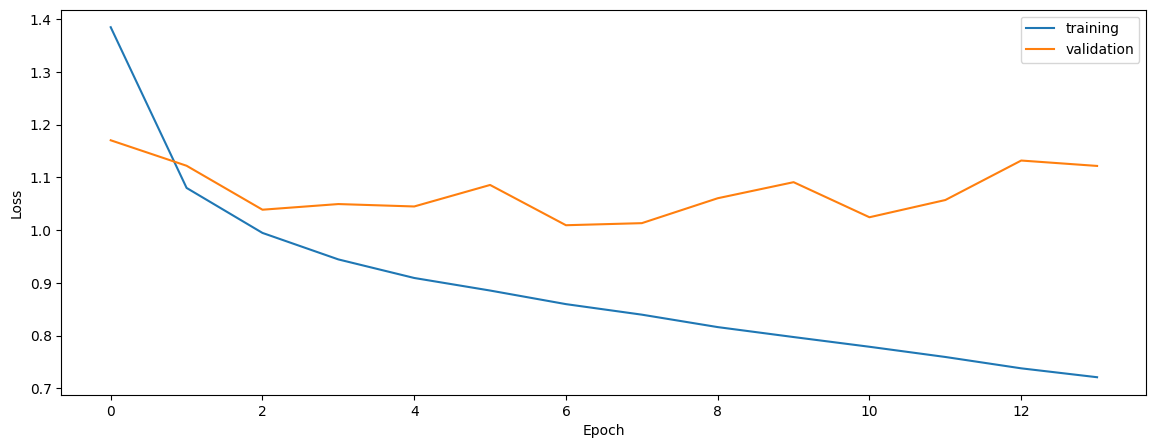

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6764640864369355
0.6157267026170253
0.6211266135485891


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5895855198113925
0.5778022805507745
0.5321321059290607


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5922069197178368
0.5706898448674221
0.5436801212810309


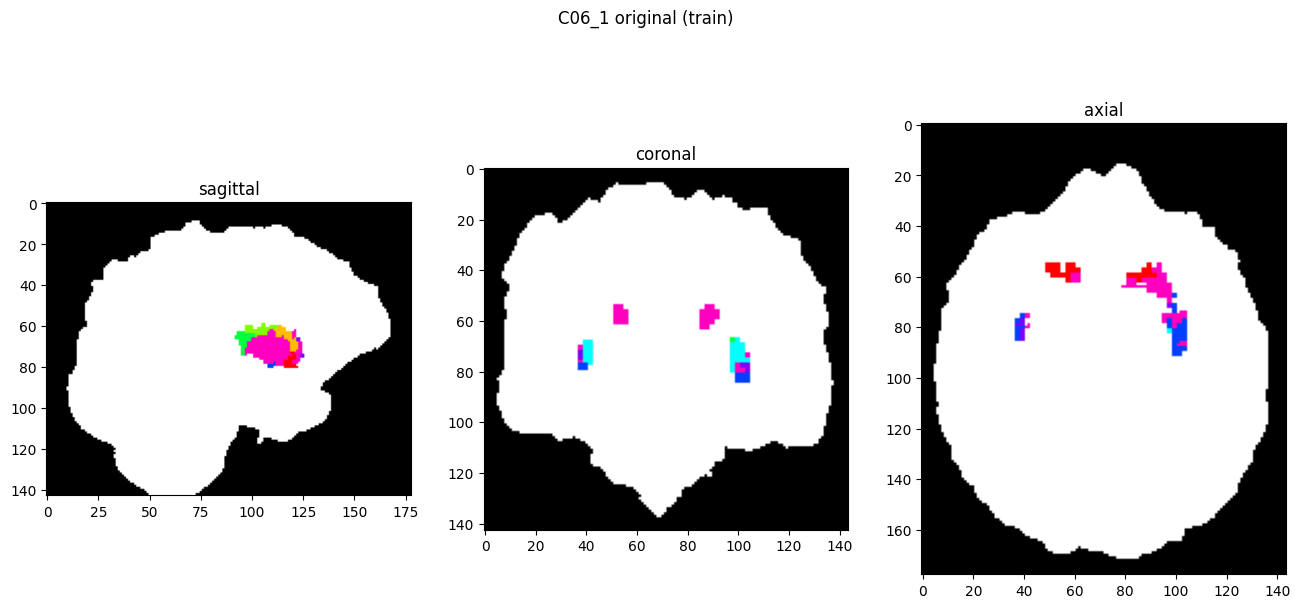

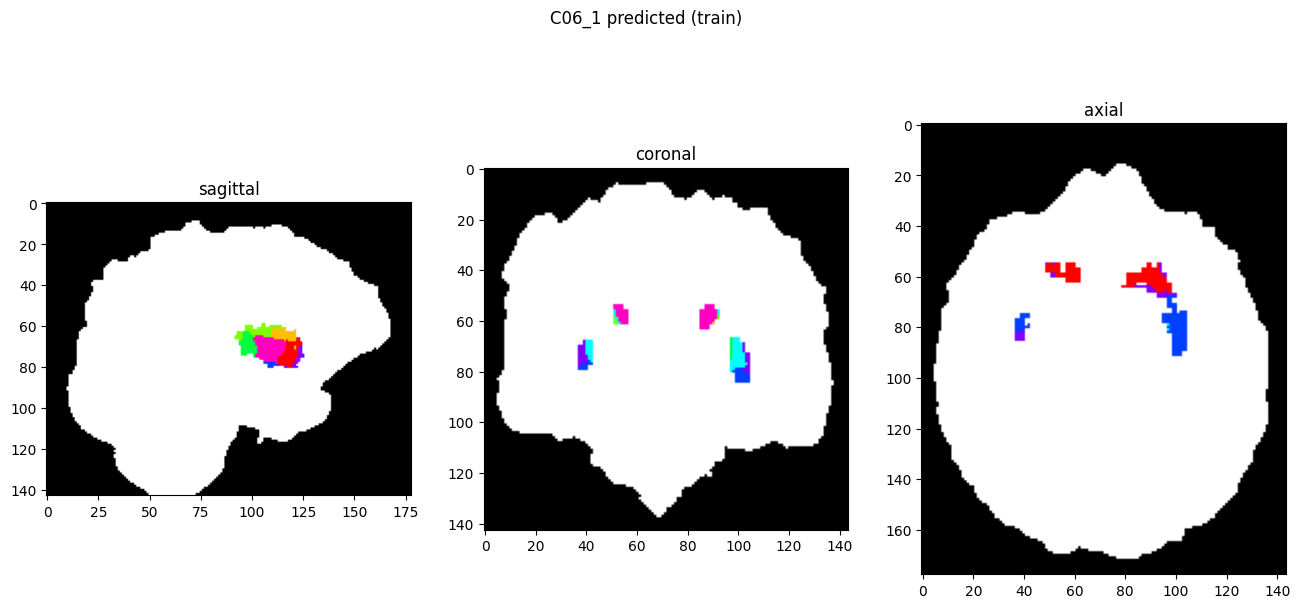

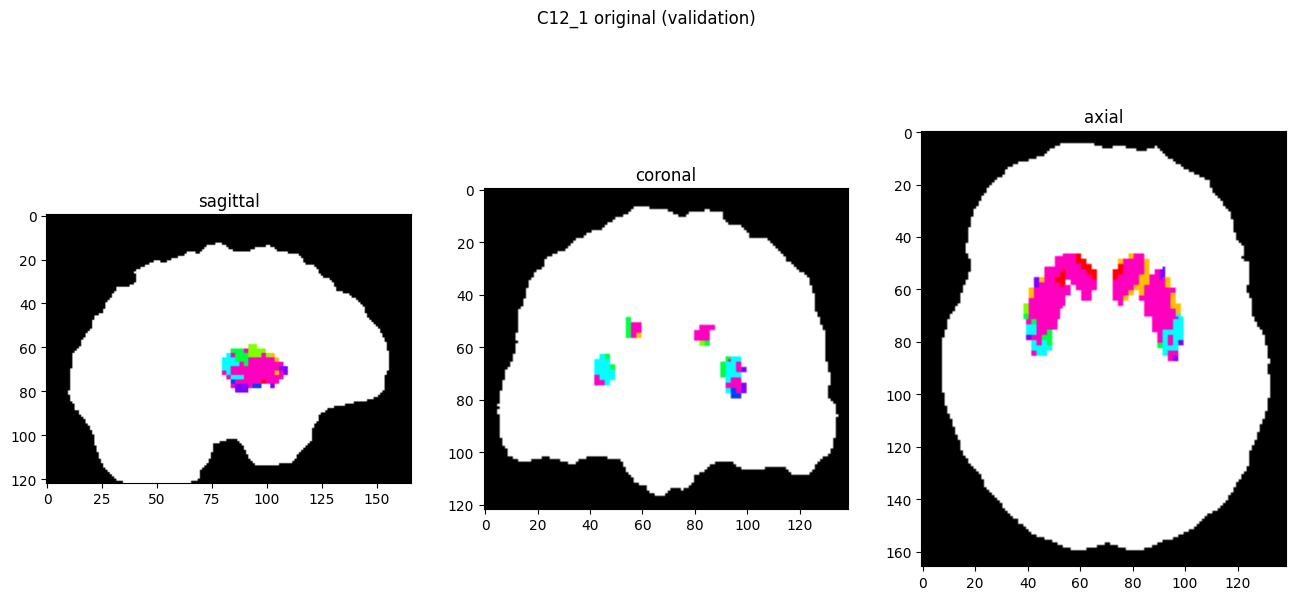

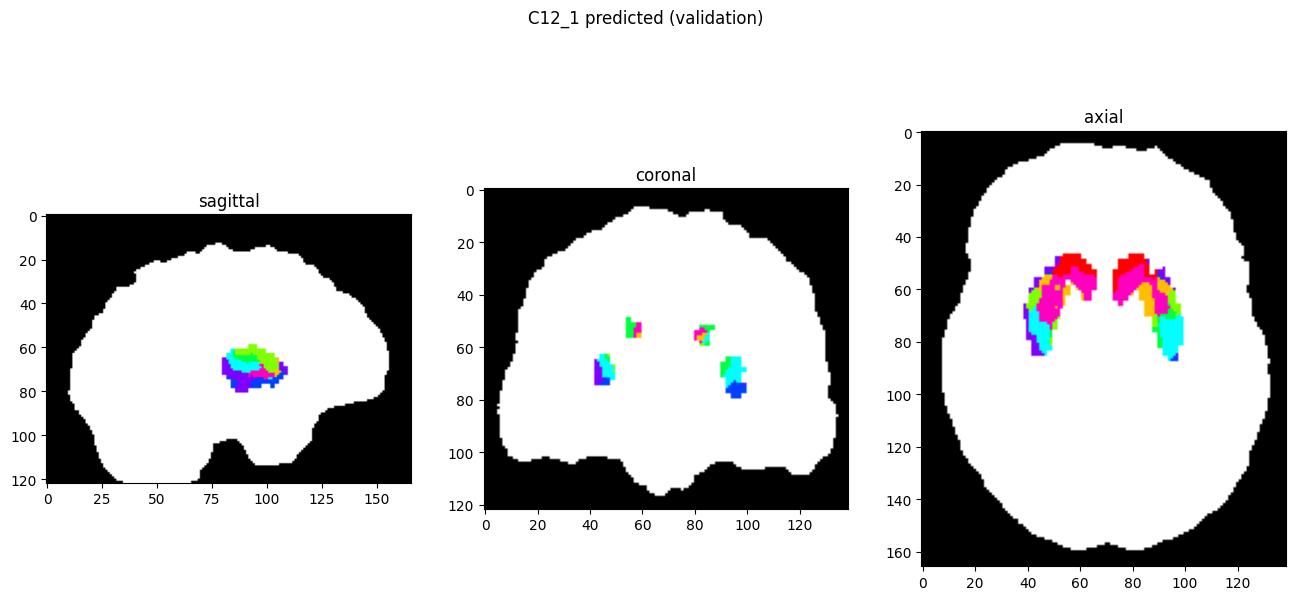

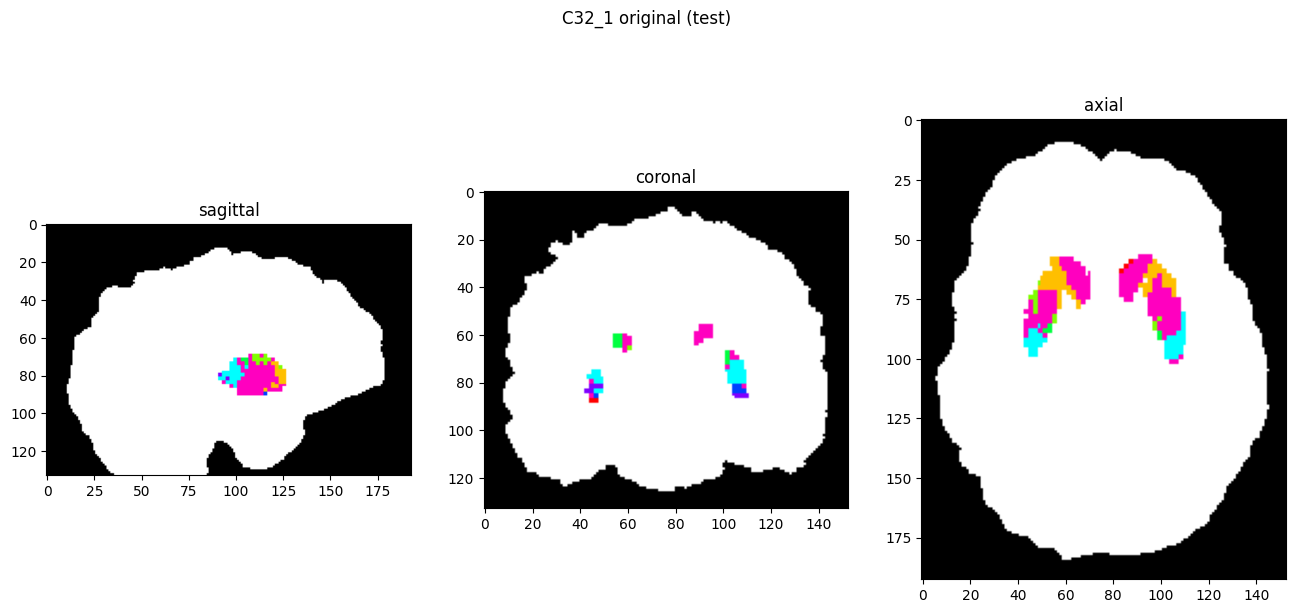

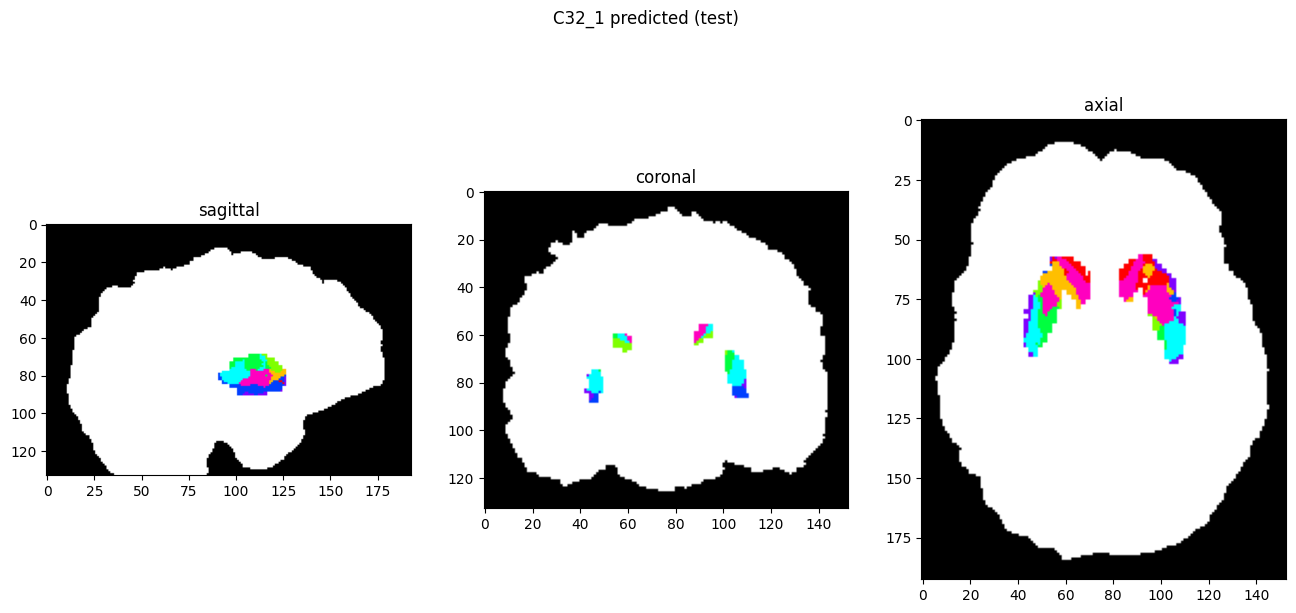

In [10]:
showResults(model, gen, threshold=0)